# Trigger efficiencies checks

Ivan Cambon Bouzas

In [2]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import uncertainties as un
import sys 
import os
import mplhep

python_modules_path = "/home3/ivan.cambon/Python_Modules"
sys.path.append(f'{python_modules_path}/RooPyShort')
sys.path.append(f'{python_modules_path}/RooPyFit')
import RooPyFit as rpf
import RooPyShort as rsh

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()
mplhep.styles.use(mplhep.styles.LHCb2)

Welcome to JupyROOT 6.28/04
-------------------------
Set LHCb Style - May 2021
-------------------------


In [6]:
folders = ["plots", "param_files", "root_files"]

for f in folders:
    if not os.path.exists(f"./{f}"):
        os.makedirs(f"./{f}")

pol  = "MagDown"
year = "2018"
run2 = False

In [7]:
def efficiencies(N1, N2, uN1, uN2):
    eff = N1 / N2
    ueff = eff * np.sqrt((uN1/N1)**2 + (uN2/N2)**2)
    return eff, ueff

def eff_trigger(N1, N2, N3, N4, uN1, uN2, uN3, uN4):
    eff_trig = N1 * N2 / (N3 * N4)
    ueff_trig = eff_trig * np.sqrt((uN1/N1)**2 + (uN2/N2)**2 + (uN3/N3)**2 + (uN4/N4)**2)
    return eff_trig, ueff_trig

def eff_plot(data, color, label, xlabel, ylabel, lgd, fst=True):
    data.SetMarkerColor(color)
    data.SetLineColor(color)
    data.GetXaxis().SetTitle(xlabel)
    data.GetYaxis().SetTitle(ylabel)
    data.GetYaxis().SetRangeUser(0, 1)
    if fst:
        data.Draw("ap")
    else:
        data.Draw("p same")
    lgd.AddEntry(data, label, "lpf")
    lgd.SetBorderSize(0)
    lgd.SetFillStyle(0)

## Data reading

In [12]:
head_path = "/scratch42/ivan.cambon/DsJ_Spectroscopy/Reduced/"
mc_path = f"{head_path}/MC/TightCut/raw"

dtt = "DsGammaTuple"
    
if run2:
    # data
    years = ["2016", "2017", "2018"]
    pols = ["MagDown", "MagUp"]
    
    data_paths = {f"{pol}{year}": f"{head_path}/Data/raw/{pol}/{year}" for pol in pols for year in years}
    data_files = {keys: os.listdir(values) for keys, values in data_paths.items()}
    data_files = [[f"{values1}/{file}" for file in values2] 
                  for ((keys1, values1), (keys2, values2)) in zip(data_paths.items(), data_files.items())]
    
    data_files = set(sum(data_files, []))
    tdf_data = ROOT.RDataFrame("DecayTree", data_files)
    
    # MC
    #tdf_Ds1_MC  = ROOT.RDataFrame("DecayTree", f"{mc_path}/Ds1DsGamma*.root")
    #tdf_Dsst_MC = ROOT.RDataFrame("DecayTree", f"{mc_path}/DsstDsGamma*.root")
    
else:
    # data
    data_path = f"{head_path}/Data/raw/{pol}/{year}"
    tdf_data = ROOT.RDataFrame("DecayTree", f"{head_path}/Data/raw/{pol}/{year}/*.root")
    
    # MC
    #tdf_Ds1_MC  = ROOT.RDataFrame("DecayTree", f"{mc_path}/Ds1DsGamma_{pol}{year}*.root")
    #tdf_Dsst_MC = ROOT.RDataFrame("DecayTree", f"{mc_path}/DsstDsGamma_{pol}{year}*.root")

tdf_Ds1_MC  = ROOT.RDataFrame("DecayTree", f"{mc_path}/Ds1DsGamma*.root")
tdf_Dsst_MC = ROOT.RDataFrame("DecayTree", f"{mc_path}/DsstDsGamma*.root")

derivated_features = {"DsgM": "Dsg_M-Ds_M+1969",
                      "PVZ_1PV": "PVZ[0]",
                      "dR_Dsg": "deltaR(Ds_ETA, Ds_PHI, gamma_ETA, gamma_PHI)",
                      "aPT_Dsg": "asym_PT(Ds_PT, gamma_PT)",
                      "aETA_Dsg": "asym_ETA(Ds_ETA, gamma_ETA)"
                      }

for keys, values in derivated_features.items():
    tdf_data = tdf_data.Define(keys, values)
    tdf_Ds1_MC = tdf_Ds1_MC.Define(keys, values)
    tdf_Dsst_MC = tdf_Dsst_MC.Define(keys, values)
    
# data mass windows
Dsst_mass = [2050, 2250]; Ds1_mass = [2350, 2600]

tdf_data_Dsst = tdf_data.Filter(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")
tdf_data_Ds1 = tdf_data.Filter(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")

# mctruth matching    
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Ds1_sig  = TRUEID_dtt["Ds1DsGamma"]
TRUEID_Dsst_sig = TRUEID_dtt["DsstDsGamma"]

tdf_Ds1_sig  = tdf_Ds1_MC.Filter(TRUEID_Ds1_sig)
tdf_Dsst_sig = tdf_Dsst_MC.Filter(TRUEID_Dsst_sig)

In [13]:
## plotting configs
Dsg_mass_label = "#it{M(D_{s}^{+}#gamma)} [MeV/c^{2}]"
ylabel = "A.U / (6 MeV/c^{2})"

## nVeloTracks bins
inters_path = "../../mass_fits/param_files"
inters_file = "Exp_Run2_nVeloTracks_binning_Ds1.txt"
nVelo_intervals = np.loadtxt(f"{inters_path}/{inters_file}")

ninters = len(nVelo_intervals) - 1

Ds1_vals_file = f"../../mass_fits/param_files/Exp_Run2_Ds1_sig_mass_fit_vals_{ninters}_nVelo.csv"
    
df_Ds1_fit_vals = pd.read_csv(Ds1_vals_file)

nVelo_means = df_Ds1_fit_vals["nVelo_mean"]
nVelo_up = df_Ds1_fit_vals["nVelo_uup"]
nVelo_down = df_Ds1_fit_vals["nVelo_udown"]

sel_path = "../../selection/"

evt_sel_file = open(f"{sel_path}/param_files/evt_selection.txt", "r")
evt_sel = evt_sel_file.read()
evt_sel_file.close()

cand_sel_file = open(f"{sel_path}/param_files/cand_selection.txt", "r")
cand_sel = cand_sel_file.read()
cand_sel_file.close()

sel = f"{evt_sel} && {cand_sel}"

In [14]:
tdf_Ds1_MC_sel = tdf_Ds1_MC.Filter(sel)
tdf_Dsst_MC_sel = tdf_Dsst_MC.Filter(sel)

tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter(sel)
tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter(sel)

tdf_data_sel = tdf_data.Filter(sel)
tdf_data_Ds1_sel = tdf_data_Ds1.Filter(sel)
tdf_data_Dsst_sel = tdf_data_Dsst.Filter(sel)

## L0 efficiencies

### RDataFrames preparation

In [15]:
lz_tis = "Dsg_L0Global_TIS == 1"
lz_tos = "Dsg_L0Global_TOS == 1"
lz_tistos = f"{lz_tis} & {lz_tos}"

In [16]:
tdf_Ds1_MC_sel_lz_tis = tdf_Ds1_MC_sel.Filter(lz_tis)
tdf_Ds1_MC_sel_lz_tos = tdf_Ds1_MC_sel.Filter(lz_tos)
tdf_Ds1_MC_sel_lz_tistos = tdf_Ds1_MC_sel.Filter(lz_tistos)

tdf_Dsst_MC_sel_lz_tis = tdf_Dsst_MC_sel.Filter(lz_tis)
tdf_Dsst_MC_sel_lz_tos = tdf_Dsst_MC_sel.Filter(lz_tos)
tdf_Dsst_MC_sel_lz_tistos = tdf_Dsst_MC_sel.Filter(lz_tistos)

tdf_Ds1_sig_sel_lz_tis = tdf_Ds1_sig_sel.Filter(lz_tis)
tdf_Ds1_sig_sel_lz_tos = tdf_Ds1_sig_sel.Filter(lz_tos)
tdf_Ds1_sig_sel_lz_tistos = tdf_Ds1_sig_sel.Filter(lz_tistos)

tdf_Dsst_sig_sel_lz_tis = tdf_Dsst_sig_sel.Filter(lz_tis)
tdf_Dsst_sig_sel_lz_tos = tdf_Dsst_sig_sel.Filter(lz_tos)
tdf_Dsst_sig_sel_lz_tistos = tdf_Dsst_sig_sel.Filter(lz_tistos)

In [17]:
tdf_data_sel_lz_tis = tdf_data_sel.Filter(lz_tis)
tdf_data_sel_lz_tos = tdf_data_sel.Filter(lz_tos)
tdf_data_sel_lz_tistos = tdf_data_sel.Filter(lz_tistos)

#### TIS and TOS efficiency as function of mass

In [18]:
def tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos, mass_bins=100):
    hdata_mass_sel_lz_tis = tdf_tis.Histo1D(("","",mass_bins,2050,3200), "DsgM")
    hdata_mass_sel_lz_tos = tdf_tos.Histo1D(("","",mass_bins,2050,3200), "DsgM")
    hdata_mass_sel_lz_tistos = tdf_tistos.Histo1D(("","",mass_bins,2050,3200), "DsgM")

    eff_lz_tis = ROOT.TGraphAsymmErrors()
    eff_lz_tis.SetName(f"eff_lz_tis")
    eff_lz_tis.Divide(hdata_mass_sel_lz_tistos.GetPtr(), hdata_mass_sel_lz_tos.GetPtr(), "cl=0.683 b(1,1) mode")

    eff_lz_tos = ROOT.TGraphAsymmErrors()
    eff_lz_tos.SetName(f"eff_lz_tos")
    eff_lz_tos.Divide(hdata_mass_sel_lz_tistos.GetPtr(), hdata_mass_sel_lz_tis.GetPtr(), "cl=0.683 b(1,1) mode")
    
    return eff_lz_tis, eff_lz_tos

##### nVeloTracks integrated

In [12]:
eff_Dsst_MC_lz_tis = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_lz_tis, tdf_Dsst_MC_sel_lz_tos, tdf_Dsst_MC_sel_lz_tistos))[0]
eff_Dsst_MC_lz_tos = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_lz_tis, tdf_Dsst_MC_sel_lz_tos, tdf_Dsst_MC_sel_lz_tistos))[1]

eff_Ds1_MC_lz_tis = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_lz_tis, tdf_Ds1_MC_sel_lz_tos, tdf_Ds1_MC_sel_lz_tistos))[0]
eff_Ds1_MC_lz_tos = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_lz_tis, tdf_Ds1_MC_sel_lz_tos, tdf_Ds1_MC_sel_lz_tistos))[1]

eff_Dsst_sig_lz_tis = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_lz_tis, tdf_Dsst_sig_sel_lz_tos, tdf_Dsst_sig_sel_lz_tistos))[0]
eff_Dsst_sig_lz_tos = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_lz_tis, tdf_Dsst_sig_sel_lz_tos, tdf_Dsst_sig_sel_lz_tistos))[1]

eff_Ds1_sig_lz_tis = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_lz_tis, tdf_Ds1_sig_sel_lz_tos, tdf_Ds1_sig_sel_lz_tistos))[0]
eff_Ds1_sig_lz_tos = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_lz_tis, tdf_Ds1_sig_sel_lz_tos, tdf_Ds1_sig_sel_lz_tistos))[1]

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 22 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 12 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 22 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 12 points have been skipped


In [13]:
eff_data_lz_tis = (tistos_effs_vs_mass(tdf_data_sel_lz_tis, tdf_data_sel_lz_tos, tdf_data_sel_lz_tistos))[0]
eff_data_lz_tos = (tistos_effs_vs_mass(tdf_data_sel_lz_tis, tdf_data_sel_lz_tos, tdf_data_sel_lz_tistos))[1]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_MagDown2018_lz_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_MagDown2018_lz_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_sig_MagDown2018_lz_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_sig_MagDown2018_lz_eff_vs_Dsg_mass.pdf has been created


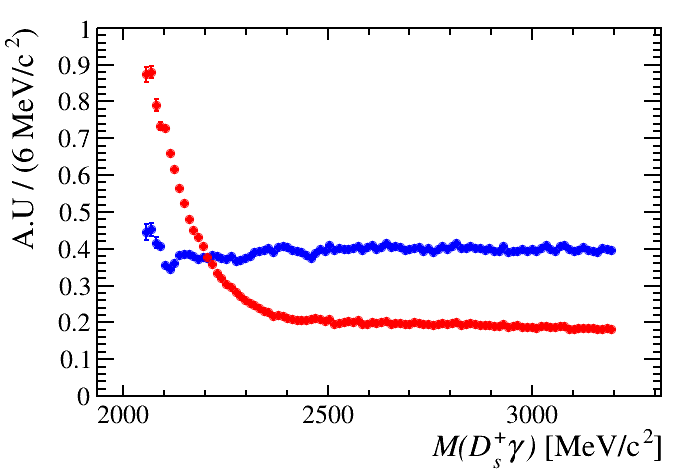

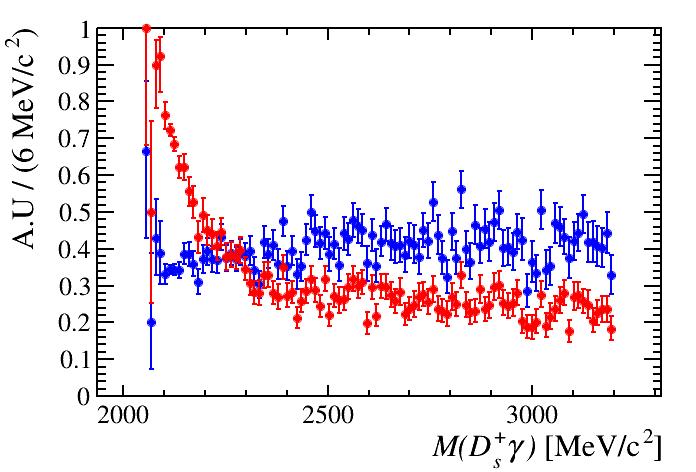

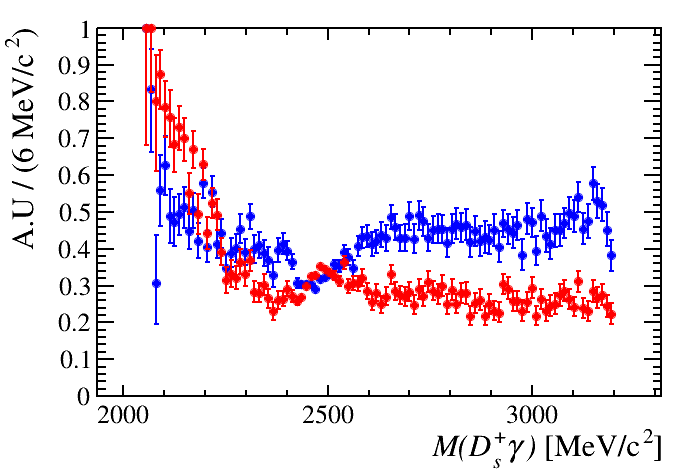

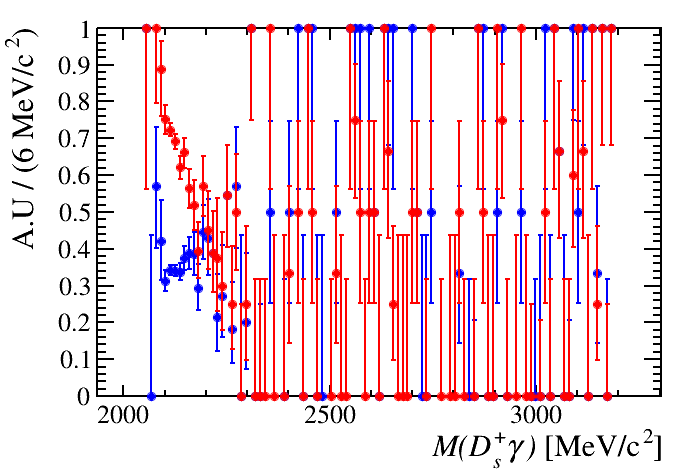

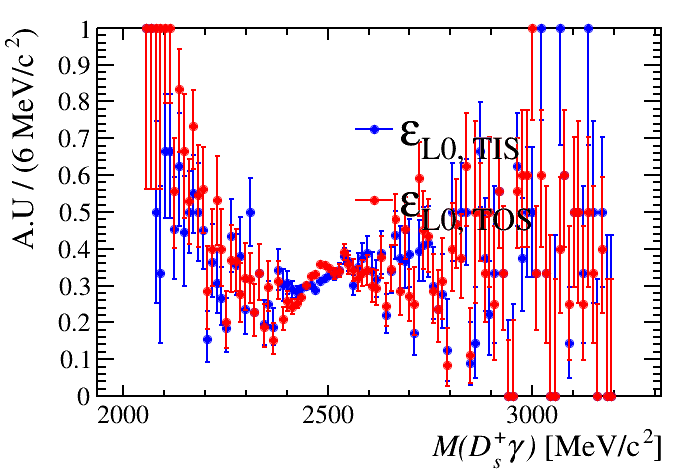

In [14]:
c1 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_data_lz_tis, ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_data_lz_tos, ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c1.Draw()
if run2:
    c1.SaveAs(f"./plots/Exp_Run2_lz_eff_vs_Dsg_mass.pdf")
else:
    c1.SaveAs(f"./plots/Exp_{pol}{year}_lz_eff_vs_Dsg_mass.pdf")
    
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_MC_lz_tis, ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_MC_lz_tos, ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Sim_Dsst_Run2_lz_eff_vs_Dsg_mass.pdf")
else:
    c2.SaveAs(f"./plots/Sim_Dsst_{pol}{year}_lz_eff_vs_Dsg_mass.pdf") 

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_MC_lz_tis, ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_MC_lz_tos, ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Sim_Ds1_Run2_lz_eff_vs_Dsg_mass.pdf")
else:
    c3.SaveAs(f"./plots/Sim_Ds1_{pol}{year}_lz_eff_vs_Dsg_mass.pdf")

c4 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_sig_lz_tis, ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_sig_lz_tos, ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c4.Draw()
if run2:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_Run2_lz_eff_vs_Dsg_mass.pdf")
else:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_{pol}{year}_lz_eff_vs_Dsg_mass.pdf") 

c5 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_sig_lz_tis, ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_sig_lz_tos, ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c5.Draw()
if run2:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_Run2_lz_eff_vs_Dsg_mass.pdf")
else:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_{pol}{year}_lz_eff_vs_Dsg_mass.pdf")

##### nVeloTracks binning

In [15]:
nVelo_bins = [[nVelo_intervals[i-1], nVelo_intervals[i]] for i in range(1, len(nVelo_intervals))]

tdf_data_sel_lz_tis_nVelo = [tdf_data_sel_lz_tis.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                             for bins in nVelo_bins] 
tdf_data_sel_lz_tos_nVelo = [tdf_data_sel_lz_tos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                             for bins in nVelo_bins] 
tdf_data_sel_lz_tistos_nVelo = [tdf_data_sel_lz_tistos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                                for bins in nVelo_bins] 


In [16]:
eff_data_lz_tis_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[0]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_lz_tis_nVelo, tdf_data_sel_lz_tos_nVelo, tdf_data_sel_lz_tistos_nVelo)]

eff_data_lz_tos_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[1]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_lz_tis_nVelo, tdf_data_sel_lz_tos_nVelo, tdf_data_sel_lz_tistos_nVelo)]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass_nVelo_1.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass_nVelo_2.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass_nVelo_3.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass_nVelo_4.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_vs_Dsg_mass_nVelo_5.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_tis_vs_Dsg_mass_nVelo_bins.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_lz_eff_tos_vs_Dsg_mass_nVelo_bins.pdf has been created


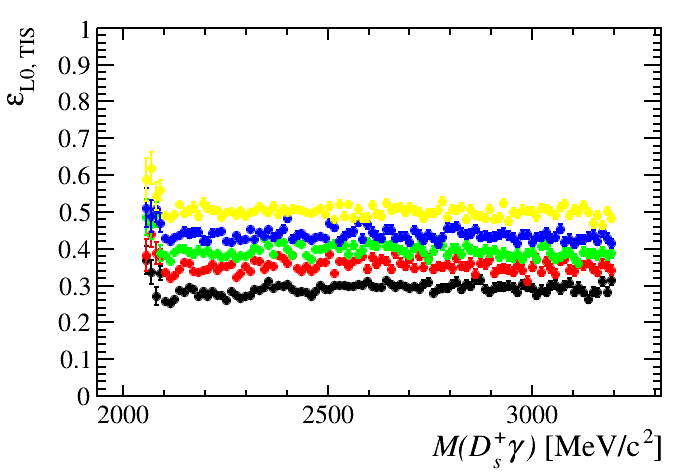

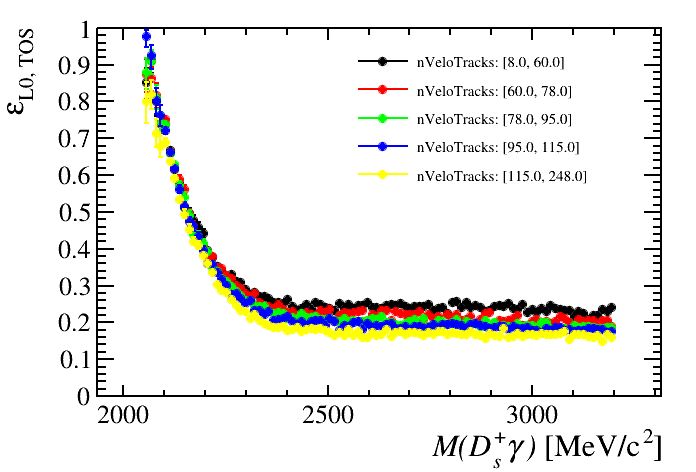

In [17]:
for i in range(len(nVelo_bins)):
    c1 = ROOT.TCanvas()
    lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
    eff_plot(eff_data_lz_tis_nVelo[i], ROOT.kBlue, "#varepsilon_{L0, TIS}", Dsg_mass_label, ylabel, lgd)
    eff_plot(eff_data_lz_tos_nVelo[i], ROOT.kRed, "#varepsilon_{L0, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
    lgd.Draw()
    #c1.Draw()
    if run2:
        c1.SaveAs(f"./plots/Exp_Run2_lz_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
    else:
        c1.SaveAs(f"./plots/Exp_{pol}{year}_lz_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
        
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.6, 0.9, 0.9)
i = 0
for eff, bin in zip(eff_data_lz_tis_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{L0, TIS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{L0, TIS}", lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Exp_Run2_lz_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c2.SaveAs(f"./plots/Exp_{pol}{year}_lz_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")  

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.6, 0.9, 0.9)
i = 0 
for eff, bin in zip(eff_data_lz_tos_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{L0, TOS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{L0, TOS}", lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Exp_Run2_lz_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c3.SaveAs(f"./plots/Exp_{pol}{year}_lz_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")

#### TIS and TOS efficiency as function of nVeloTracks

In [19]:
df_data_sel_lz_tos = pd.DataFrame(tdf_data_sel_lz_tos.AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_data_sel_lz_tistos = pd.DataFrame(tdf_data_sel_lz_tistos.AsNumpy(columns=["DsgM", "nVeloTracks"]))

### Dsst mass
df_data_Dsst_sel_lz_tos    = df_data_sel_lz_tos.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")
df_data_Dsst_sel_lz_tistos = df_data_sel_lz_tistos.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")

### Ds1 mass
df_data_Ds1_sel_lz_tos    = df_data_sel_lz_tos.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")
df_data_Ds1_sel_lz_tistos = df_data_sel_lz_tistos.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")

In [20]:
Ds1_mass_cut  = f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}"
Dsst_mass_cut = f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}"

df_Ds1_MC_sel_lz_tos =  pd.DataFrame(tdf_Ds1_MC_sel_lz_tos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_MC_sel_lz_tistos = pd.DataFrame(tdf_Ds1_MC_sel_lz_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_MC_sel_lz_tos =  pd.DataFrame(tdf_Dsst_MC_sel_lz_tos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_MC_sel_lz_tistos = pd.DataFrame(tdf_Dsst_MC_sel_lz_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

In [21]:
df_Ds1_sig_sel_lz_tos =  pd.DataFrame(tdf_Ds1_sig_sel_lz_tos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_sig_sel_lz_tistos = pd.DataFrame(tdf_Ds1_sig_sel_lz_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_sig_sel_lz_tos =  pd.DataFrame(tdf_Dsst_sig_sel_lz_tos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_sig_sel_lz_tistos = pd.DataFrame(tdf_Dsst_sig_sel_lz_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

##### nVeloTracks integrated

In [14]:
mNDsst_data_sel_lz_tos = len(df_data_Dsst_sel_lz_tos["DsgM"]); uNDsst_data_sel_lz_tos = np.sqrt(mNDsst_data_sel_lz_tos)
mNDsst_data_sel_lz_tistos = len(df_data_Dsst_sel_lz_tistos["DsgM"]); uNDsst_data_sel_lz_tistos = np.sqrt(mNDsst_data_sel_lz_tistos)

NDsst_data_sel_lz_tos    = un.ufloat(mNDsst_data_sel_lz_tos, uNDsst_data_sel_lz_tos)
NDsst_data_sel_lz_tistos = un.ufloat(mNDsst_data_sel_lz_tistos, uNDsst_data_sel_lz_tistos)

eff_data_lz_tis_Dsst = NDsst_data_sel_lz_tistos / NDsst_data_sel_lz_tos

print(f"L0 TIS eff for Dsst mass in data = {eff_data_lz_tis_Dsst}")

mNDs1_data_sel_lz_tos = len(df_data_Ds1_sel_lz_tos["DsgM"]); uNDs1_data_sel_lz_tos = np.sqrt(mNDs1_data_sel_lz_tos)
mNDs1_data_sel_lz_tistos = len(df_data_Ds1_sel_lz_tistos["DsgM"]); uNDs1_data_sel_lz_tistos = np.sqrt(mNDs1_data_sel_lz_tistos)

NDs1_data_sel_lz_tos    = un.ufloat(mNDs1_data_sel_lz_tos, uNDs1_data_sel_lz_tos)
NDs1_data_sel_lz_tistos = un.ufloat(mNDs1_data_sel_lz_tistos, uNDs1_data_sel_lz_tistos)

eff_data_lz_tis_Ds1 = NDs1_data_sel_lz_tistos / NDs1_data_sel_lz_tos

print(f"L0 TIS eff for Ds1 mass in data = {eff_data_lz_tis_Ds1}")

L0 TIS eff for Dsst mass in data = 0.3679+/-0.0015
L0 TIS eff for Ds1 mass in data = 0.3968+/-0.0015


In [15]:
mNDsst_MC_sel_lz_tos = len(df_Dsst_MC_sel_lz_tos["DsgM"]); uNDsst_MC_sel_lz_tos = np.sqrt(mNDsst_MC_sel_lz_tos)
mNDsst_MC_sel_lz_tistos = len(df_Dsst_MC_sel_lz_tistos["DsgM"]); uNDsst_MC_sel_lz_tistos = np.sqrt(mNDsst_MC_sel_lz_tistos)

NDsst_MC_sel_lz_tos    = un.ufloat(mNDsst_MC_sel_lz_tos, uNDsst_MC_sel_lz_tos)
NDsst_MC_sel_lz_tistos = un.ufloat(mNDsst_MC_sel_lz_tistos, uNDsst_MC_sel_lz_tistos)

eff_MC_lz_tis_Dsst = NDsst_MC_sel_lz_tistos / NDsst_MC_sel_lz_tos

print(f"L0 TIS eff for Dsst mass in not truth-matched MC = {eff_MC_lz_tis_Dsst}")

mNDs1_MC_sel_lz_tos = len(df_Ds1_MC_sel_lz_tos["DsgM"]); uNDs1_MC_sel_lz_tos = np.sqrt(mNDs1_MC_sel_lz_tos)
mNDs1_MC_sel_lz_tistos = len(df_Ds1_MC_sel_lz_tistos["DsgM"]); uNDs1_MC_sel_lz_tistos = np.sqrt(mNDs1_MC_sel_lz_tistos)

NDs1_MC_sel_lz_tos    = un.ufloat(mNDs1_MC_sel_lz_tos, uNDs1_MC_sel_lz_tos)
NDs1_MC_sel_lz_tistos = un.ufloat(mNDs1_MC_sel_lz_tistos, uNDs1_MC_sel_lz_tistos)

eff_MC_lz_tis_Ds1 = NDs1_MC_sel_lz_tistos / NDs1_MC_sel_lz_tos

print(f"L0 TIS eff for Ds1 mass in not truth-matched MC = {eff_MC_lz_tis_Ds1}")

L0 TIS eff for Dsst mass in not truth-matched MC = 0.355+/-0.009
L0 TIS eff for Ds1 mass in not truth-matched MC = 0.3159+/-0.0028


In [16]:
mNDsst_sig_sel_lz_tos = len(df_Dsst_sig_sel_lz_tos["DsgM"]); uNDsst_sig_sel_lz_tos = np.sqrt(mNDsst_sig_sel_lz_tos)
mNDsst_sig_sel_lz_tistos = len(df_Dsst_sig_sel_lz_tistos["DsgM"]); uNDsst_sig_sel_lz_tistos = np.sqrt(mNDsst_sig_sel_lz_tistos)

NDsst_sig_sel_lz_tos    = un.ufloat(mNDsst_sig_sel_lz_tos, uNDsst_sig_sel_lz_tos)
NDsst_sig_sel_lz_tistos = un.ufloat(mNDsst_sig_sel_lz_tistos, uNDsst_sig_sel_lz_tistos)

eff_sig_lz_tis_Dsst = NDsst_sig_sel_lz_tistos / NDsst_sig_sel_lz_tos

print(f"L0 TIS eff for Dsst mass in truth-matched MC = {eff_sig_lz_tis_Dsst}")

mNDs1_sig_sel_lz_tos = len(df_Ds1_sig_sel_lz_tos["DsgM"]); uNDs1_sig_sel_lz_tos = np.sqrt(mNDs1_sig_sel_lz_tos)
mNDs1_sig_sel_lz_tistos = len(df_Ds1_sig_sel_lz_tistos["DsgM"]); uNDs1_sig_sel_lz_tistos = np.sqrt(mNDs1_sig_sel_lz_tistos)

NDs1_sig_sel_lz_tos    = un.ufloat(mNDs1_sig_sel_lz_tos, uNDs1_sig_sel_lz_tos)
NDs1_sig_sel_lz_tistos = un.ufloat(mNDs1_sig_sel_lz_tistos, uNDs1_sig_sel_lz_tistos)

eff_sig_lz_tis_Ds1 = NDs1_sig_sel_lz_tistos / NDs1_sig_sel_lz_tos

print(f"L0 TIS eff for Ds1 mass in truth-matched MC = {eff_sig_lz_tis_Ds1}")

L0 TIS eff for Dsst mass in truth-matched MC = 0.344+/-0.011
L0 TIS eff for Ds1 mass in truth-matched MC = 0.3050+/-0.0029


##### nVeloTracks binning

data

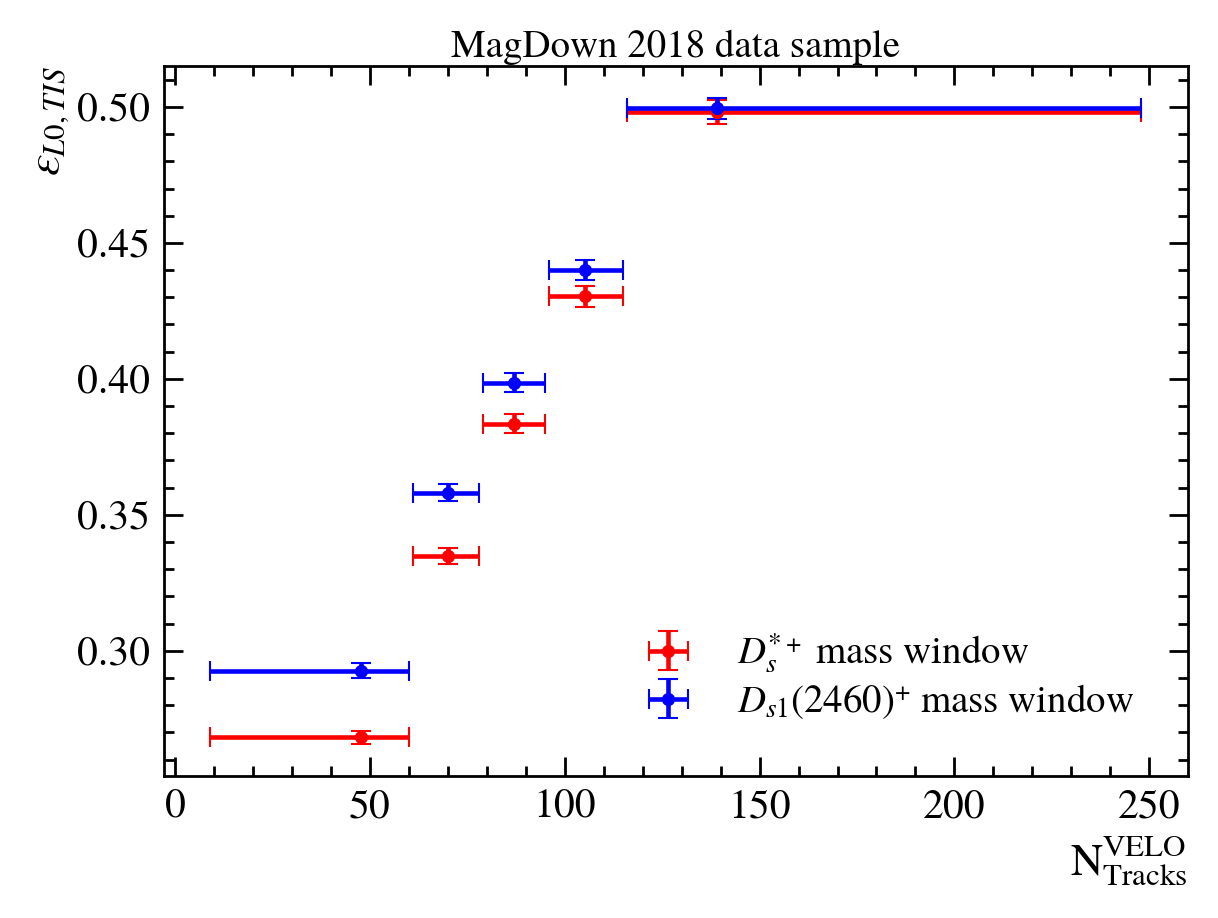

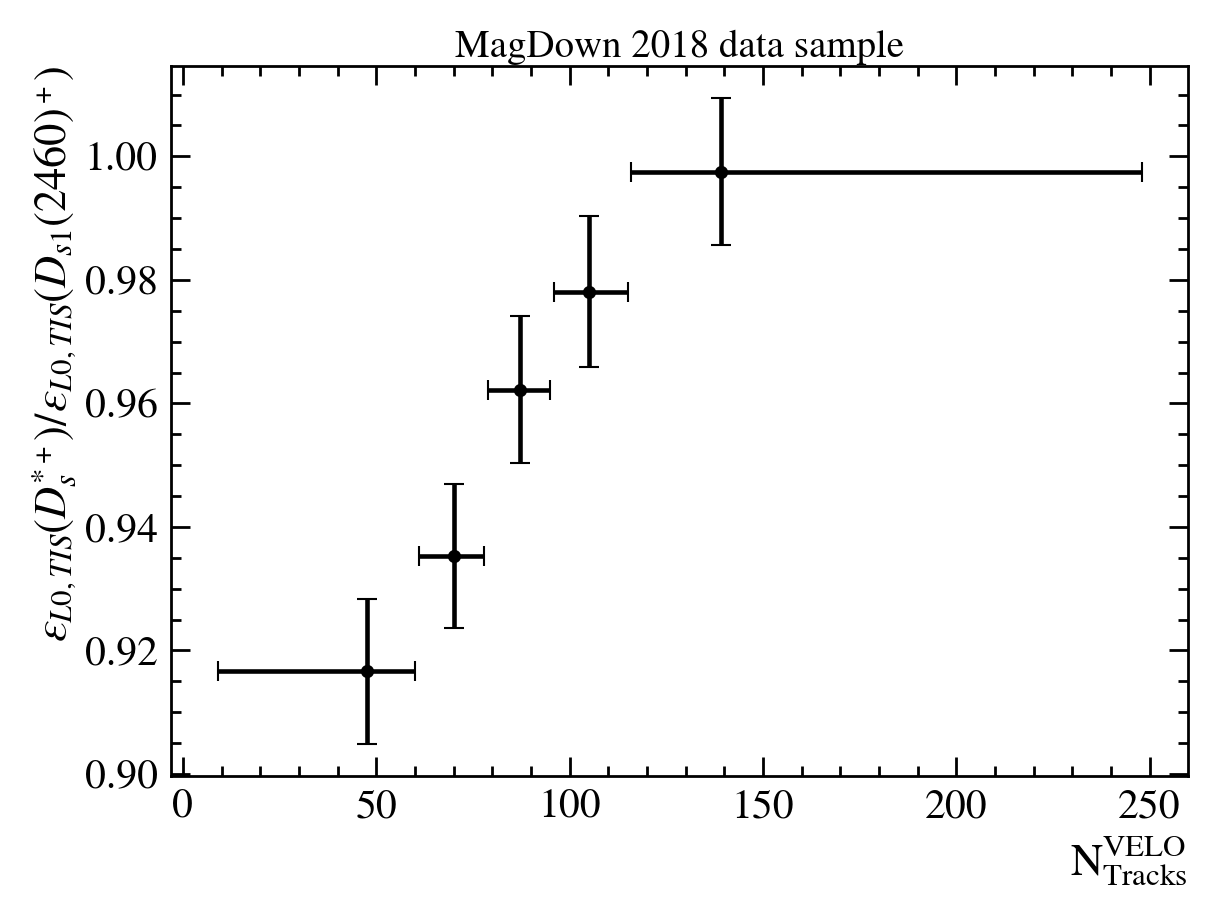

In [ ]:
### Dsst mass
mN_data_nVelo_Dsst_sel_lz_tos, nVelo_bins    = np.histogram(df_data_Dsst_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Dsst_sel_lz_tistos, nVelo_bins = np.histogram(df_data_Dsst_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Dsst_sel_lz_tos = np.sqrt(mN_data_nVelo_Dsst_sel_lz_tos)
uN_data_nVelo_Dsst_sel_lz_tistos = np.sqrt(mN_data_nVelo_Dsst_sel_lz_tistos)

N_data_nVelo_Dsst_sel_lz_tos    = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_lz_tos, uN_data_nVelo_Dsst_sel_lz_tos)])
N_data_nVelo_Dsst_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_lz_tistos, uN_data_nVelo_Dsst_sel_lz_tistos)])

eff_data_lz_tis_nVelo_Dsst  = N_data_nVelo_Dsst_sel_lz_tistos / N_data_nVelo_Dsst_sel_lz_tos

meff_data_lz_tis_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_data_lz_tis_nVelo_Dsst])
ueff_data_lz_tis_nVelo_Dsst = np.array([eff.std_dev for eff in eff_data_lz_tis_nVelo_Dsst])

### Ds1 mass
mN_data_nVelo_Ds1_sel_lz_tos, nVelo_bins    = np.histogram(df_data_Ds1_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Ds1_sel_lz_tistos, nVelo_bins = np.histogram(df_data_Ds1_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Ds1_sel_lz_tos    = np.sqrt(mN_data_nVelo_Ds1_sel_lz_tos)
uN_data_nVelo_Ds1_sel_lz_tistos = np.sqrt(mN_data_nVelo_Ds1_sel_lz_tistos)

N_data_nVelo_Ds1_sel_lz_tos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_lz_tos, uN_data_nVelo_Ds1_sel_lz_tos)])
N_data_nVelo_Ds1_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_lz_tistos, uN_data_nVelo_Ds1_sel_lz_tistos)])

eff_data_lz_tis_nVelo_Ds1  = N_data_nVelo_Ds1_sel_lz_tistos / N_data_nVelo_Ds1_sel_lz_tos

meff_data_lz_tis_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_data_lz_tis_nVelo_Ds1])
ueff_data_lz_tis_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_data_lz_tis_nVelo_Ds1])

### ratio
eff_data_lz_tis_nVelo_ratio  = eff_data_lz_tis_nVelo_Dsst / eff_data_lz_tis_nVelo_Ds1
meff_data_lz_tis_nVelo_ratio = np.array([r.nominal_value for r in eff_data_lz_tis_nVelo_ratio])
ueff_data_lz_tis_nVelo_ratio = np.array([r.std_dev for r in eff_data_lz_tis_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Dsst, ueff_data_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Ds1, ueff_data_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_ratio, ueff_data_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Not matched MC

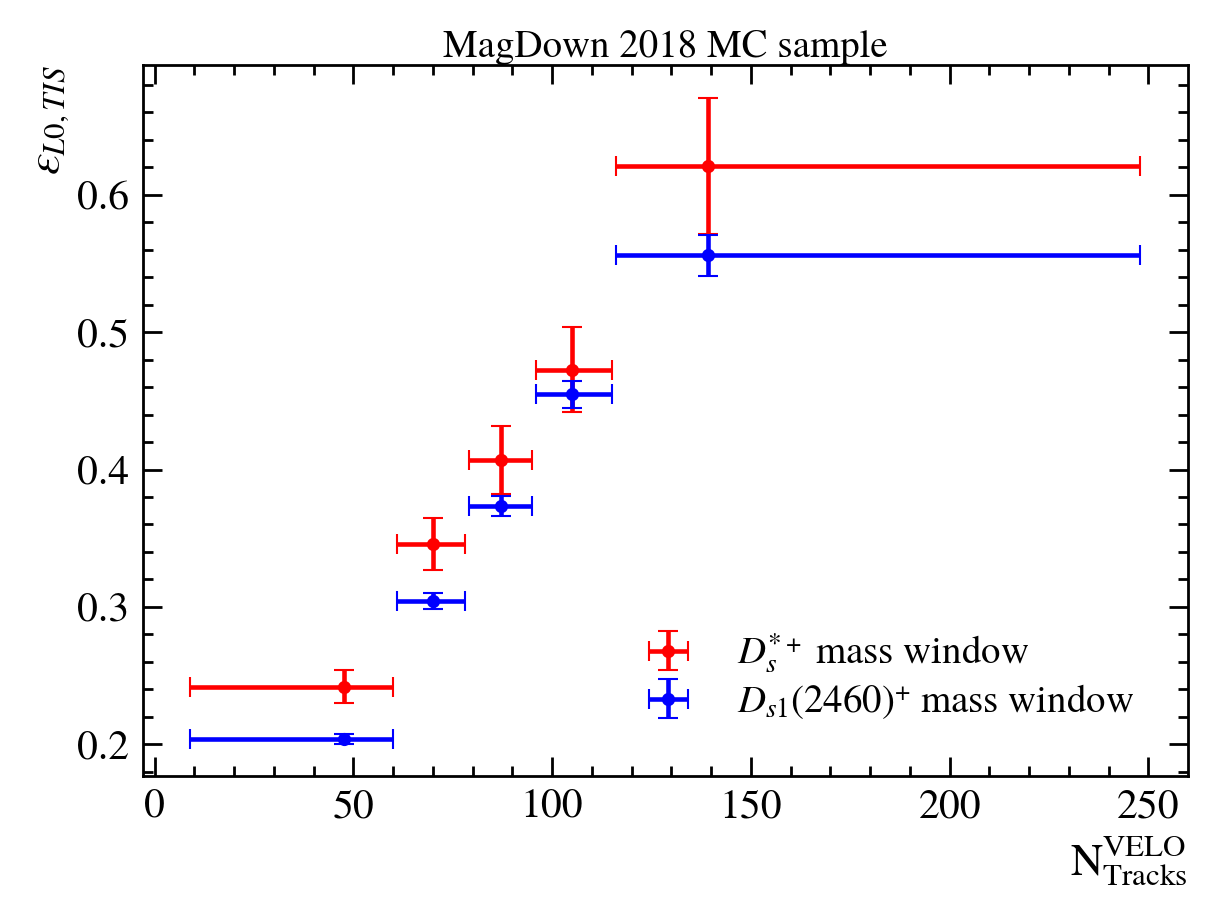

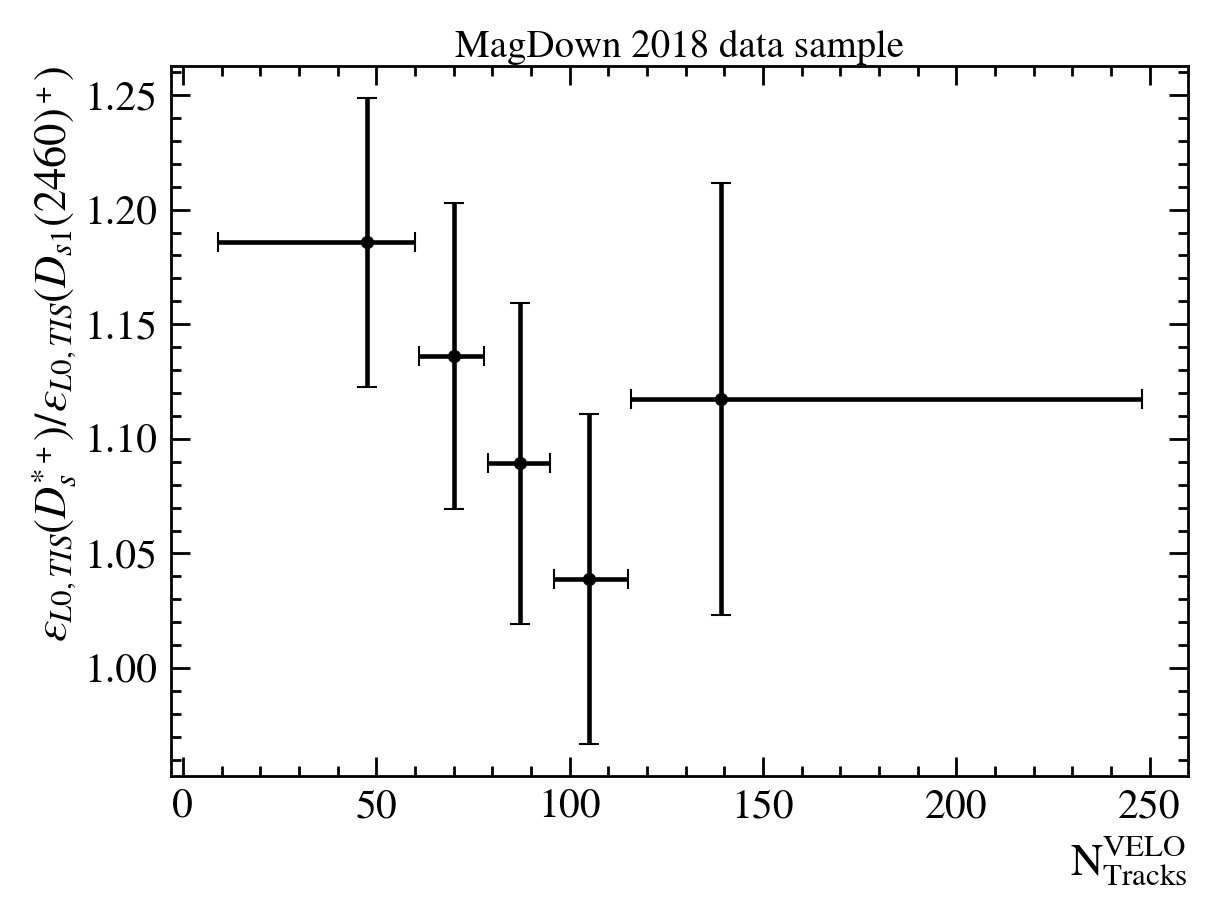

In [21]:
### Dsst mass
mN_mc_nVelo_Dsst_sel_lz_tos, nVelo_bins    = np.histogram(df_Dsst_MC_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Dsst_sel_lz_tistos, nVelo_bins = np.histogram(df_Dsst_MC_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Dsst_sel_lz_tos = np.sqrt(mN_mc_nVelo_Dsst_sel_lz_tos)
uN_mc_nVelo_Dsst_sel_lz_tistos = np.sqrt(mN_mc_nVelo_Dsst_sel_lz_tistos)

N_mc_nVelo_Dsst_sel_lz_tos    = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_lz_tos, uN_mc_nVelo_Dsst_sel_lz_tos)])
N_mc_nVelo_Dsst_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_lz_tistos, uN_mc_nVelo_Dsst_sel_lz_tistos)])

eff_mc_lz_tis_nVelo_Dsst  = N_mc_nVelo_Dsst_sel_lz_tistos / N_mc_nVelo_Dsst_sel_lz_tos

meff_mc_lz_tis_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_mc_lz_tis_nVelo_Dsst])
ueff_mc_lz_tis_nVelo_Dsst = np.array([eff.std_dev for eff in eff_mc_lz_tis_nVelo_Dsst])

### Ds1 mass
mN_mc_nVelo_Ds1_sel_lz_tos, nVelo_bins    = np.histogram(df_Ds1_MC_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Ds1_sel_lz_tistos, nVelo_bins = np.histogram(df_Ds1_MC_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Ds1_sel_lz_tos    = np.sqrt(mN_mc_nVelo_Ds1_sel_lz_tos)
uN_mc_nVelo_Ds1_sel_lz_tistos = np.sqrt(mN_mc_nVelo_Ds1_sel_lz_tistos)

N_mc_nVelo_Ds1_sel_lz_tos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_lz_tos, uN_mc_nVelo_Ds1_sel_lz_tos)])
N_mc_nVelo_Ds1_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_lz_tistos, uN_mc_nVelo_Ds1_sel_lz_tistos)])

eff_mc_lz_tis_nVelo_Ds1  = N_mc_nVelo_Ds1_sel_lz_tistos / N_mc_nVelo_Ds1_sel_lz_tos

ueff_mc_lz_tis_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_mc_lz_tis_nVelo_Ds1])
meff_mc_lz_tis_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_mc_lz_tis_nVelo_Ds1])

### ratio
eff_mc_lz_tis_nVelo_ratio  = eff_mc_lz_tis_nVelo_Dsst / eff_mc_lz_tis_nVelo_Ds1
meff_mc_lz_tis_nVelo_ratio = np.array([r.nominal_value for r in eff_mc_lz_tis_nVelo_ratio])
ueff_mc_lz_tis_nVelo_ratio = np.array([r.std_dev for r in eff_mc_lz_tis_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_Dsst, ueff_mc_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_Ds1, ueff_mc_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_ratio, ueff_mc_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Matched MC

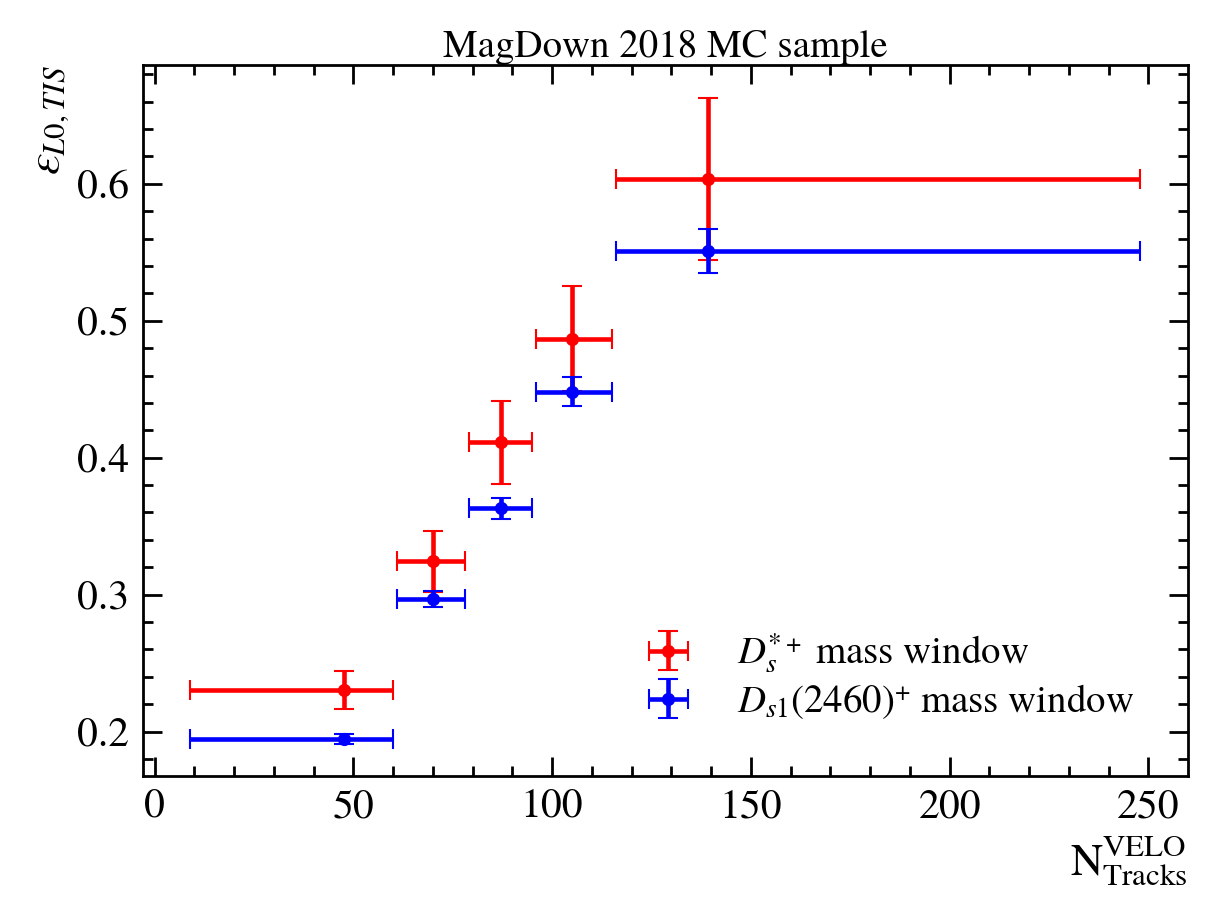

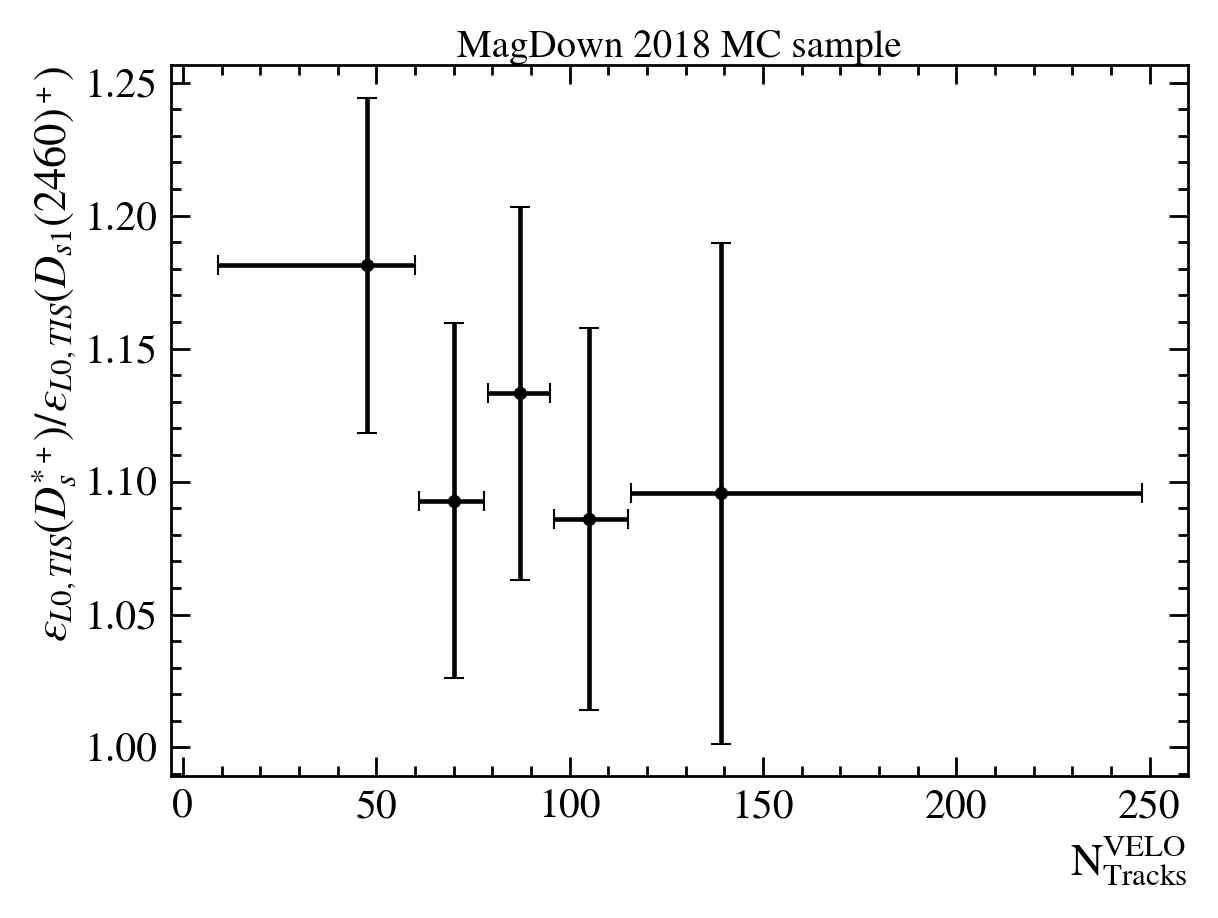

In [20]:
### Dsst mass
mN_sig_nVelo_Dsst_sel_lz_tos, nVelo_bins    = np.histogram(df_Dsst_sig_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Dsst_sel_lz_tistos, nVelo_bins = np.histogram(df_Dsst_sig_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Dsst_sel_lz_tos = np.sqrt(mN_sig_nVelo_Dsst_sel_lz_tos)
uN_sig_nVelo_Dsst_sel_lz_tistos = np.sqrt(mN_sig_nVelo_Dsst_sel_lz_tistos)

N_sig_nVelo_Dsst_sel_lz_tos    = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_lz_tos, uN_sig_nVelo_Dsst_sel_lz_tos)])
N_sig_nVelo_Dsst_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_lz_tistos, uN_sig_nVelo_Dsst_sel_lz_tistos)])

eff_sig_lz_tis_nVelo_Dsst  = N_sig_nVelo_Dsst_sel_lz_tistos / N_sig_nVelo_Dsst_sel_lz_tos

meff_sig_lz_tis_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_sig_lz_tis_nVelo_Dsst])
ueff_sig_lz_tis_nVelo_Dsst = np.array([eff.std_dev for eff in eff_sig_lz_tis_nVelo_Dsst])

### Ds1 mass
mN_sig_nVelo_Ds1_sel_lz_tos, nVelo_bins    = np.histogram(df_Ds1_sig_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Ds1_sel_lz_tistos, nVelo_bins = np.histogram(df_Ds1_sig_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Ds1_sel_lz_tos    = np.sqrt(mN_sig_nVelo_Ds1_sel_lz_tos)
uN_sig_nVelo_Ds1_sel_lz_tistos = np.sqrt(mN_sig_nVelo_Ds1_sel_lz_tistos)

N_sig_nVelo_Ds1_sel_lz_tos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_lz_tos, uN_sig_nVelo_Ds1_sel_lz_tos)])
N_sig_nVelo_Ds1_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_lz_tistos, uN_sig_nVelo_Ds1_sel_lz_tistos)])

eff_sig_lz_tis_nVelo_Ds1  = N_sig_nVelo_Ds1_sel_lz_tistos / N_sig_nVelo_Ds1_sel_lz_tos

meff_sig_lz_tis_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_sig_lz_tis_nVelo_Ds1])
ueff_sig_lz_tis_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_sig_lz_tis_nVelo_Ds1])

### ratio
eff_sig_lz_tis_nVelo_ratio  = eff_sig_lz_tis_nVelo_Dsst / eff_sig_lz_tis_nVelo_Ds1
meff_sig_lz_tis_nVelo_ratio = np.array([r.nominal_value for r in eff_sig_lz_tis_nVelo_ratio])
ueff_sig_lz_tis_nVelo_ratio = np.array([r.std_dev for r in eff_sig_lz_tis_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_Dsst, ueff_sig_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_Ds1, ueff_sig_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_ratio, ueff_MC_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} MC sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Comparision data and MC

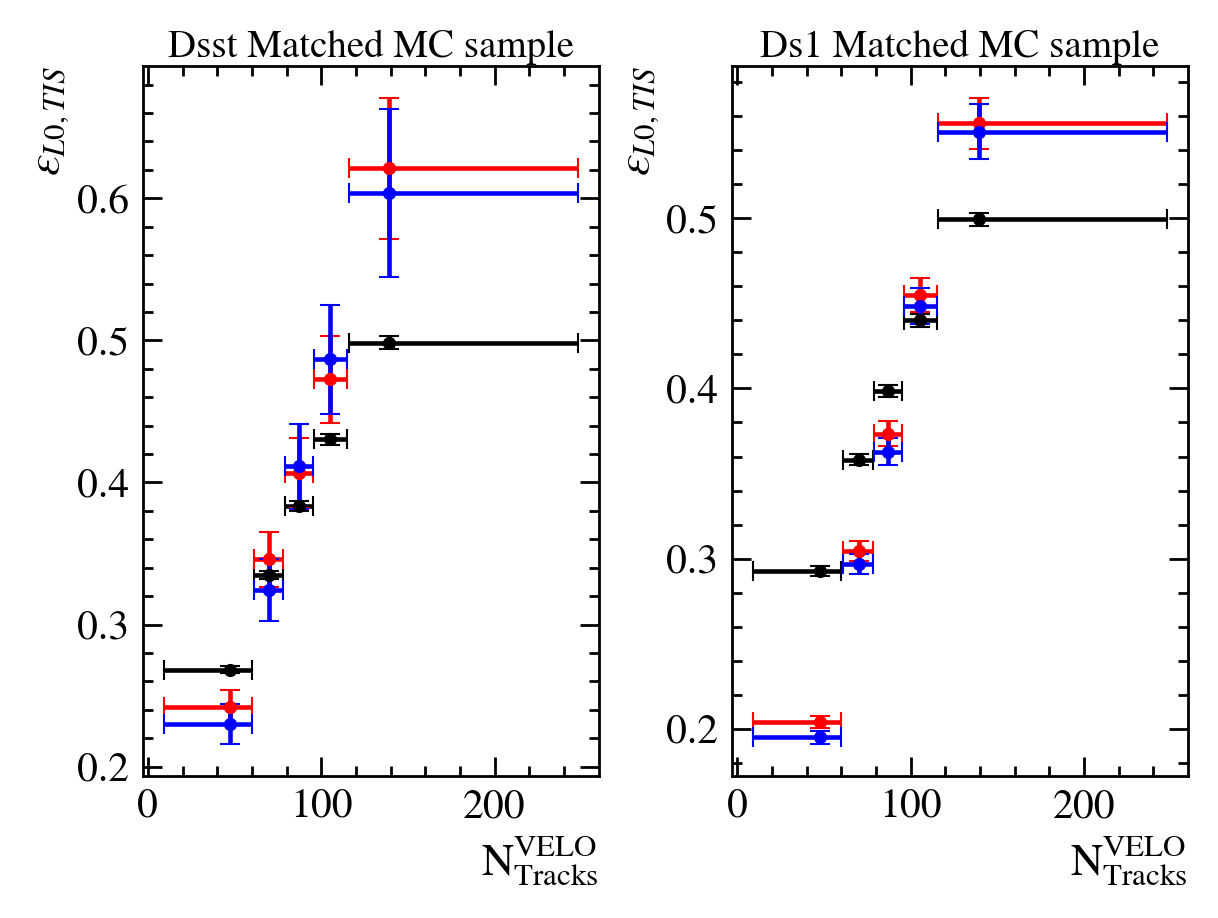

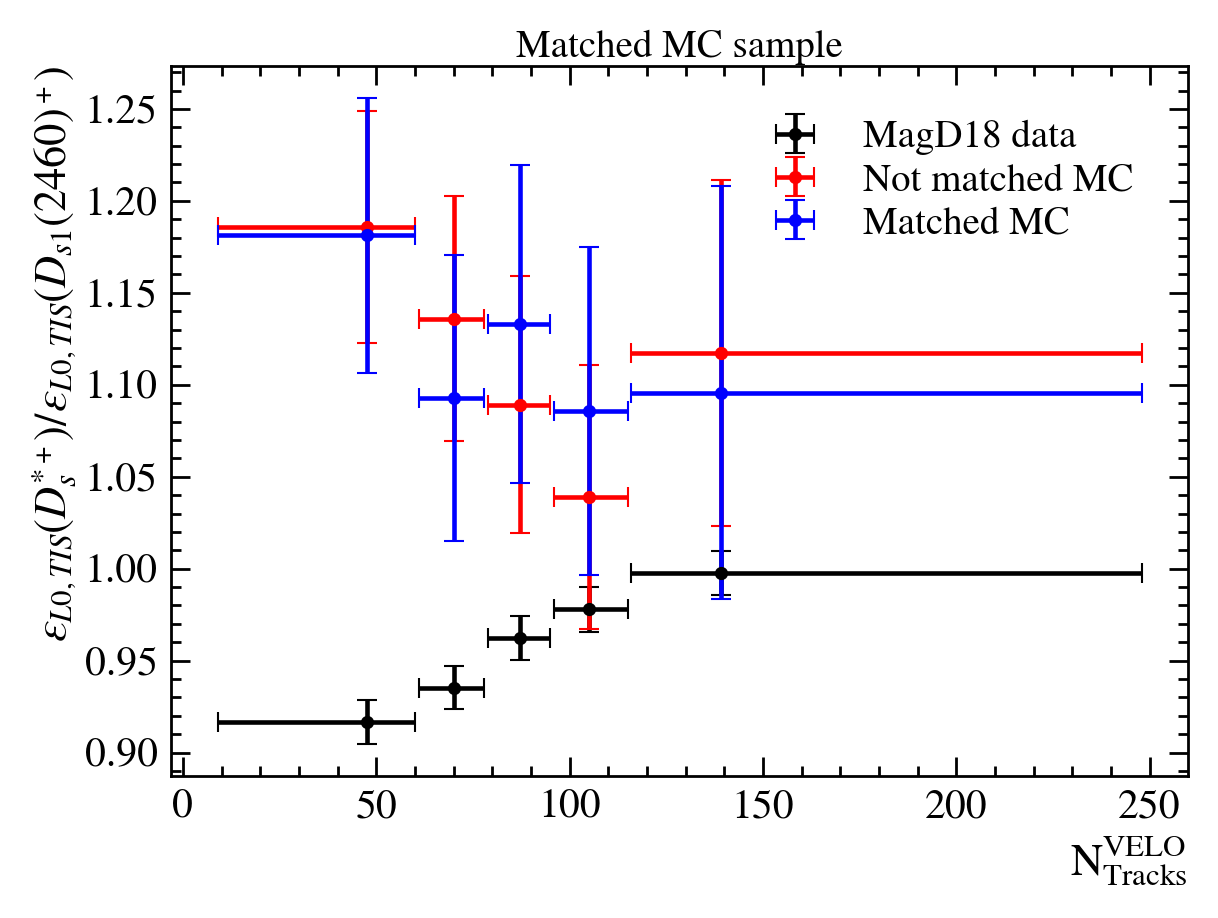

In [22]:
plt.figure(1)
plt.subplot(121)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Dsst, ueff_data_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_Dsst, ueff_mc_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_Dsst, ueff_sig_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Dsst Matched MC sample")
#plt.legend(loc='lower right')
plt.subplot(122)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Ds1, ueff_data_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_Ds1, ueff_mc_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_Ds1, ueff_sig_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Ds1 Matched MC sample")
plt.savefig(f"./plots/Comp_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')


plt.figure(2)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_ratio, ueff_data_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label="MagD18 data")
plt.errorbar(nVelo_means, meff_mc_lz_tis_nVelo_ratio, ueff_mc_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label="Not matched MC")
plt.errorbar(nVelo_means, meff_sig_lz_tis_nVelo_ratio, ueff_sig_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label="Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"Matched MC sample")
plt.legend()
plt.savefig(f"./plots/Comp_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

#### No signal mas region ratio

In [23]:
hm_cut  = "DsgM > 2700 & DsgM <= 2900"
uhm_cut = "DsgM > 2900"  

In [40]:
### Dsst mass
df_data_hm_sel_lz_tos    = df_data_sel_lz_tos.query(hm_cut)
df_data_hm_sel_lz_tistos = df_data_sel_lz_tistos.query(hm_cut)

### Ds1 mass
df_data_uhm_sel_lz_tos    = df_data_sel_lz_tos.query(uhm_cut)
df_data_uhm_sel_lz_tistos = df_data_sel_lz_tistos.query(uhm_cut)

NameError: name 'hm_cut' is not defined

##### nVeloTracks integrated

In [26]:
mN_data_hm_sel_lz_tos = len(df_data_hm_sel_lz_tos["DsgM"]); uN_data_hm_sel_lz_tos = np.sqrt(mN_data_hm_sel_lz_tos)
mN_data_hm_sel_lz_tistos = len(df_data_hm_sel_lz_tistos["DsgM"]); uN_data_hm_sel_lz_tistos = np.sqrt(mN_data_hm_sel_lz_tistos)

N_data_hm_sel_lz_tos = un.ufloat(mN_data_hm_sel_lz_tos, uN_data_hm_sel_lz_tos)
N_data_hm_sel_lz_tistos = un.ufloat(mN_data_hm_sel_lz_tistos, uN_data_hm_sel_lz_tistos)

eff_data_lz_tis_hm  = N_data_hm_sel_lz_tistos / N_data_hm_sel_lz_tos

print(f"L0 TIS eff for {hm_cut} mass in data = {eff_data_lz_tis_hm}")

mN_data_uhm_sel_lz_tos = len(df_data_uhm_sel_lz_tos["DsgM"]); uN_data_uhm_sel_lz_tos = np.sqrt(mN_data_uhm_sel_lz_tos)
mN_data_uhm_sel_lz_tistos = len(df_data_uhm_sel_lz_tistos["DsgM"]); uN_data_uhm_sel_lz_tistos = np.sqrt(mN_data_uhm_sel_lz_tistos)

N_data_uhm_sel_lz_tos = un.ufloat(mN_data_uhm_sel_lz_tos, uN_data_uhm_sel_lz_tos)
N_data_uhm_sel_lz_tistos = un.ufloat(mN_data_uhm_sel_lz_tistos, uN_data_uhm_sel_lz_tistos)

eff_data_lz_tis_uhm  = N_data_uhm_sel_lz_tistos / N_data_uhm_sel_lz_tos

print(f"L0 TIS eff for {uhm_cut} mass in data = {eff_data_lz_tis_uhm}")

L0 TIS eff for DsgM > 2700 & DsgM <= 2900 mass in data = 0.4022+/-0.0019
L0 TIS eff for DsgM > 2900 mass in data = 0.3986+/-0.0015


##### nVeloTracks binning

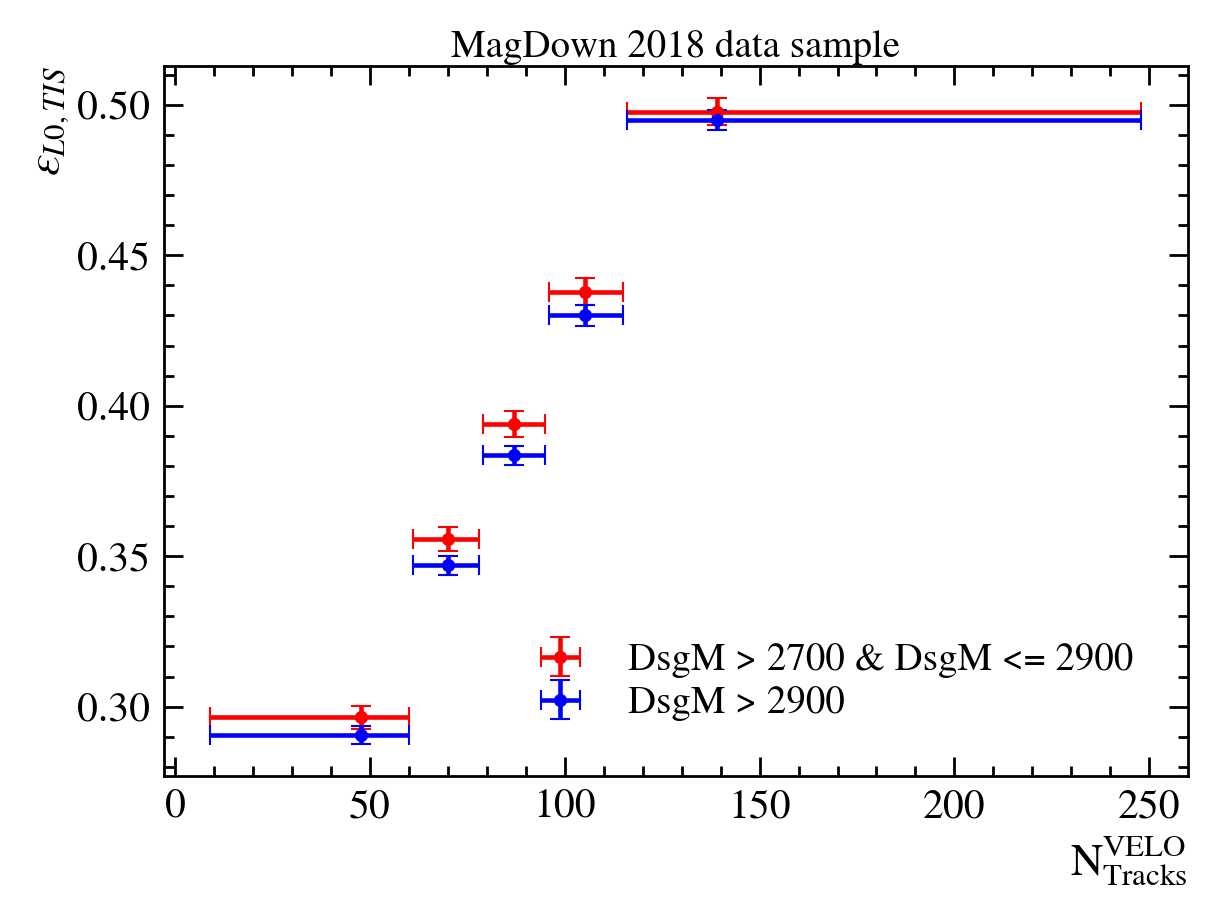

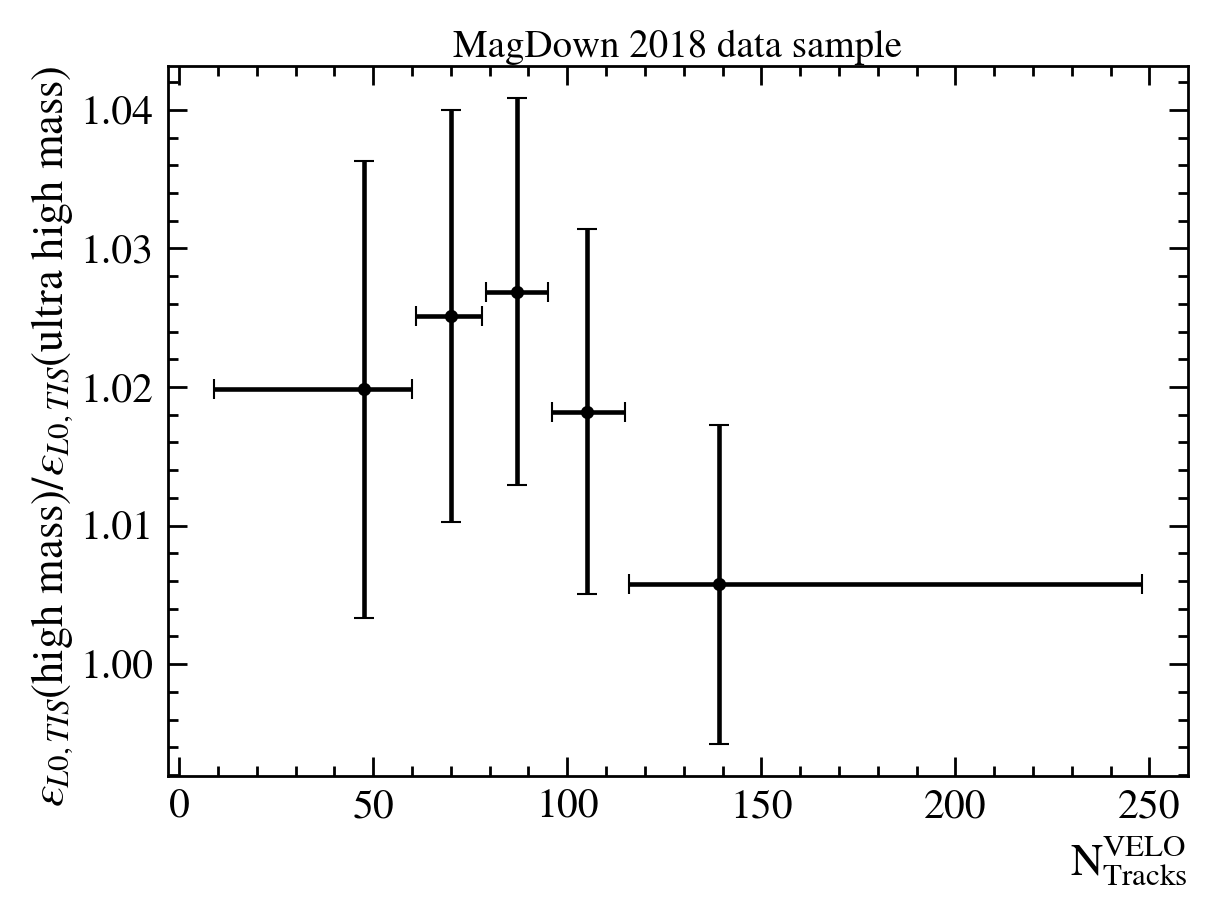

In [ ]:
### Dsst mass
mN_data_nVelo_hm_sel_lz_tos, nVelo_bins    = np.histogram(df_data_hm_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_hm_sel_lz_tistos, nVelo_bins = np.histogram(df_data_hm_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_hm_sel_lz_tos = np.sqrt(mN_data_nVelo_Dsst_sel_lz_tos)
uN_data_nVelo_hm_sel_lz_tistos = np.sqrt(mN_data_nVelo_Dsst_sel_lz_tistos)

N_data_nVelo_hm_sel_lz_tos    = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_lz_tos, uN_data_nVelo_hm_sel_lz_tos)])
N_data_nVelo_hm_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_lz_tistos, uN_data_nVelo_hm_sel_lz_tistos)])

eff_data_lz_tis_nVelo_hm  = N_data_nVelo_hm_sel_lz_tistos / N_data_nVelo_hm_sel_lz_tos

meff_data_lz_tis_nVelo_hm = np.array([eff.nominal_value for eff in eff_data_lz_tis_nVelo_hm])
ueff_data_lz_tis_nVelo_hm = np.array([eff.std_dev for eff in eff_data_lz_tis_nVelo_hm])

### Ds1 mass
mN_data_nVelo_uhm_sel_lz_tos, nVelo_bins    = np.histogram(df_data_uhm_sel_lz_tos["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_uhm_sel_lz_tistos, nVelo_bins = np.histogram(df_data_uhm_sel_lz_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_uhm_sel_lz_tos    = np.sqrt(mN_data_nVelo_uhm_sel_lz_tos)
uN_data_nVelo_uhm_sel_lz_tistos = np.sqrt(mN_data_nVelo_uhm_sel_lz_tistos)

N_data_nVelo_uhm_sel_lz_tos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_lz_tos, uN_data_nVelo_uhm_sel_lz_tos)])
N_data_nVelo_uhm_sel_lz_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_lz_tistos, uN_data_nVelo_uhm_sel_lz_tistos)])

eff_data_lz_tis_nVelo_uhm  = N_data_nVelo_uhm_sel_lz_tistos / N_data_nVelo_uhm_sel_lz_tos

meff_data_lz_tis_nVelo_uhm = np.array([eff.nominal_value for eff in eff_data_lz_tis_nVelo_uhm])
ueff_data_lz_tis_nVelo_uhm = np.array([eff.std_dev for eff in eff_data_lz_tis_nVelo_uhm])

### ratio
eff_data_lz_tis_nVelo_ratio  = eff_data_lz_tis_nVelo_Dsst / eff_data_lz_tis_nVelo_Ds1
meff_data_lz_tis_nVelo_ratio = np.array([r.nominal_value for r in eff_data_lz_tis_nVelo_ratio])
ueff_data_lz_tis_nVelo_ratio = np.array([r.std_dev for r in eff_data_lz_tis_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Dsst, ueff_data_lz_tis_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_Ds1, ueff_data_lz_tis_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_lz_tis_nVelo_ratio, ueff_data_lz_tis_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_lz_tis_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



## HLT1 efficiencies

In [25]:
hlt1_tis = "Ds_Hlt1Phys_TIS"
hlt1_tos = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
hlt1_tistos = f"{hlt1_tis} & {hlt1_tos}"

In [26]:
tdf_Ds1_MC_sel_hlt1_tis = tdf_Ds1_MC_sel_lz_tis.Filter(hlt1_tis)
tdf_Ds1_MC_sel_hlt1_tos = tdf_Ds1_MC_sel_lz_tis.Filter(hlt1_tos)
tdf_Ds1_MC_sel_hlt1_tistos = tdf_Ds1_MC_sel_lz_tis.Filter(hlt1_tistos)

tdf_Dsst_MC_sel_hlt1_tis = tdf_Dsst_MC_sel_lz_tis.Filter(hlt1_tis)
tdf_Dsst_MC_sel_hlt1_tos = tdf_Dsst_MC_sel_lz_tis.Filter(hlt1_tos)
tdf_Dsst_MC_sel_hlt1_tistos = tdf_Dsst_MC_sel_lz_tis.Filter(hlt1_tistos)

tdf_Ds1_sig_sel_hlt1_tis = tdf_Ds1_sig_sel_lz_tis.Filter(hlt1_tis)
tdf_Ds1_sig_sel_hlt1_tos = tdf_Ds1_sig_sel_lz_tis.Filter(hlt1_tos)
tdf_Ds1_sig_sel_hlt1_tistos = tdf_Ds1_sig_sel_lz_tis.Filter(hlt1_tistos)

tdf_Dsst_sig_sel_hlt1_tis = tdf_Dsst_sig_sel_lz_tis.Filter(hlt1_tis)
tdf_Dsst_sig_sel_hlt1_tos = tdf_Dsst_sig_sel_lz_tis.Filter(hlt1_tos)
tdf_Dsst_sig_sel_hlt1_tistos = tdf_Dsst_sig_sel_lz_tis.Filter(hlt1_tistos)

In [27]:
tdf_data_sel_hlt1_tis = tdf_data_sel_lz_tis.Filter(hlt1_tis)
tdf_data_sel_hlt1_tos = tdf_data_sel_lz_tis.Filter(hlt1_tos)
tdf_data_sel_hlt1_tistos = tdf_data_sel_lz_tis.Filter(hlt1_tistos)

##### nVeloTracks integrated

In [34]:
eff_Dsst_MC_hlt1_tis = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_hlt1_tis, tdf_Dsst_MC_sel_hlt1_tos, tdf_Dsst_MC_sel_hlt1_tistos))[0]
eff_Dsst_MC_hlt1_tos = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_hlt1_tis, tdf_Dsst_MC_sel_hlt1_tos, tdf_Dsst_MC_sel_hlt1_tistos))[1]

eff_Ds1_MC_hlt1_tis = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_hlt1_tis, tdf_Ds1_MC_sel_hlt1_tos, tdf_Ds1_MC_sel_hlt1_tistos))[0]
eff_Ds1_MC_hlt1_tos = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_hlt1_tis, tdf_Ds1_MC_sel_hlt1_tos, tdf_Ds1_MC_sel_hlt1_tistos))[1]

eff_Dsst_sig_hlt1_tis = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_hlt1_tis, tdf_Dsst_sig_sel_hlt1_tos, tdf_Dsst_sig_sel_hlt1_tistos))[0]
eff_Dsst_sig_hlt1_tos = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_hlt1_tis, tdf_Dsst_sig_sel_hlt1_tos, tdf_Dsst_sig_sel_hlt1_tistos))[1]

eff_Ds1_sig_hlt1_tis = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_hlt1_tis, tdf_Ds1_sig_sel_hlt1_tos, tdf_Ds1_sig_sel_hlt1_tistos))[0]
eff_Ds1_sig_hlt1_tos = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_hlt1_tis, tdf_Ds1_sig_sel_hlt1_tos, tdf_Ds1_sig_sel_hlt1_tistos))[1]

NameError: name 'tistos_effs_vs_mass' is not defined

In [36]:
eff_data_hlt1_tis = (tistos_effs_vs_mass(tdf_data_sel_hlt1_tis, tdf_data_sel_hlt1_tos, tdf_data_sel_hlt1_tistos))[0]
eff_data_hlt1_tos = (tistos_effs_vs_mass(tdf_data_sel_hlt1_tis, tdf_data_sel_hlt1_tos, tdf_data_sel_hlt1_tistos))[1]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_MagDown2018_hlt1_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_MagDown2018_hlt1_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_sig_MagDown2018_hlt1_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_sig_MagDown2018_hlt1_eff_vs_Dsg_mass.pdf has been created


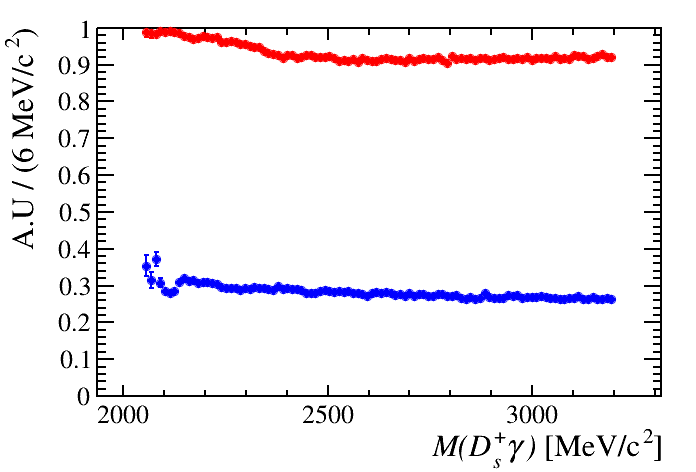

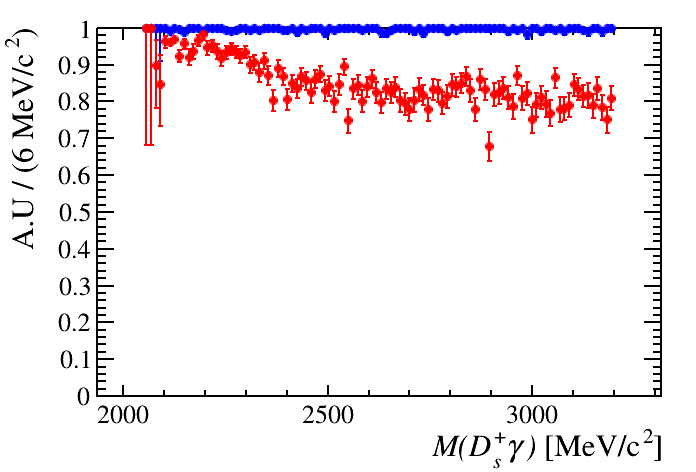

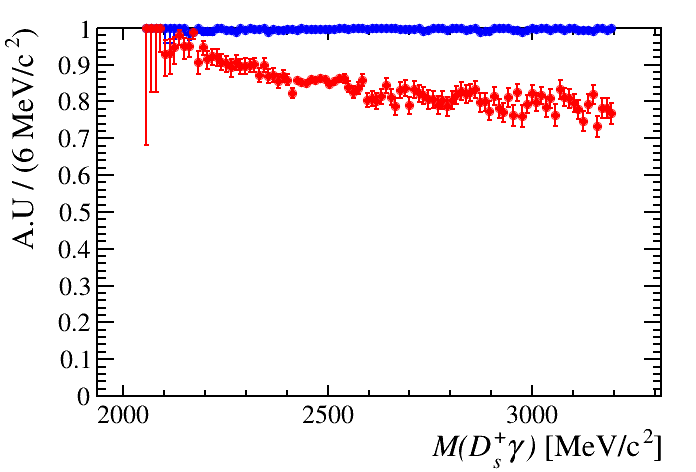

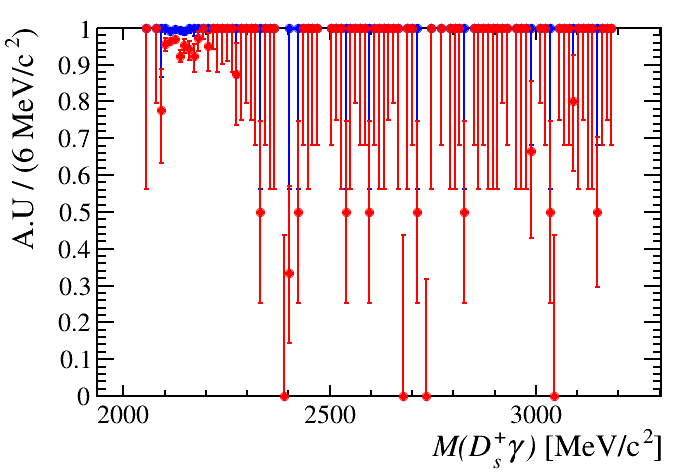

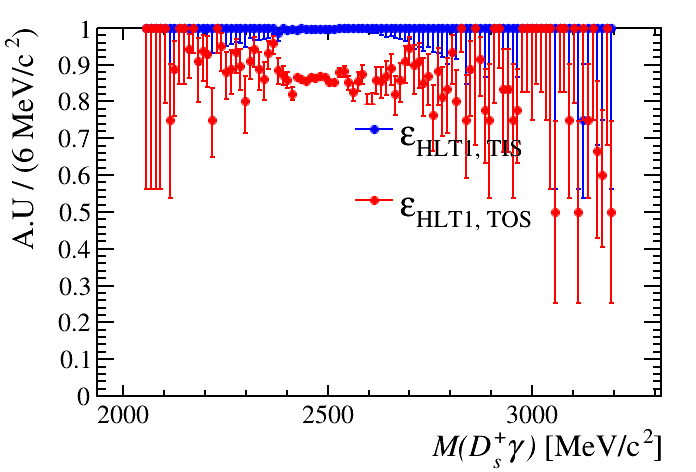

In [37]:
c1 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_data_hlt1_tis, ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_data_hlt1_tos, ROOT.kRed,  "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c1.Draw()
if run2:
    c1.SaveAs(f"./plots/Exp_Run2_hlt1_eff_vs_Dsg_mass.pdf")
else:
    c1.SaveAs(f"./plots/Exp_{pol}{year}_hlt1_eff_vs_Dsg_mass.pdf")
    
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_MC_hlt1_tis, ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_MC_hlt1_tos, ROOT.kRed,  "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Sim_Dsst_Run2_hlt1_eff_vs_Dsg_mass.pdf")
else:
    c2.SaveAs(f"./plots/Sim_Dsst_{pol}{year}_hlt1_eff_vs_Dsg_mass.pdf") 

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_MC_hlt1_tis, ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_MC_hlt1_tos, ROOT.kRed,  "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Sim_Ds1_Run2_hlt1_eff_vs_Dsg_mass.pdf")
else:
    c3.SaveAs(f"./plots/Sim_Ds1_{pol}{year}_hlt1_eff_vs_Dsg_mass.pdf")

c4 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_sig_hlt1_tis, ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_sig_hlt1_tos, ROOT.kRed,  "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c4.Draw()
if run2:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_Run2_hlt1_eff_vs_Dsg_mass.pdf")
else:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_{pol}{year}_hlt1_eff_vs_Dsg_mass.pdf") 

c5 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_sig_hlt1_tis, ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_sig_hlt1_tos, ROOT.kRed, "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c5.Draw()
if run2:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_Run2_hlt1_eff_vs_Dsg_mass.pdf")
else:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_{pol}{year}_hlt1_eff_vs_Dsg_mass.pdf")

##### nVeloTracks binning

In [38]:
nVelo_bins = [[nVelo_intervals[i-1], nVelo_intervals[i]] for i in range(1, len(nVelo_intervals))]

tdf_data_sel_hlt1_tis_nVelo = [tdf_data_sel_hlt1_tis.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                             for bins in nVelo_bins] 
tdf_data_sel_hlt1_tos_nVelo = [tdf_data_sel_hlt1_tos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                             for bins in nVelo_bins] 
tdf_data_sel_hlt1_tistos_nVelo = [tdf_data_sel_hlt1_tistos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                                for bins in nVelo_bins] 


In [39]:
eff_data_hlt1_tis_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[0]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_hlt1_tis_nVelo, tdf_data_sel_hlt1_tos_nVelo, tdf_data_sel_hlt1_tistos_nVelo)]

eff_data_hlt1_tos_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[1]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_hlt1_tis_nVelo, tdf_data_sel_hlt1_tos_nVelo, tdf_data_sel_hlt1_tistos_nVelo)]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass_nVelo_1.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass_nVelo_2.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass_nVelo_3.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass_nVelo_4.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_vs_Dsg_mass_nVelo_5.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_tis_vs_Dsg_mass_nVelo_bins.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt1_eff_tos_vs_Dsg_mass_nVelo_bins.pdf has been created


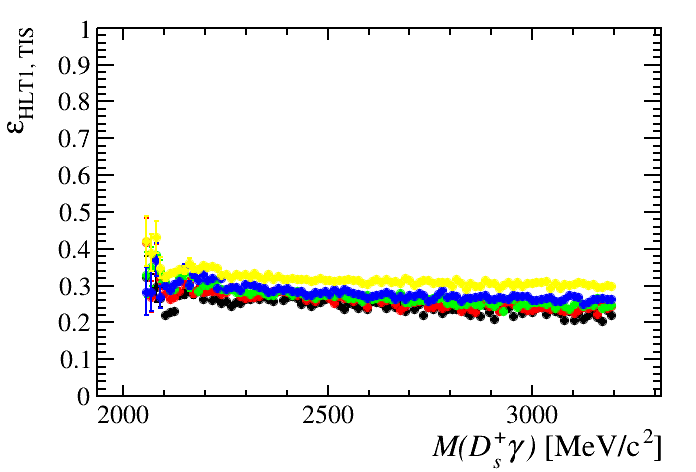

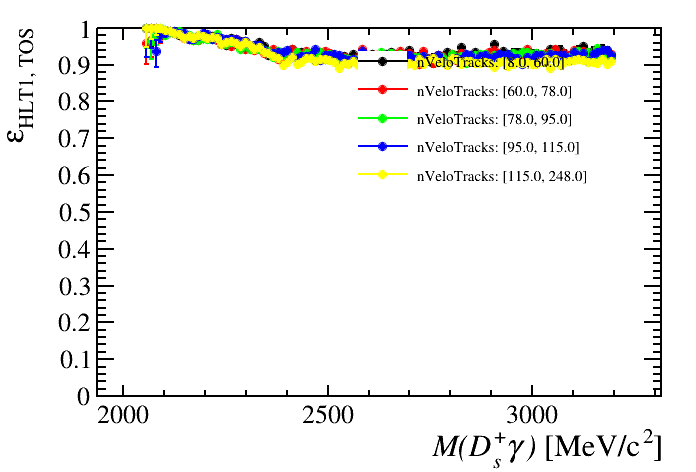

In [40]:
for i in range(len(nVelo_bins)):
    c1 = ROOT.TCanvas()
    lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
    eff_plot(eff_data_hlt1_tis_nVelo[i], ROOT.kBlue, "#varepsilon_{HLT1, TIS}", Dsg_mass_label, ylabel, lgd)
    eff_plot(eff_data_hlt1_tos_nVelo[i], ROOT.kRed, "#varepsilon_{HLT1, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
    lgd.Draw()
    #c1.Draw()
    if run2:
        c1.SaveAs(f"./plots/Exp_Run2_hlt1_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
    else:
        c1.SaveAs(f"./plots/Exp_{pol}{year}_hlt1_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
        
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.6, 0.9, 0.9)
i = 0
for eff, bin in zip(eff_data_hlt1_tis_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT1, TIS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT1, TIS}", lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Exp_Run2_hlt1_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c2.SaveAs(f"./plots/Exp_{pol}{year}_hlt1_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")  

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.6, 0.9, 0.9)
i = 0 
for eff, bin in zip(eff_data_hlt1_tos_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT1, TOS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT1, TOS}", lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Exp_Run2_hlt1_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c3.SaveAs(f"./plots/Exp_{pol}{year}_hlt1_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")

#### TIS and TOS efficiency as function of nVeloTracks

In [28]:
df_data_sel_hlt1_tis = pd.DataFrame(tdf_data_sel_hlt1_tis.AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_data_sel_hlt1_tistos = pd.DataFrame(tdf_data_sel_hlt1_tistos.AsNumpy(columns=["DsgM", "nVeloTracks"]))

### Dsst mass
df_data_Dsst_sel_hlt1_tis    = df_data_sel_hlt1_tis.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")
df_data_Dsst_sel_hlt1_tistos = df_data_sel_hlt1_tistos.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")

### Ds1 mass
df_data_Ds1_sel_hlt1_tis    = df_data_sel_hlt1_tis.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")
df_data_Ds1_sel_hlt1_tistos = df_data_sel_hlt1_tistos.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")

In [29]:
Ds1_mass_cut  = f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}"
Dsst_mass_cut = f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}"

df_Ds1_MC_sel_hlt1_tis =  pd.DataFrame(tdf_Ds1_MC_sel_hlt1_tis.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_MC_sel_hlt1_tistos = pd.DataFrame(tdf_Ds1_MC_sel_hlt1_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_MC_sel_hlt1_tis =  pd.DataFrame(tdf_Dsst_MC_sel_hlt1_tis.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_MC_sel_hlt1_tistos = pd.DataFrame(tdf_Dsst_MC_sel_hlt1_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

In [30]:
df_Ds1_sig_sel_hlt1_tis =  pd.DataFrame(tdf_Ds1_sig_sel_hlt1_tis.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_sig_sel_hlt1_tistos = pd.DataFrame(tdf_Ds1_sig_sel_hlt1_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_sig_sel_hlt1_tis =  pd.DataFrame(tdf_Dsst_sig_sel_hlt1_tis.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_sig_sel_hlt1_tistos = pd.DataFrame(tdf_Dsst_sig_sel_hlt1_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

##### nVeloTracks integrated

In [33]:
mNDsst_data_sel_hlt1_tis = len(df_data_Dsst_sel_hlt1_tis["DsgM"]); uNDsst_data_sel_hlt1_tis = np.sqrt(mNDsst_data_sel_hlt1_tis)
mNDsst_data_sel_hlt1_tistos = len(df_data_Dsst_sel_hlt1_tistos["DsgM"]); uNDsst_data_sel_hlt1_tistos = np.sqrt(mNDsst_data_sel_hlt1_tistos)

NDsst_data_sel_hlt1_tis    = un.ufloat(mNDsst_data_sel_hlt1_tis, uNDsst_data_sel_hlt1_tis)
NDsst_data_sel_hlt1_tistos = un.ufloat(mNDsst_data_sel_hlt1_tistos, uNDsst_data_sel_hlt1_tistos)

eff_data_hlt1_tos_Dsst = NDsst_data_sel_hlt1_tistos / NDsst_data_sel_hlt1_tis

print(f"HLT1 TOS eff for Dsst mass in data = {eff_data_hlt1_tos_Dsst}")

mNDs1_data_sel_hlt1_tis = len(df_data_Ds1_sel_hlt1_tis["DsgM"]); uNDs1_data_sel_hlt1_tis = np.sqrt(mNDs1_data_sel_hlt1_tis)
mNDs1_data_sel_hlt1_tistos = len(df_data_Ds1_sel_hlt1_tistos["DsgM"]); uNDs1_data_sel_hlt1_tistos = np.sqrt(mNDs1_data_sel_hlt1_tistos)

NDs1_data_sel_hlt1_tis    = un.ufloat(mNDs1_data_sel_hlt1_tis, uNDs1_data_sel_hlt1_tis)
NDs1_data_sel_hlt1_tistos = un.ufloat(mNDs1_data_sel_hlt1_tistos, uNDs1_data_sel_hlt1_tistos)

eff_data_hlt1_tos_Ds1 = NDs1_data_sel_hlt1_tistos / NDs1_data_sel_hlt1_tis

print(f"HLT1 TOS eff for Ds1 mass in data = {eff_data_hlt1_tos_Ds1}")

HLT1 TOS eff for Dsst mass in data = 0.978+/-0.006
HLT1 TOS eff for Ds1 mass in data = 0.920+/-0.004


In [34]:
mNDsst_MC_sel_hlt1_tis = len(df_Dsst_MC_sel_hlt1_tis["DsgM"]); uNDsst_MC_sel_hlt1_tis = np.sqrt(mNDsst_MC_sel_hlt1_tis)
mNDsst_MC_sel_hlt1_tistos = len(df_Dsst_MC_sel_hlt1_tistos["DsgM"]); uNDsst_MC_sel_hlt1_tistos = np.sqrt(mNDsst_MC_sel_hlt1_tistos)

NDsst_MC_sel_hlt1_tis    = un.ufloat(mNDsst_MC_sel_hlt1_tis, uNDsst_MC_sel_hlt1_tis)
NDsst_MC_sel_hlt1_tistos = un.ufloat(mNDsst_MC_sel_hlt1_tistos, uNDsst_MC_sel_hlt1_tistos)

eff_MC_hlt1_tos_Dsst = NDsst_MC_sel_hlt1_tistos / NDsst_MC_sel_hlt1_tis

print(f"HLT1 TOS eff for Dsst mass in not truth-matched MC = {eff_MC_hlt1_tos_Dsst}")

mNDs1_MC_sel_hlt1_tis = len(df_Ds1_MC_sel_hlt1_tis["DsgM"]); uNDs1_MC_sel_hlt1_tis = np.sqrt(mNDs1_MC_sel_hlt1_tis)
mNDs1_MC_sel_hlt1_tistos = len(df_Ds1_MC_sel_hlt1_tistos["DsgM"]); uNDs1_MC_sel_hlt1_tistos = np.sqrt(mNDs1_MC_sel_hlt1_tistos)

NDs1_MC_sel_hlt1_tis    = un.ufloat(mNDs1_MC_sel_hlt1_tis, uNDs1_MC_sel_hlt1_tis)
NDs1_MC_sel_hlt1_tistos = un.ufloat(mNDs1_MC_sel_hlt1_tistos, uNDs1_MC_sel_hlt1_tistos)

eff_MC_hlt1_tos_Ds1 = NDs1_MC_sel_hlt1_tistos / NDs1_MC_sel_hlt1_tis

print(f"HLT1 TOS eff for Ds1 mass in not truth-matched MC = {eff_MC_hlt1_tos_Ds1}")

HLT1 TOS eff for Dsst mass in not truth-matched MC = 0.951+/-0.024
HLT1 TOS eff for Ds1 mass in not truth-matched MC = 0.857+/-0.006


In [36]:
mNDsst_sig_sel_hlt1_tis = len(df_Dsst_sig_sel_hlt1_tis["DsgM"]); uNDsst_sig_sel_hlt1_tis = np.sqrt(mNDsst_sig_sel_hlt1_tis)
mNDsst_sig_sel_hlt1_tistos = len(df_Dsst_sig_sel_hlt1_tistos["DsgM"]); uNDsst_sig_sel_hlt1_tistos = np.sqrt(mNDsst_sig_sel_hlt1_tistos)

NDsst_sig_sel_hlt1_tis    = un.ufloat(mNDsst_sig_sel_hlt1_tis, uNDsst_sig_sel_hlt1_tis)
NDsst_sig_sel_hlt1_tistos = un.ufloat(mNDsst_sig_sel_hlt1_tistos, uNDsst_sig_sel_hlt1_tistos)

eff_sig_hlt1_tos_Dsst = NDsst_sig_sel_hlt1_tistos / NDsst_sig_sel_hlt1_tis

print(f"HLT1 TOS eff for Dsst mass in truth-matched MC = {eff_sig_hlt1_tos_Dsst}")

mNDs1_sig_sel_hlt1_tis = len(df_Ds1_sig_sel_hlt1_tis["DsgM"]); uNDs1_sig_sel_hlt1_tis = np.sqrt(mNDs1_sig_sel_hlt1_tis)
mNDs1_sig_sel_hlt1_tistos = len(df_Ds1_sig_sel_hlt1_tistos["DsgM"]); uNDs1_sig_sel_hlt1_tistos = np.sqrt(mNDs1_sig_sel_hlt1_tistos)

NDs1_sig_sel_hlt1_tis    = un.ufloat(mNDs1_sig_sel_hlt1_tis, uNDs1_sig_sel_hlt1_tis)
NDs1_sig_sel_hlt1_tistos = un.ufloat(mNDs1_sig_sel_hlt1_tistos, uNDs1_sig_sel_hlt1_tistos)

eff_sig_hlt1_tos_Ds1 = NDs1_sig_sel_hlt1_tistos / NDs1_sig_sel_hlt1_tis

print(f"L0 TIS eff for Ds1 mass in truth-matched MC = {eff_sig_hlt1_tos_Ds1}")

HLT1 TOS eff for Dsst mass in truth-matched MC = 0.959+/-0.031
L0 TIS eff for Ds1 mass in truth-matched MC = 0.863+/-0.006


##### nVeloTracks binning

data

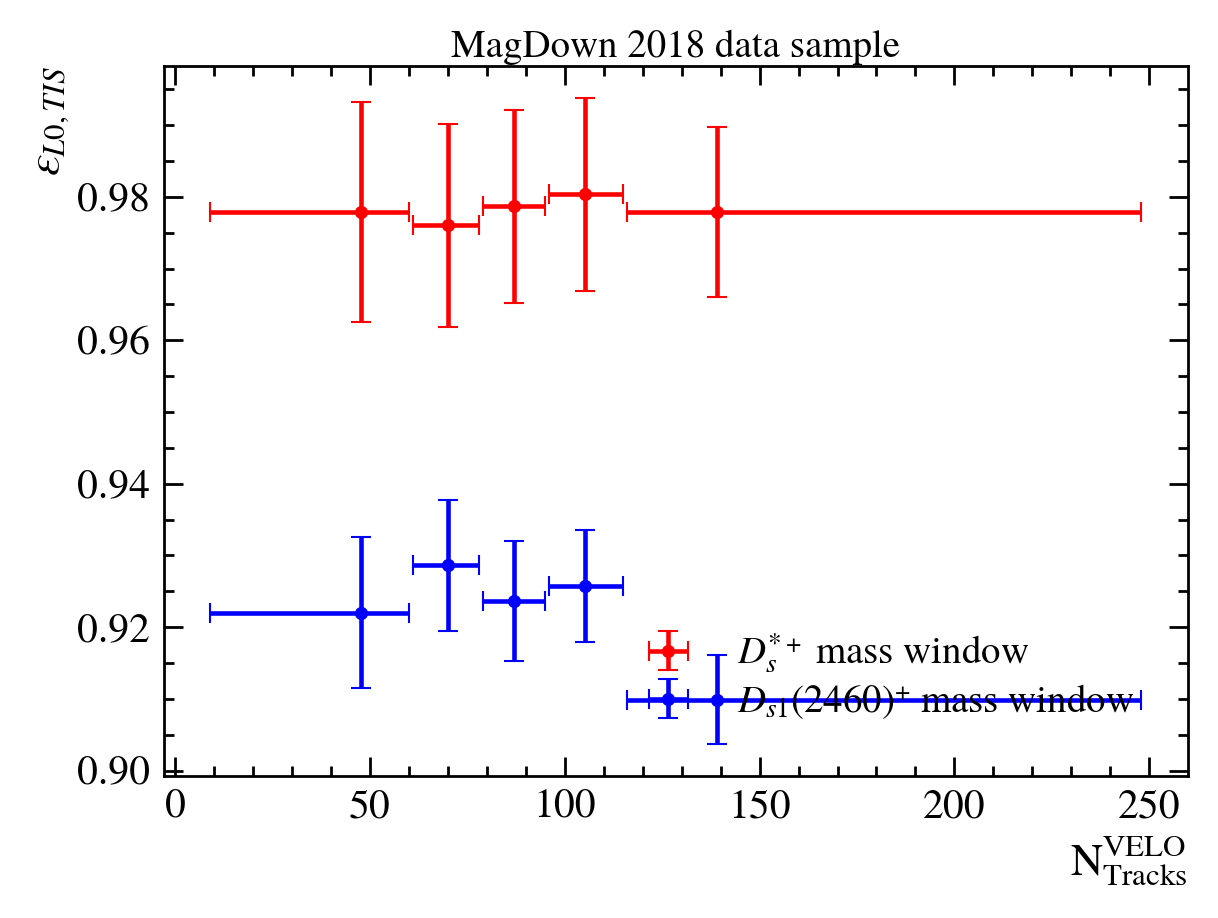

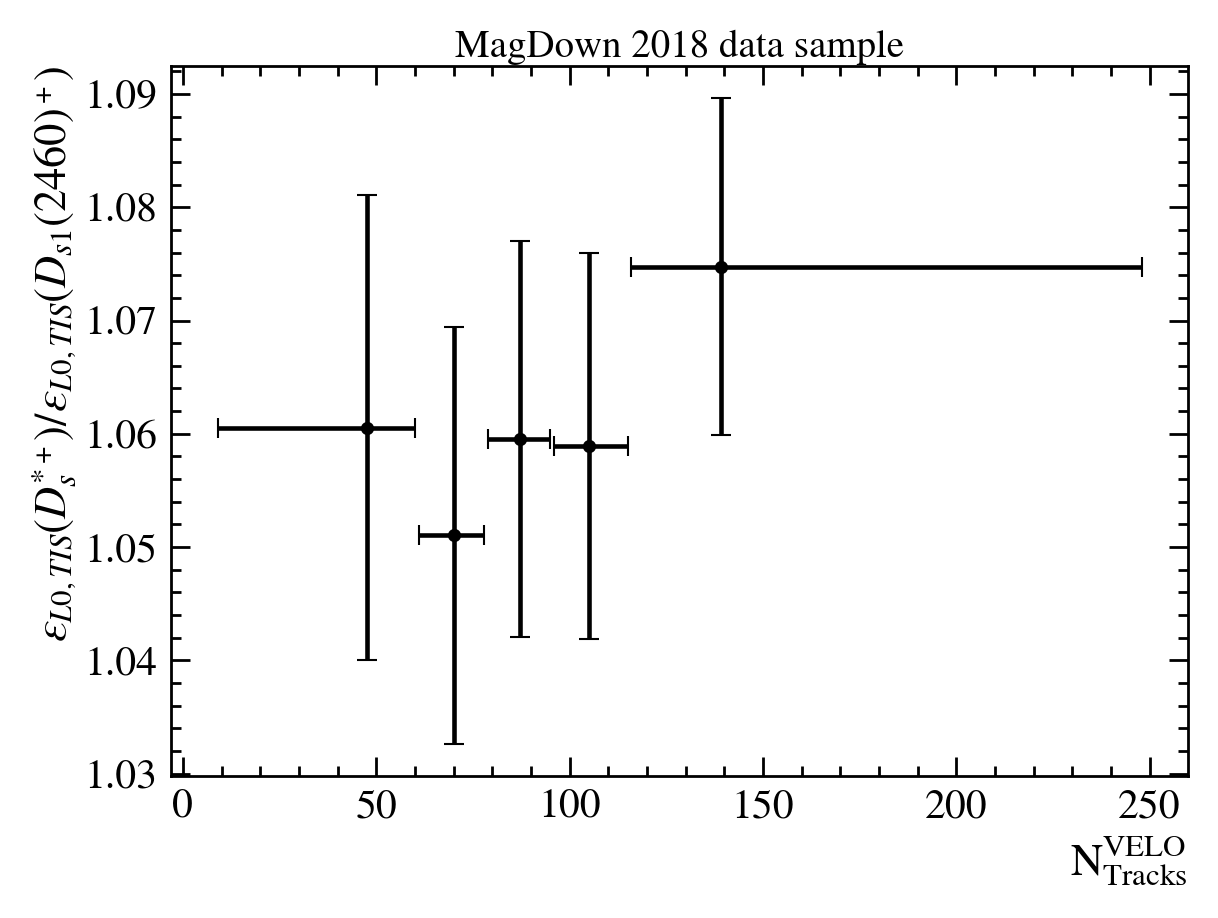

In [37]:
### Dsst mass
mN_data_nVelo_Dsst_sel_hlt1_tis, nVelo_bins    = np.histogram(df_data_Dsst_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Dsst_sel_hlt1_tistos, nVelo_bins = np.histogram(df_data_Dsst_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Dsst_sel_hlt1_tis = np.sqrt(mN_data_nVelo_Dsst_sel_hlt1_tis)
uN_data_nVelo_Dsst_sel_hlt1_tistos = np.sqrt(mN_data_nVelo_Dsst_sel_hlt1_tistos)

N_data_nVelo_Dsst_sel_hlt1_tis  = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_hlt1_tis, uN_data_nVelo_Dsst_sel_hlt1_tis)])
N_data_nVelo_Dsst_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_hlt1_tistos, uN_data_nVelo_Dsst_sel_hlt1_tistos)])

eff_data_hlt1_tos_nVelo_Dsst  = N_data_nVelo_Dsst_sel_hlt1_tistos / N_data_nVelo_Dsst_sel_hlt1_tis

meff_data_hlt1_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_data_hlt1_tos_nVelo_Dsst])
ueff_data_hlt1_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_data_hlt1_tos_nVelo_Dsst])

### Ds1 mass
mN_data_nVelo_Ds1_sel_hlt1_tis, nVelo_bins    = np.histogram(df_data_Ds1_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Ds1_sel_hlt1_tistos, nVelo_bins = np.histogram(df_data_Ds1_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Ds1_sel_hlt1_tis    = np.sqrt(mN_data_nVelo_Ds1_sel_hlt1_tis)
uN_data_nVelo_Ds1_sel_hlt1_tistos = np.sqrt(mN_data_nVelo_Ds1_sel_hlt1_tistos)

N_data_nVelo_Ds1_sel_hlt1_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_hlt1_tis, uN_data_nVelo_Ds1_sel_hlt1_tis)])
N_data_nVelo_Ds1_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_hlt1_tistos, uN_data_nVelo_Ds1_sel_hlt1_tistos)])

eff_data_hlt1_tos_nVelo_Ds1  = N_data_nVelo_Ds1_sel_hlt1_tistos / N_data_nVelo_Ds1_sel_hlt1_tis

meff_data_hlt1_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_data_hlt1_tos_nVelo_Ds1])
ueff_data_hlt1_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_data_hlt1_tos_nVelo_Ds1])

### ratio
eff_data_hlt1_tos_nVelo_ratio  = eff_data_hlt1_tos_nVelo_Dsst / eff_data_hlt1_tos_nVelo_Ds1
meff_data_hlt1_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_data_hlt1_tos_nVelo_ratio])
ueff_data_hlt1_tos_nVelo_ratio = np.array([r.std_dev for r in eff_data_hlt1_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_Dsst, ueff_data_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_Ds1, ueff_data_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_ratio, ueff_data_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Not matched MC

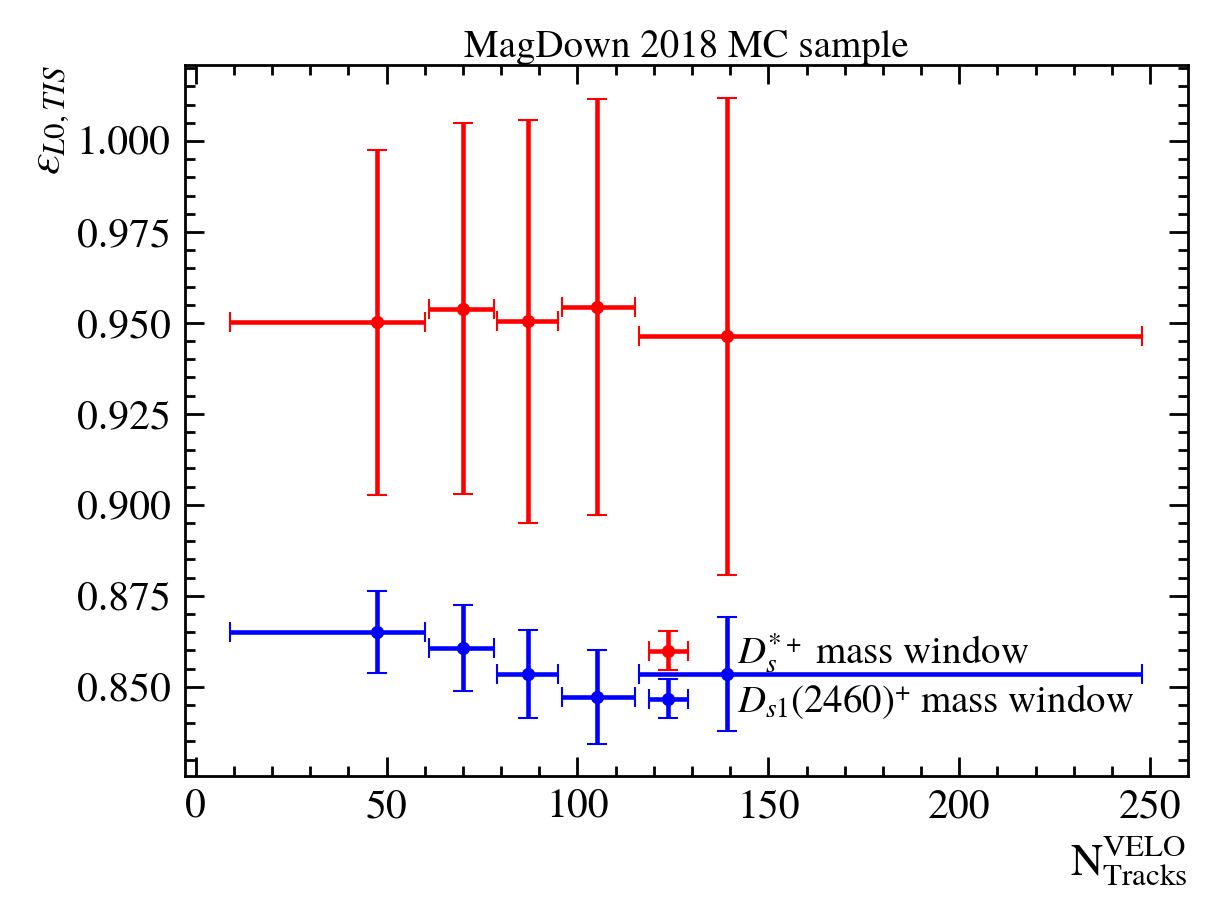

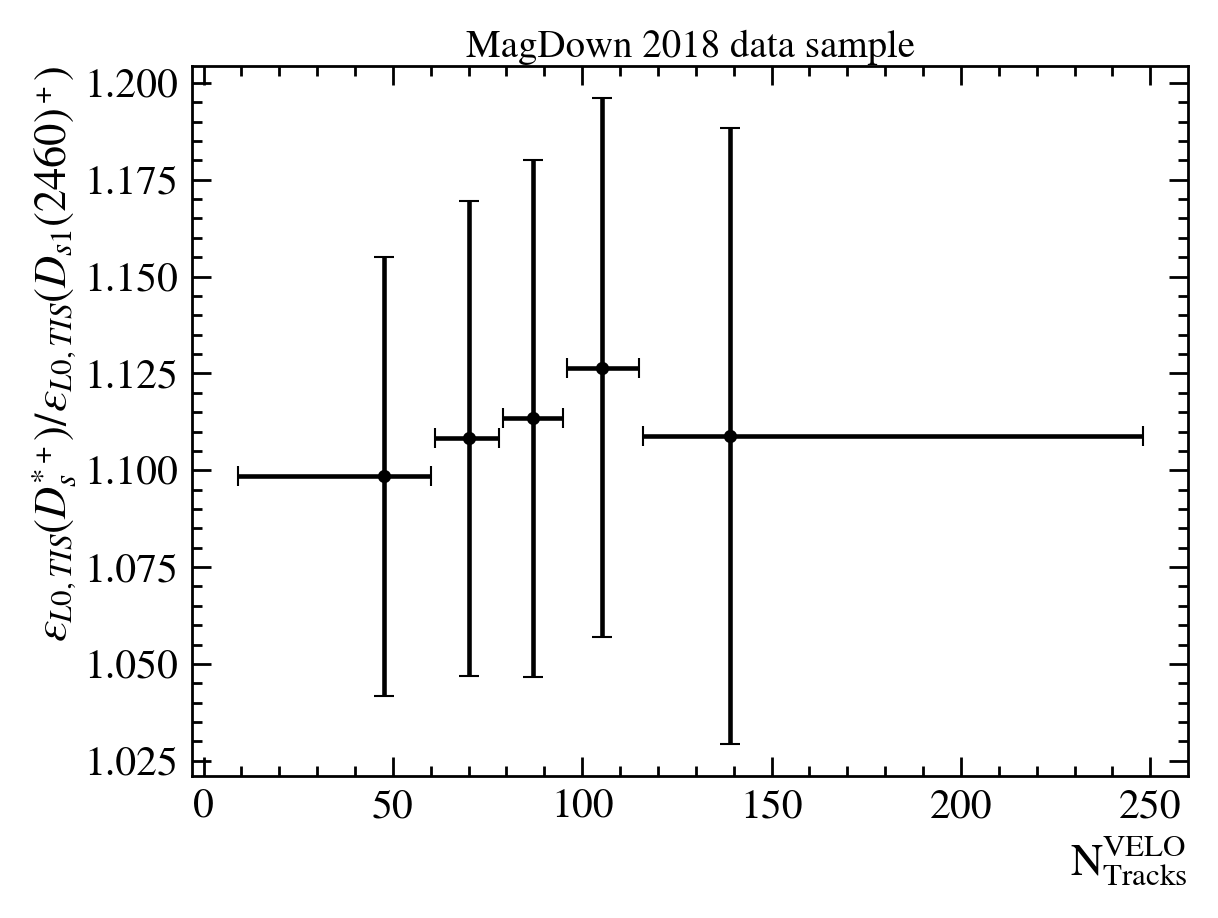

In [39]:
### Dsst mass
mN_mc_nVelo_Dsst_sel_hlt1_tis, nVelo_bins    = np.histogram(df_Dsst_MC_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Dsst_sel_hlt1_tistos, nVelo_bins = np.histogram(df_Dsst_MC_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Dsst_sel_hlt1_tis = np.sqrt(mN_mc_nVelo_Dsst_sel_hlt1_tis)
uN_mc_nVelo_Dsst_sel_hlt1_tistos = np.sqrt(mN_mc_nVelo_Dsst_sel_hlt1_tistos)

N_mc_nVelo_Dsst_sel_hlt1_tis  = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_hlt1_tis, uN_mc_nVelo_Dsst_sel_hlt1_tis)])
N_mc_nVelo_Dsst_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_hlt1_tistos, uN_mc_nVelo_Dsst_sel_hlt1_tistos)])

eff_mc_hlt1_tos_nVelo_Dsst  = N_mc_nVelo_Dsst_sel_hlt1_tistos / N_mc_nVelo_Dsst_sel_hlt1_tis

meff_mc_hlt1_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_mc_hlt1_tos_nVelo_Dsst])
ueff_mc_hlt1_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_mc_hlt1_tos_nVelo_Dsst])

### Ds1 mass
mN_mc_nVelo_Ds1_sel_hlt1_tis, nVelo_bins    = np.histogram(df_Ds1_MC_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Ds1_sel_hlt1_tistos, nVelo_bins = np.histogram(df_Ds1_MC_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Ds1_sel_hlt1_tis    = np.sqrt(mN_mc_nVelo_Ds1_sel_hlt1_tis)
uN_mc_nVelo_Ds1_sel_hlt1_tistos = np.sqrt(mN_mc_nVelo_Ds1_sel_hlt1_tistos)

N_mc_nVelo_Ds1_sel_hlt1_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_hlt1_tis, uN_mc_nVelo_Ds1_sel_hlt1_tis)])
N_mc_nVelo_Ds1_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_hlt1_tistos, uN_mc_nVelo_Ds1_sel_hlt1_tistos)])

eff_mc_hlt1_tos_nVelo_Ds1  = N_mc_nVelo_Ds1_sel_hlt1_tistos / N_mc_nVelo_Ds1_sel_hlt1_tis

meff_mc_hlt1_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_mc_hlt1_tos_nVelo_Ds1])
ueff_mc_hlt1_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_mc_hlt1_tos_nVelo_Ds1])

### ratio
eff_mc_hlt1_tos_nVelo_ratio  = eff_mc_hlt1_tos_nVelo_Dsst / eff_mc_hlt1_tos_nVelo_Ds1
meff_mc_hlt1_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_mc_hlt1_tos_nVelo_ratio])
ueff_mc_hlt1_tos_nVelo_ratio = np.array([r.std_dev for r in eff_mc_hlt1_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_Dsst, ueff_mc_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_Ds1, ueff_mc_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_ratio, ueff_mc_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Matched MC

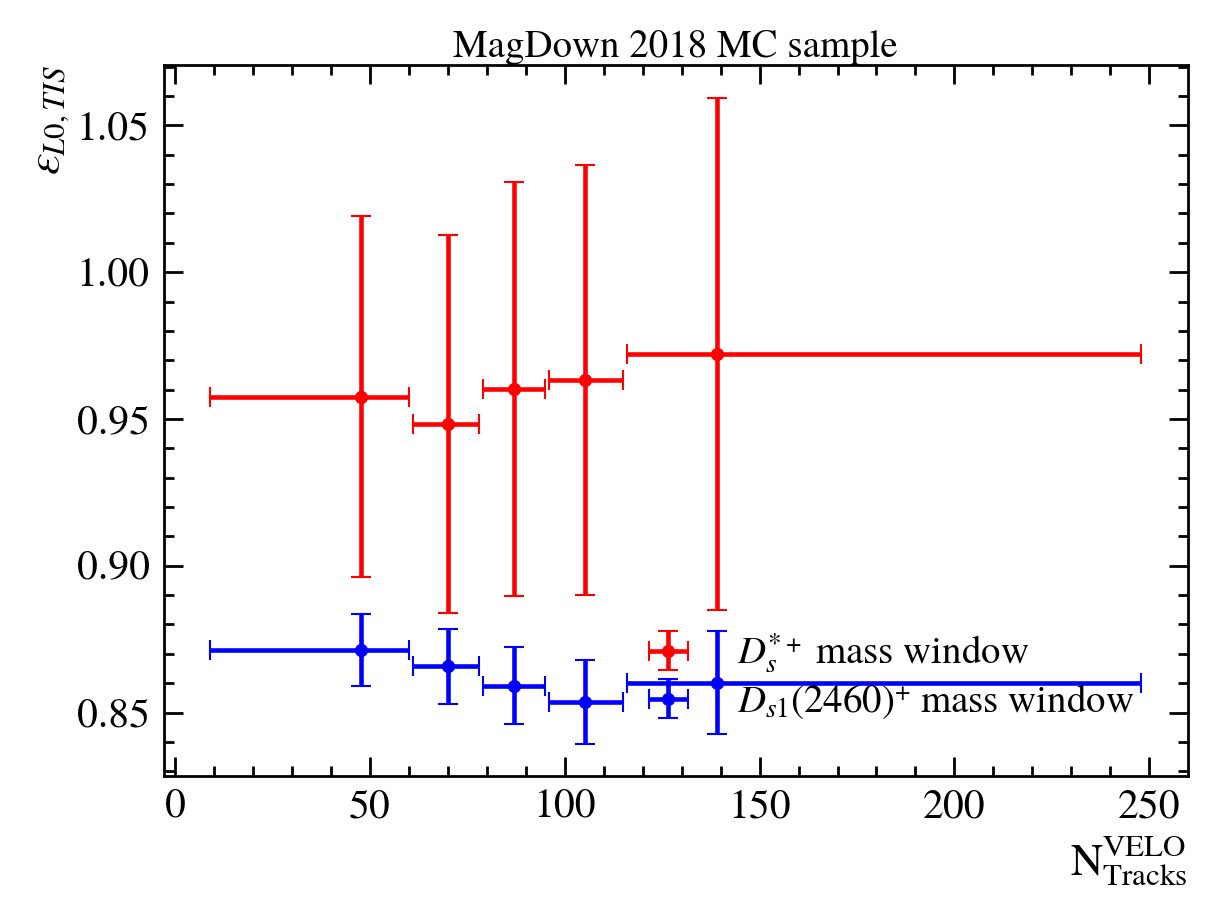

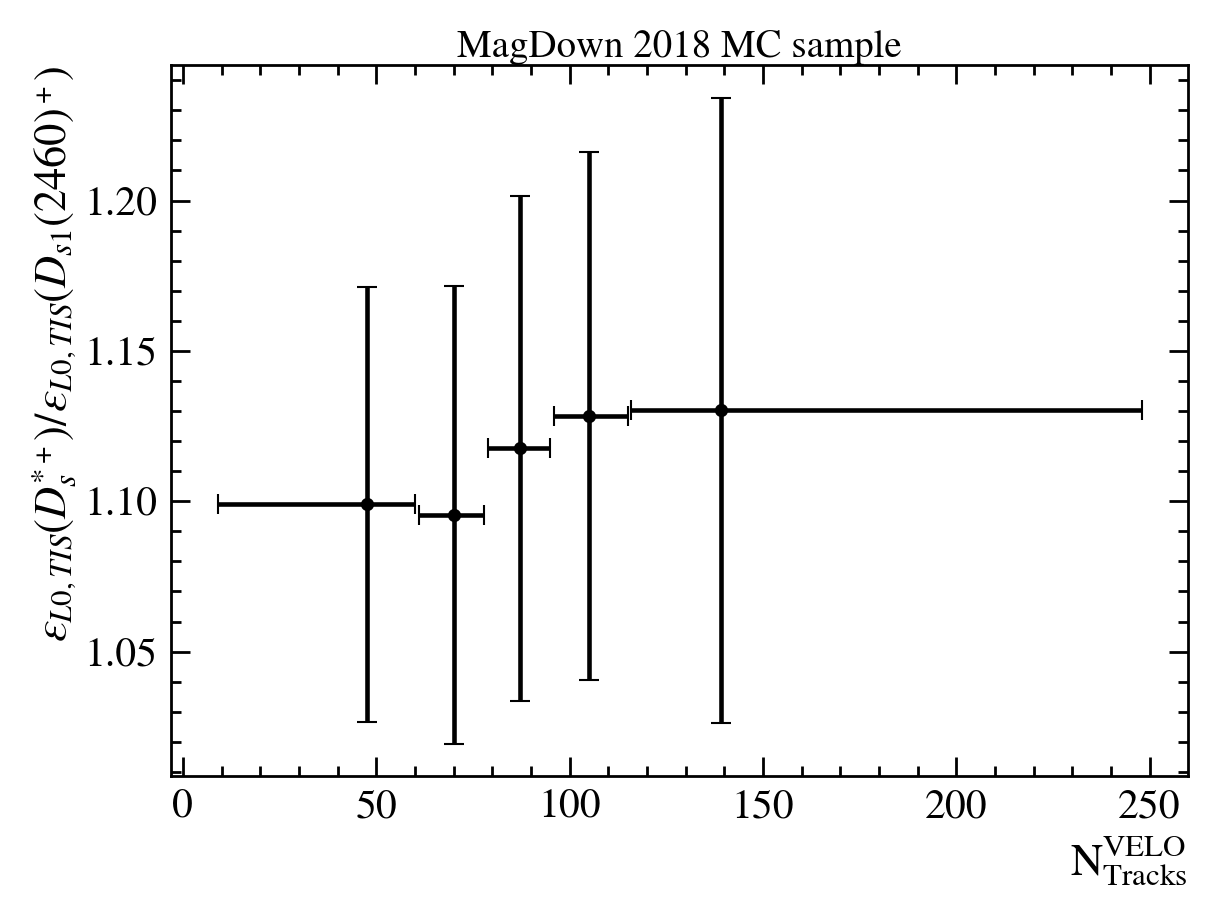

In [41]:
### Dsst mass
mN_sig_nVelo_Dsst_sel_hlt1_tis, nVelo_bins    = np.histogram(df_Dsst_sig_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Dsst_sel_hlt1_tistos, nVelo_bins = np.histogram(df_Dsst_sig_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Dsst_sel_hlt1_tis = np.sqrt(mN_sig_nVelo_Dsst_sel_hlt1_tis)
uN_sig_nVelo_Dsst_sel_hlt1_tistos = np.sqrt(mN_sig_nVelo_Dsst_sel_hlt1_tistos)

N_sig_nVelo_Dsst_sel_hlt1_tis    = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_hlt1_tis, uN_sig_nVelo_Dsst_sel_hlt1_tis)])
N_sig_nVelo_Dsst_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_hlt1_tistos, uN_sig_nVelo_Dsst_sel_hlt1_tistos)])

eff_sig_hlt1_tos_nVelo_Dsst  = N_sig_nVelo_Dsst_sel_hlt1_tistos / N_sig_nVelo_Dsst_sel_hlt1_tis

meff_sig_hlt1_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_sig_hlt1_tos_nVelo_Dsst])
ueff_sig_hlt1_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_sig_hlt1_tos_nVelo_Dsst])

### Ds1 mass
mN_sig_nVelo_Ds1_sel_hlt1_tis, nVelo_bins    = np.histogram(df_Ds1_sig_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Ds1_sel_hlt1_tistos, nVelo_bins = np.histogram(df_Ds1_sig_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Ds1_sel_hlt1_tis    = np.sqrt(mN_sig_nVelo_Ds1_sel_hlt1_tis)
uN_sig_nVelo_Ds1_sel_hlt1_tistos = np.sqrt(mN_sig_nVelo_Ds1_sel_hlt1_tistos)

N_sig_nVelo_Ds1_sel_hlt1_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_hlt1_tis, uN_sig_nVelo_Ds1_sel_hlt1_tis)])
N_sig_nVelo_Ds1_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_hlt1_tistos, uN_sig_nVelo_Ds1_sel_hlt1_tistos)])

eff_sig_hlt1_tos_nVelo_Ds1  = N_sig_nVelo_Ds1_sel_hlt1_tistos / N_sig_nVelo_Ds1_sel_hlt1_tis

meff_sig_hlt1_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_sig_hlt1_tos_nVelo_Ds1])
ueff_sig_hlt1_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_sig_hlt1_tos_nVelo_Ds1])

### ratio
eff_sig_hlt1_tos_nVelo_ratio  = eff_sig_hlt1_tos_nVelo_Dsst / eff_sig_hlt1_tos_nVelo_Ds1
meff_sig_hlt1_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_sig_hlt1_tos_nVelo_ratio])
ueff_sig_hlt1_tos_nVelo_ratio = np.array([r.std_dev for r in eff_sig_hlt1_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_Dsst, ueff_sig_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_Ds1, ueff_sig_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_ratio, ueff_sig_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} MC sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Comparision data and MC

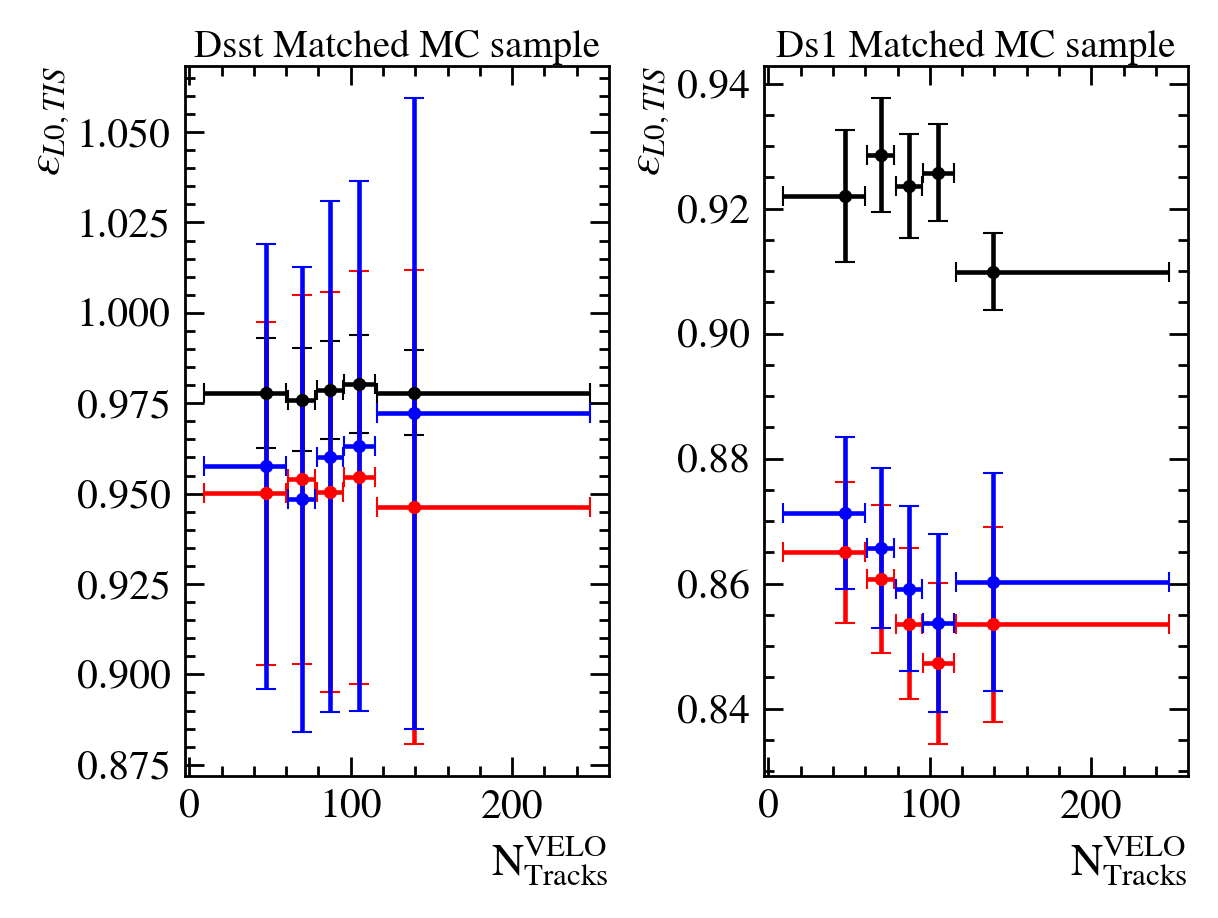

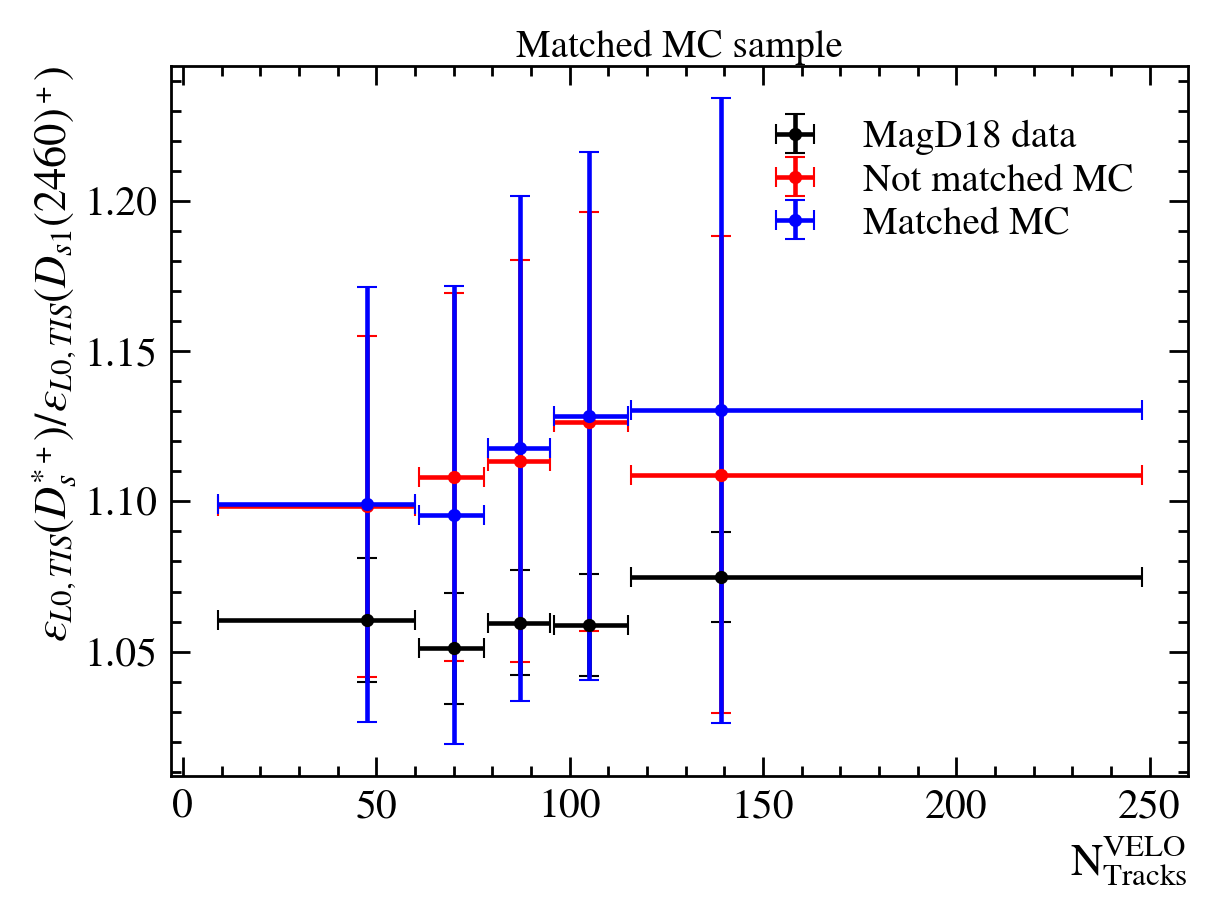

In [44]:
plt.figure(1)
plt.subplot(121)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_Dsst, ueff_data_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_Dsst, ueff_mc_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_Dsst, ueff_sig_hlt1_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Dsst Matched MC sample")
#plt.legend(loc='lower right')
plt.subplot(122)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_Ds1, ueff_data_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_Ds1, ueff_mc_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_Ds1, ueff_sig_hlt1_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Ds1 Matched MC sample")
plt.savefig(f"./plots/Comp_eff_hlt1_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')


plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_ratio, ueff_data_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label="MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt1_tos_nVelo_ratio, ueff_mc_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label="Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt1_tos_nVelo_ratio, ueff_sig_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label="Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"Matched MC sample")
plt.legend()
plt.savefig(f"./plots/Comp_eff_hlt1_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

#### No signal mas region ratio

In [45]:
hm_cut  = "DsgM > 2700 & DsgM <= 2900"
uhm_cut = "DsgM > 2900"  

In [46]:
### Dsst mass
df_data_hm_sel_hlt1_tis    = df_data_sel_hlt1_tis.query(hm_cut)
df_data_hm_sel_hlt1_tistos = df_data_sel_hlt1_tistos.query(hm_cut)

### Ds1 mass
df_data_uhm_sel_hlt1_tis    = df_data_sel_hlt1_tis.query(uhm_cut)
df_data_uhm_sel_hlt1_tistos = df_data_sel_hlt1_tistos.query(uhm_cut)

##### nVeloTracks integrated

In [47]:
mN_data_hm_sel_hlt1_tis = len(df_data_hm_sel_hlt1_tis["DsgM"]); uN_data_hm_sel_hlt1_tis = np.sqrt(mN_data_hm_sel_hlt1_tis)
mN_data_hm_sel_hlt1_tistos = len(df_data_hm_sel_hlt1_tistos["DsgM"]); uN_data_hm_sel_hlt1_tistos = np.sqrt(mN_data_hm_sel_hlt1_tistos)

N_data_hm_sel_hlt1_tis = un.ufloat(mN_data_hm_sel_hlt1_tis, uN_data_hm_sel_hlt1_tis)
N_data_hm_sel_hlt1_tistos = un.ufloat(mN_data_hm_sel_hlt1_tistos, uN_data_hm_sel_hlt1_tistos)

eff_data_hlt1_tos_hm  = N_data_hm_sel_hlt1_tistos / N_data_hm_sel_hlt1_tis

print(f"HLT1 TOS eff for {hm_cut} mass in data = {eff_data_hlt1_tos_hm}")

mN_data_uhm_sel_hlt1_tis = len(df_data_uhm_sel_hlt1_tis["DsgM"]); uN_data_uhm_sel_hlt1_tis = np.sqrt(mN_data_uhm_sel_hlt1_tis)
mN_data_uhm_sel_hlt1_tistos = len(df_data_uhm_sel_hlt1_tistos["DsgM"]); uN_data_uhm_sel_hlt1_tistos = np.sqrt(mN_data_uhm_sel_hlt1_tistos)

N_data_uhm_sel_hlt1_tis = un.ufloat(mN_data_uhm_sel_hlt1_tis, uN_data_uhm_sel_hlt1_tis)
N_data_uhm_sel_hlt1_tistos = un.ufloat(mN_data_uhm_sel_hlt1_tistos, uN_data_uhm_sel_hlt1_tistos)

eff_data_hlt1_tos_uhm  = N_data_uhm_sel_hlt1_tistos / N_data_uhm_sel_hlt1_tis

print(f"HLT1 TOS eff for {uhm_cut} mass in data = {eff_data_hlt1_tos_uhm}")

HLT1 TOS eff for DsgM > 2700 & DsgM <= 2900 mass in data = 0.916+/-0.004
HLT1 TOS eff for DsgM > 2900 mass in data = 0.9197+/-0.0033


##### nVeloTracks binning

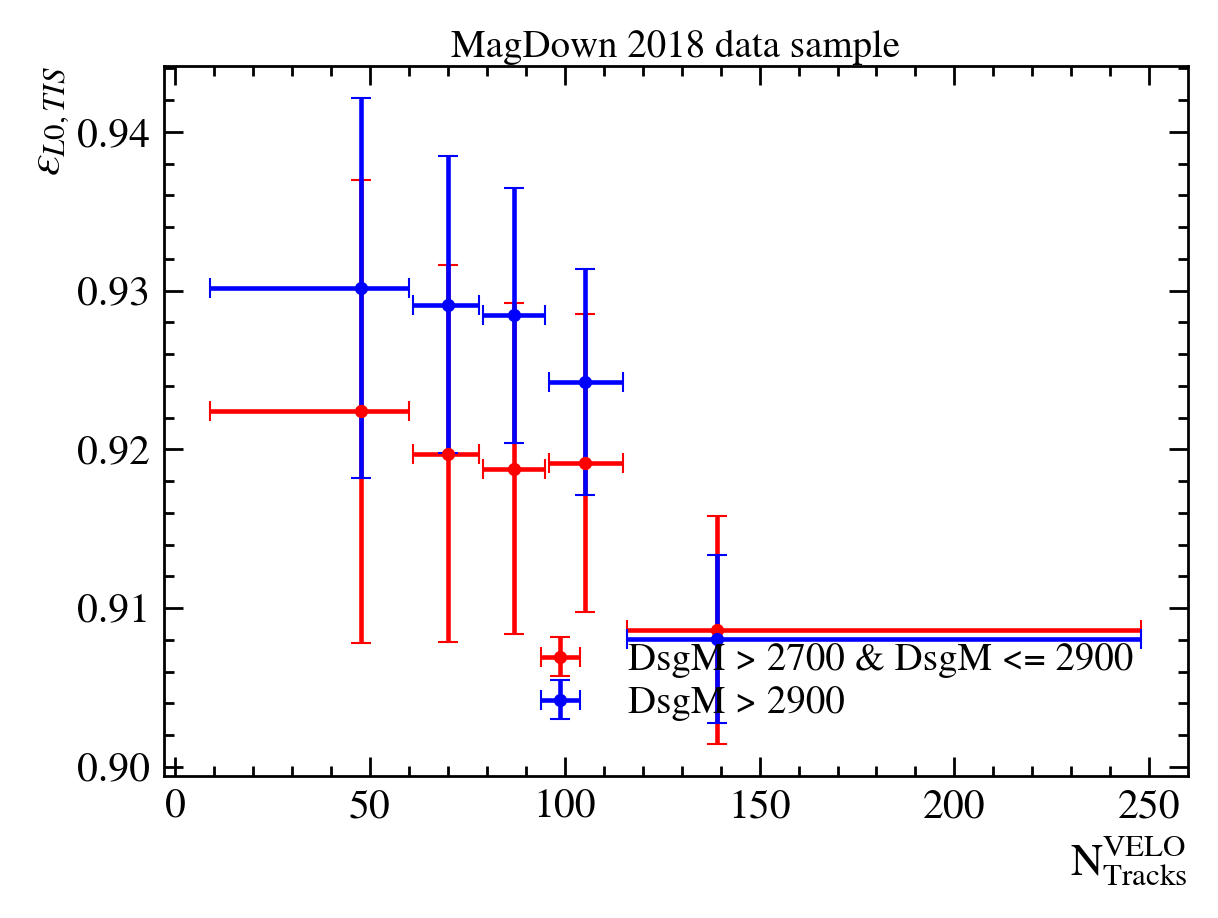

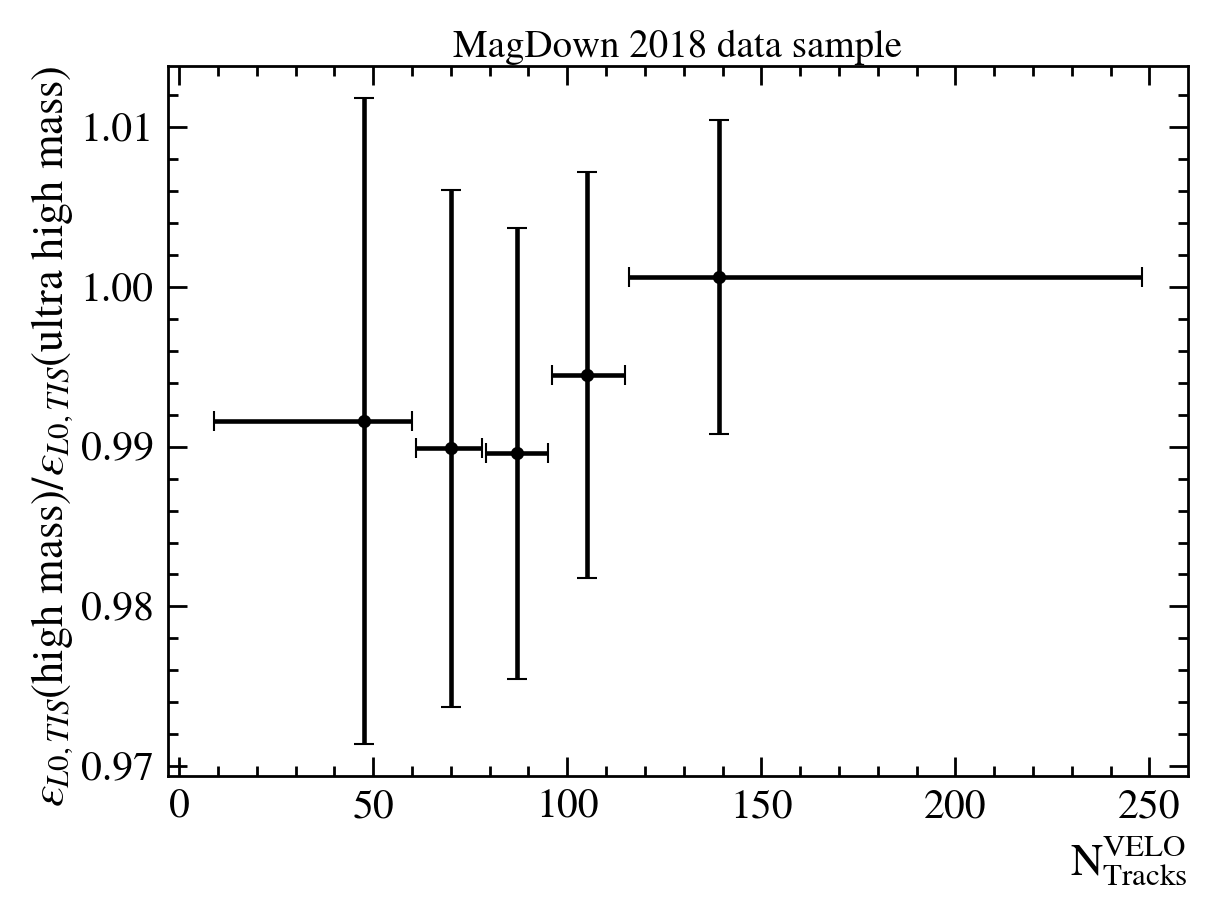

In [48]:
### Dsst mass
mN_data_nVelo_hm_sel_hlt1_tis, nVelo_bins    = np.histogram(df_data_hm_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_hm_sel_hlt1_tistos, nVelo_bins = np.histogram(df_data_hm_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_hm_sel_hlt1_tis = np.sqrt(mN_data_nVelo_hm_sel_hlt1_tis)
uN_data_nVelo_hm_sel_hlt1_tistos = np.sqrt(mN_data_nVelo_hm_sel_hlt1_tistos)

N_data_nVelo_hm_sel_hlt1_tis    = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_hlt1_tis, uN_data_nVelo_hm_sel_hlt1_tis)])
N_data_nVelo_hm_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_hlt1_tistos, uN_data_nVelo_hm_sel_hlt1_tistos)])

eff_data_hlt1_tos_nVelo_hm  = N_data_nVelo_hm_sel_hlt1_tistos / N_data_nVelo_hm_sel_hlt1_tis

meff_data_hlt1_tos_nVelo_hm = np.array([eff.nominal_value for eff in eff_data_hlt1_tos_nVelo_hm])
ueff_data_hlt1_tos_nVelo_hm = np.array([eff.std_dev for eff in eff_data_hlt1_tos_nVelo_hm])

### Ds1 mass
mN_data_nVelo_uhm_sel_hlt1_tis, nVelo_bins    = np.histogram(df_data_uhm_sel_hlt1_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_uhm_sel_hlt1_tistos, nVelo_bins = np.histogram(df_data_uhm_sel_hlt1_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_uhm_sel_hlt1_tis    = np.sqrt(mN_data_nVelo_uhm_sel_hlt1_tis)
uN_data_nVelo_uhm_sel_hlt1_tistos = np.sqrt(mN_data_nVelo_uhm_sel_hlt1_tistos)

N_data_nVelo_uhm_sel_hlt1_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_hlt1_tis, uN_data_nVelo_uhm_sel_hlt1_tis)])
N_data_nVelo_uhm_sel_hlt1_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_hlt1_tistos, uN_data_nVelo_uhm_sel_hlt1_tistos)])

eff_data_hlt1_tos_nVelo_uhm  = N_data_nVelo_uhm_sel_hlt1_tistos / N_data_nVelo_uhm_sel_hlt1_tis

meff_data_hlt1_tos_nVelo_uhm = np.array([eff.nominal_value for eff in eff_data_hlt1_tos_nVelo_uhm])
ueff_data_hlt1_tos_nVelo_uhm = np.array([eff.std_dev for eff in eff_data_hlt1_tos_nVelo_uhm])

### ratio
eff_data_hlt1_tos_nVelo_ratio  = eff_data_hlt1_tos_nVelo_hm / eff_data_hlt1_tos_nVelo_uhm
meff_data_hlt1_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_data_hlt1_tos_nVelo_ratio])
ueff_data_hlt1_tos_nVelo_ratio = np.array([r.std_dev for r in eff_data_hlt1_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_hm, ueff_data_hlt1_tos_nVelo_hm, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=f"{hm_cut}")
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_uhm, ueff_data_hlt1_tos_nVelo_uhm, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=f"{uhm_cut}")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt1_tos_nVelo_ratio, ueff_data_hlt1_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$(high mass)/$\varepsilon_{L0, TIS}$(ultra high mass)")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt1_tos_ratio_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt1_tos_ratio_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')



## HLT2 efficiencies

In [49]:
hlt2_tis = "Ds_Hlt2Phys_TIS"
hlt2_tos = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
hlt2_tistos = f"{hlt2_tis} && {hlt2_tos}"

In [50]:
tdf_Ds1_MC_sel_hlt2_tis = tdf_Ds1_MC_sel_hlt1_tos.Filter(hlt2_tis)
tdf_Ds1_MC_sel_hlt2_tos = tdf_Ds1_MC_sel_hlt1_tos.Filter(hlt2_tos)
tdf_Ds1_MC_sel_hlt2_tistos = tdf_Ds1_MC_sel_hlt1_tos.Filter(hlt2_tistos)

tdf_Dsst_MC_sel_hlt2_tis = tdf_Dsst_MC_sel_hlt1_tos.Filter(hlt2_tis)
tdf_Dsst_MC_sel_hlt2_tos = tdf_Dsst_MC_sel_hlt1_tos.Filter(hlt2_tos)
tdf_Dsst_MC_sel_hlt2_tistos = tdf_Dsst_MC_sel_hlt1_tos.Filter(hlt2_tistos)

tdf_Ds1_sig_sel_hlt2_tis = tdf_Ds1_sig_sel_hlt1_tos.Filter(hlt2_tis)
tdf_Ds1_sig_sel_hlt2_tos = tdf_Ds1_sig_sel_hlt1_tos.Filter(hlt2_tos)
tdf_Ds1_sig_sel_hlt2_tistos = tdf_Ds1_sig_sel_hlt1_tos.Filter(hlt2_tistos)

tdf_Dsst_sig_sel_hlt2_tis = tdf_Dsst_sig_sel_hlt1_tos.Filter(hlt2_tis)
tdf_Dsst_sig_sel_hlt2_tos = tdf_Dsst_sig_sel_hlt1_tos.Filter(hlt2_tos)
tdf_Dsst_sig_sel_hlt2_tistos = tdf_Dsst_sig_sel_hlt1_tos.Filter(hlt2_tistos)

In [51]:
tdf_data_sel_hlt2_tis = tdf_data_sel_hlt1_tos.Filter(hlt2_tis)
tdf_data_sel_hlt2_tos = tdf_data_sel_hlt1_tos.Filter(hlt2_tos)
tdf_data_sel_hlt2_tistos = tdf_data_sel_hlt1_tos.Filter(hlt2_tistos)

##### nVeloTracks integrated

In [57]:
eff_Dsst_MC_hlt2_tis = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_hlt2_tis, tdf_Dsst_MC_sel_hlt2_tos, tdf_Dsst_MC_sel_hlt2_tistos))[0]
eff_Dsst_MC_hlt2_tos = (tistos_effs_vs_mass(tdf_Dsst_MC_sel_hlt2_tis, tdf_Dsst_MC_sel_hlt2_tos, tdf_Dsst_MC_sel_hlt2_tistos))[1]

eff_Ds1_MC_hlt2_tis = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_hlt2_tis, tdf_Ds1_MC_sel_hlt2_tos, tdf_Ds1_MC_sel_hlt2_tistos))[0]
eff_Ds1_MC_hlt2_tos = (tistos_effs_vs_mass(tdf_Ds1_MC_sel_hlt2_tis, tdf_Ds1_MC_sel_hlt2_tos, tdf_Ds1_MC_sel_hlt2_tistos))[1]

eff_Dsst_sig_hlt2_tis = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_hlt2_tis, tdf_Dsst_sig_sel_hlt2_tos, tdf_Dsst_sig_sel_hlt2_tistos))[0]
eff_Dsst_sig_hlt2_tos = (tistos_effs_vs_mass(tdf_Dsst_sig_sel_hlt2_tis, tdf_Dsst_sig_sel_hlt2_tos, tdf_Dsst_sig_sel_hlt2_tistos))[1]

eff_Ds1_sig_hlt2_tis = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_hlt2_tis, tdf_Ds1_sig_sel_hlt2_tos, tdf_Ds1_sig_sel_hlt2_tistos))[0]
eff_Ds1_sig_hlt2_tos = (tistos_effs_vs_mass(tdf_Ds1_sig_sel_hlt2_tis, tdf_Ds1_sig_sel_hlt2_tos, tdf_Ds1_sig_sel_hlt2_tistos))[1]

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 22 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 40 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 22 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 40 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 7 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 7 points have been skip

In [58]:
eff_data_hlt2_tis = (tistos_effs_vs_mass(tdf_data_sel_hlt2_tis, tdf_data_sel_hlt2_tos, tdf_data_sel_hlt2_tistos))[0]
eff_data_hlt2_tos = (tistos_effs_vs_mass(tdf_data_sel_hlt2_tis, tdf_data_sel_hlt2_tos, tdf_data_sel_hlt2_tistos))[1]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt2_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_MagDown2018_hlt2_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_MagDown2018_hlt2_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Dsst_sig_MagDown2018_hlt2_eff_vs_Dsg_mass.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Sim_Ds1_sig_MagDown2018_hlt2_eff_vs_Dsg_mass.pdf has been created


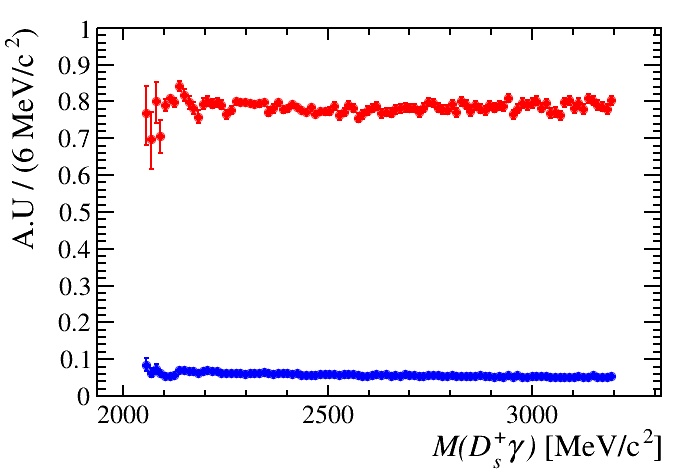

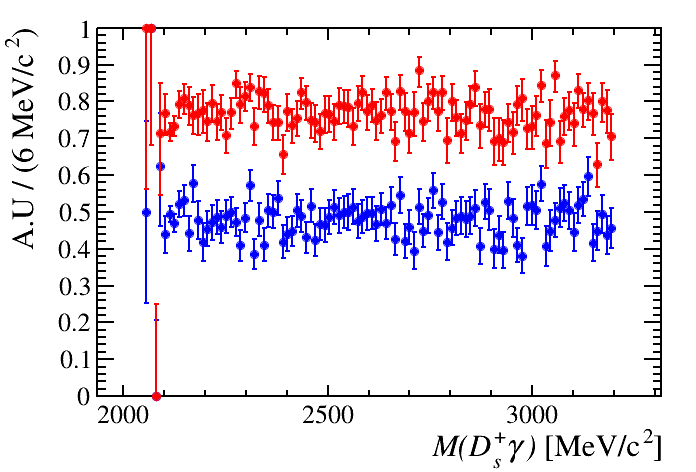

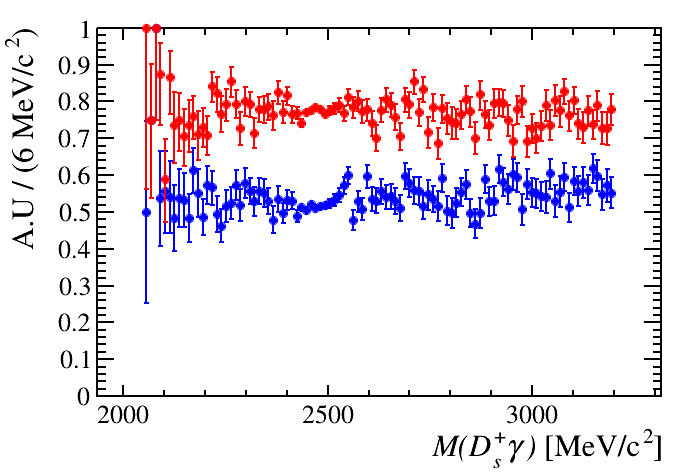

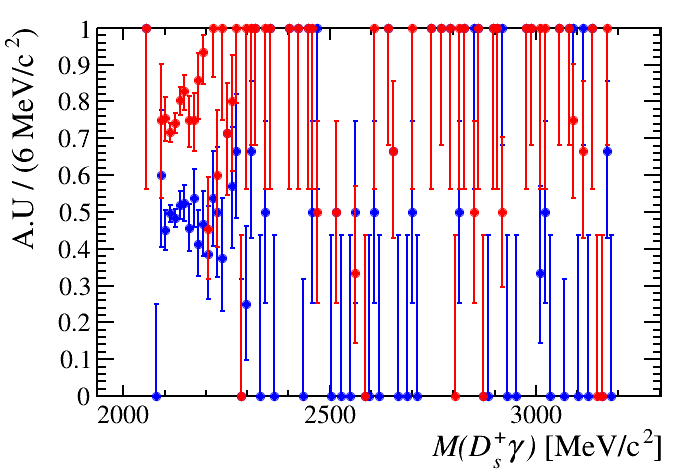

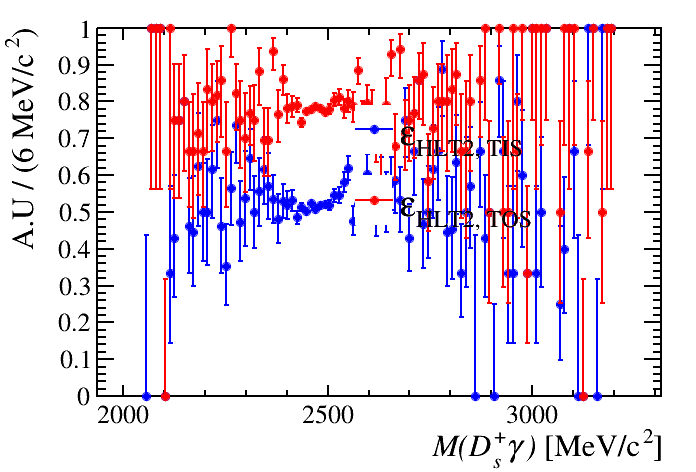

In [59]:
c1 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_data_hlt2_tis, ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_data_hlt2_tos, ROOT.kRed,  "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c1.Draw()
if run2:
    c1.SaveAs(f"./plots/Exp_Run2_hlt2_eff_vs_Dsg_mass.pdf")
else:
    c1.SaveAs(f"./plots/Exp_{pol}{year}_hlt2_eff_vs_Dsg_mass.pdf")
    
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_MC_hlt2_tis, ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_MC_hlt2_tos, ROOT.kRed,  "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Sim_Dsst_Run2_hlt2_eff_vs_Dsg_mass.pdf")
else:
    c2.SaveAs(f"./plots/Sim_Dsst_{pol}{year}_hlt2_eff_vs_Dsg_mass.pdf") 

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_MC_hlt2_tis, ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_MC_hlt2_tos, ROOT.kRed, "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Sim_Ds1_Run2_hlt2_eff_vs_Dsg_mass.pdf")
else:
    c3.SaveAs(f"./plots/Sim_Ds1_{pol}{year}_hlt2_eff_vs_Dsg_mass.pdf")

c4 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Dsst_sig_hlt2_tis, ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Dsst_sig_hlt2_tos, ROOT.kRed,  "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c4.Draw()
if run2:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_Run2_hlt2_eff_vs_Dsg_mass.pdf")
else:
    c4.SaveAs(f"./plots/Sim_Dsst_sig_{pol}{year}_hlt2_eff_vs_Dsg_mass.pdf") 

c5 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
eff_plot(eff_Ds1_sig_hlt2_tis, ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
eff_plot(eff_Ds1_sig_hlt2_tos, ROOT.kRed,  "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
lgd.Draw()
c5.Draw()
if run2:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_Run2_hlt2_eff_vs_Dsg_mass.pdf")
else:
    c5.SaveAs(f"./plots/Sim_Ds1_sig_{pol}{year}_hlt2_eff_vs_Dsg_mass.pdf")

##### nVeloTracks binning

In [60]:
nVelo_bins = [[nVelo_intervals[i-1], nVelo_intervals[i]] for i in range(1, len(nVelo_intervals))]

tdf_data_sel_hlt2_tis_nVelo = [tdf_data_sel_hlt2_tis.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                               for bins in nVelo_bins] 
tdf_data_sel_hlt2_tos_nVelo = [tdf_data_sel_hlt2_tos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                               for bins in nVelo_bins] 
tdf_data_sel_hlt2_tistos_nVelo = [tdf_data_sel_hlt2_tistos.Filter(f"nVeloTracks > {bins[0]} & nVeloTracks <= {bins[1]}")
                                  for bins in nVelo_bins] 


In [61]:
eff_data_hlt2_tis_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[0]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_hlt2_tis_nVelo, tdf_data_sel_hlt2_tos_nVelo, tdf_data_sel_hlt2_tistos_nVelo)]

eff_data_hlt2_tos_nVelo = [(tistos_effs_vs_mass(tdf_tis, tdf_tos, tdf_tistos))[1]
                          for tdf_tis, tdf_tos, tdf_tistos in 
                          zip(tdf_data_sel_hlt2_tis_nVelo, tdf_data_sel_hlt2_tos_nVelo, tdf_data_sel_hlt2_tistos_nVelo)]

Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt2_eff_tis_vs_Dsg_mass_nVelo_bins.pdf has been created
Info in <TCanvas::Print>: pdf file ./plots/Exp_MagDown2018_hlt2_eff_tos_vs_Dsg_mass_nVelo_bins.pdf has been created


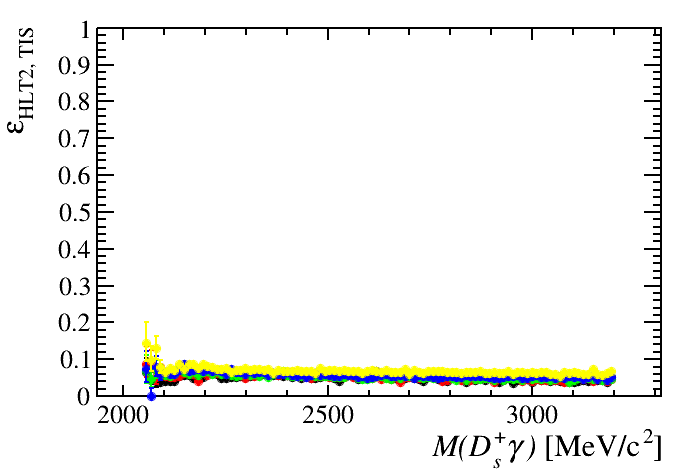

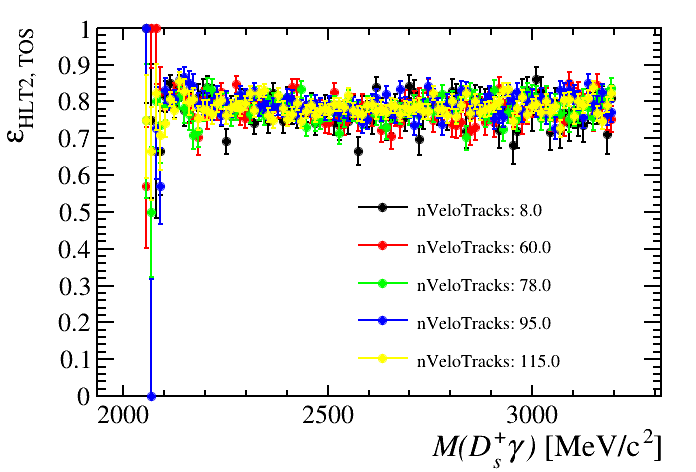

In [80]:
#for i in range(len(nVelo_bins)):
#    c1 = ROOT.TCanvas()
#    lgd = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
#    eff_plot(eff_data_hlt2_tis_nVelo[i], ROOT.kBlue, "#varepsilon_{HLT2, TIS}", Dsg_mass_label, ylabel, lgd)
#    eff_plot(eff_data_hlt2_tos_nVelo[i], ROOT.kRed,  "#varepsilon_{HLT2, TOS}", Dsg_mass_label, ylabel, lgd, fst=False)
#    lgd.Draw()
#    #c1.Draw()
#    if run2:
#        c1.SaveAs(f"./plots/Exp_Run2_hlt2_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
#    else:
#        c1.SaveAs(f"./plots/Exp_{pol}{year}_hlt2_eff_vs_Dsg_mass_nVelo_{i+1}.pdf")
        
c2 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.2, 0.9, 0.6)
i = 0
for eff, bin in zip(eff_data_hlt2_tis_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT2, TIS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT2, TIS}", lgd, fst=False)
lgd.Draw()
c2.Draw()
if run2:
    c2.SaveAs(f"./plots/Exp_Run2_hlt2_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c2.SaveAs(f"./plots/Exp_{pol}{year}_hlt2_eff_tis_vs_Dsg_mass_nVelo_bins.pdf")  

c3 = ROOT.TCanvas()
lgd = ROOT.TLegend(0.5, 0.2, 0.9, 0.6)
i = 0 
for eff, bin in zip(eff_data_hlt2_tos_nVelo, nVelo_bins):
    i += 1
    if i == 1:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT2, TOS}", lgd)
    else:
        eff_plot(eff, i, "nVeloTracks: " + str(bin), Dsg_mass_label, "#varepsilon_{HLT2, TOS}", lgd, fst=False)
lgd.Draw()
c3.Draw()
if run2:
    c3.SaveAs(f"./plots/Exp_Run2_hlt2_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")
else:
    c3.SaveAs(f"./plots/Exp_{pol}{year}_hlt2_eff_tos_vs_Dsg_mass_nVelo_bins.pdf")

#### TIS and TOS efficiency as function of nVeloTracks

In [52]:
df_data_sel_hlt2_tis = pd.DataFrame(tdf_data_sel_hlt2_tis.AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_data_sel_hlt2_tistos = pd.DataFrame(tdf_data_sel_hlt2_tistos.AsNumpy(columns=["DsgM", "nVeloTracks"]))

### Dsst mass
df_data_Dsst_sel_hlt2_tis    = df_data_sel_hlt2_tis.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")
df_data_Dsst_sel_hlt2_tistos = df_data_sel_hlt2_tistos.query(f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}")

### Ds1 mass
df_data_Ds1_sel_hlt2_tis    = df_data_sel_hlt2_tis.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")
df_data_Ds1_sel_hlt2_tistos = df_data_sel_hlt2_tistos.query(f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}")

In [53]:
Ds1_mass_cut  = f"DsgM > {Ds1_mass[0]} & DsgM < {Ds1_mass[1]}"
Dsst_mass_cut = f"DsgM > {Dsst_mass[0]} & DsgM < {Dsst_mass[1]}"

df_Ds1_MC_sel_hlt2_tis =  pd.DataFrame(tdf_Ds1_MC_sel_hlt2_tis.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_MC_sel_hlt2_tistos = pd.DataFrame(tdf_Ds1_MC_sel_hlt2_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_MC_sel_hlt2_tis =  pd.DataFrame(tdf_Dsst_MC_sel_hlt2_tis.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_MC_sel_hlt2_tistos = pd.DataFrame(tdf_Dsst_MC_sel_hlt2_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

In [54]:
df_Ds1_sig_sel_hlt2_tis =  pd.DataFrame(tdf_Ds1_sig_sel_hlt2_tis.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Ds1_sig_sel_hlt2_tistos = pd.DataFrame(tdf_Ds1_sig_sel_hlt2_tistos.Filter(Ds1_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

df_Dsst_sig_sel_hlt2_tis =  pd.DataFrame(tdf_Dsst_sig_sel_hlt2_tis.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"]))
df_Dsst_sig_sel_hlt2_tistos = pd.DataFrame(tdf_Dsst_sig_sel_hlt2_tistos.Filter(Dsst_mass_cut).AsNumpy(columns=["DsgM", "nVeloTracks"])) 

##### nVeloTracks integrated

In [55]:
mNDsst_data_sel_hlt2_tis = len(df_data_Dsst_sel_hlt2_tis["DsgM"]); uNDsst_data_sel_hlt2_tis = np.sqrt(mNDsst_data_sel_hlt2_tis)
mNDsst_data_sel_hlt2_tistos = len(df_data_Dsst_sel_hlt2_tistos["DsgM"]); uNDsst_data_sel_hlt2_tistos = np.sqrt(mNDsst_data_sel_hlt2_tistos)

NDsst_data_sel_hlt2_tis    = un.ufloat(mNDsst_data_sel_hlt2_tis, uNDsst_data_sel_hlt2_tis)
NDsst_data_sel_hlt2_tistos = un.ufloat(mNDsst_data_sel_hlt2_tistos, uNDsst_data_sel_hlt2_tistos)

eff_data_hlt2_tos_Dsst = NDsst_data_sel_hlt2_tistos / NDsst_data_sel_hlt2_tis

print(f"HLT2 TOS eff for Dsst mass in data = {eff_data_hlt2_tos_Dsst}")

mNDs1_data_sel_hlt2_tis = len(df_data_Ds1_sel_hlt2_tis["DsgM"]); uNDs1_data_sel_hlt2_tis = np.sqrt(mNDs1_data_sel_hlt2_tis)
mNDs1_data_sel_hlt2_tistos = len(df_data_Ds1_sel_hlt2_tistos["DsgM"]); uNDs1_data_sel_hlt2_tistos = np.sqrt(mNDs1_data_sel_hlt2_tistos)

NDs1_data_sel_hlt2_tis    = un.ufloat(mNDs1_data_sel_hlt2_tis, uNDs1_data_sel_hlt2_tis)
NDs1_data_sel_hlt2_tistos = un.ufloat(mNDs1_data_sel_hlt2_tistos, uNDs1_data_sel_hlt2_tistos)

eff_data_hlt2_tos_Ds1 = NDs1_data_sel_hlt2_tistos / NDs1_data_sel_hlt2_tis

print(f"HLT2 TOS eff for Ds1 mass in data = {eff_data_hlt1_tos_Ds1}")

HLT2 TOS eff for Dsst mass in data = 0.796+/-0.011
HLT2 TOS eff for Ds1 mass in data = 0.920+/-0.004


In [56]:
mNDsst_MC_sel_hlt2_tis = len(df_Dsst_MC_sel_hlt2_tis["DsgM"]); uNDsst_MC_sel_hlt2_tis = np.sqrt(mNDsst_MC_sel_hlt2_tis)
mNDsst_MC_sel_hlt2_tistos = len(df_Dsst_MC_sel_hlt2_tistos["DsgM"]); uNDsst_MC_sel_hlt2_tistos = np.sqrt(mNDsst_MC_sel_hlt2_tistos)

NDsst_MC_sel_hlt2_tis    = un.ufloat(mNDsst_MC_sel_hlt2_tis, uNDsst_MC_sel_hlt2_tis)
NDsst_MC_sel_hlt2_tistos = un.ufloat(mNDsst_MC_sel_hlt2_tistos, uNDsst_MC_sel_hlt2_tistos)

eff_MC_hlt2_tos_Dsst = NDsst_MC_sel_hlt2_tistos / NDsst_MC_sel_hlt2_tis

print(f"HLT2 TOS eff for Dsst mass in not truth-matched MC = {eff_MC_hlt2_tos_Dsst}")

mNDs1_MC_sel_hlt2_tis = len(df_Ds1_MC_sel_hlt2_tis["DsgM"]); uNDs1_MC_sel_hlt2_tis = np.sqrt(mNDs1_MC_sel_hlt2_tis)
mNDs1_MC_sel_hlt2_tistos = len(df_Ds1_MC_sel_hlt2_tistos["DsgM"]); uNDs1_MC_sel_hlt2_tistos = np.sqrt(mNDs1_MC_sel_hlt2_tistos)

NDs1_MC_sel_hlt2_tis    = un.ufloat(mNDs1_MC_sel_hlt2_tis, uNDs1_MC_sel_hlt2_tis)
NDs1_MC_sel_hlt2_tistos = un.ufloat(mNDs1_MC_sel_hlt2_tistos, uNDs1_MC_sel_hlt2_tistos)

eff_MC_hlt2_tos_Ds1 = NDs1_MC_sel_hlt2_tistos / NDs1_MC_sel_hlt2_tis

print(f"HLT2 TOS eff for Ds1 mass in not truth-matched MC = {eff_MC_hlt2_tos_Ds1}")

HLT2 TOS eff for Dsst mass in not truth-matched MC = 0.753+/-0.030
HLT2 TOS eff for Ds1 mass in not truth-matched MC = 0.776+/-0.008


In [57]:
mNDsst_sig_sel_hlt2_tis = len(df_Dsst_sig_sel_hlt2_tis["DsgM"]); uNDsst_sig_sel_hlt2_tis = np.sqrt(mNDsst_sig_sel_hlt2_tis)
mNDsst_sig_sel_hlt2_tistos = len(df_Dsst_sig_sel_hlt2_tistos["DsgM"]); uNDsst_sig_sel_hlt2_tistos = np.sqrt(mNDsst_sig_sel_hlt2_tistos)

NDsst_sig_sel_hlt2_tis    = un.ufloat(mNDsst_sig_sel_hlt2_tis, uNDsst_sig_sel_hlt2_tis)
NDsst_sig_sel_hlt2_tistos = un.ufloat(mNDsst_sig_sel_hlt2_tistos, uNDsst_sig_sel_hlt2_tistos)

eff_sig_hlt2_tos_Dsst = NDsst_sig_sel_hlt2_tistos / NDsst_sig_sel_hlt2_tis

print(f"HLT2 TOS eff for Dsst mass in truth-matched MC = {eff_sig_hlt2_tos_Dsst}")

mNDs1_sig_sel_hlt2_tis = len(df_Ds1_sig_sel_hlt2_tis["DsgM"]); uNDs1_sig_sel_hlt2_tis = np.sqrt(mNDs1_sig_sel_hlt2_tis)
mNDs1_sig_sel_hlt2_tistos = len(df_Ds1_sig_sel_hlt2_tistos["DsgM"]); uNDs1_sig_sel_hlt2_tistos = np.sqrt(mNDs1_sig_sel_hlt2_tistos)

NDs1_sig_sel_hlt2_tis    = un.ufloat(mNDs1_sig_sel_hlt2_tis, uNDs1_sig_sel_hlt2_tis)
NDs1_sig_sel_hlt2_tistos = un.ufloat(mNDs1_sig_sel_hlt2_tistos, uNDs1_sig_sel_hlt2_tistos)

eff_sig_hlt2_tos_Ds1 = NDs1_sig_sel_hlt2_tistos / NDs1_sig_sel_hlt2_tis

print(f"HLT2 eff for Ds1 mass in truth-matched MC = {eff_sig_hlt2_tos_Ds1}")

HLT2 TOS eff for Dsst mass in truth-matched MC = 0.75+/-0.04
HLT2 eff for Ds1 mass in truth-matched MC = 0.780+/-0.009


##### nVeloTracks binning

data

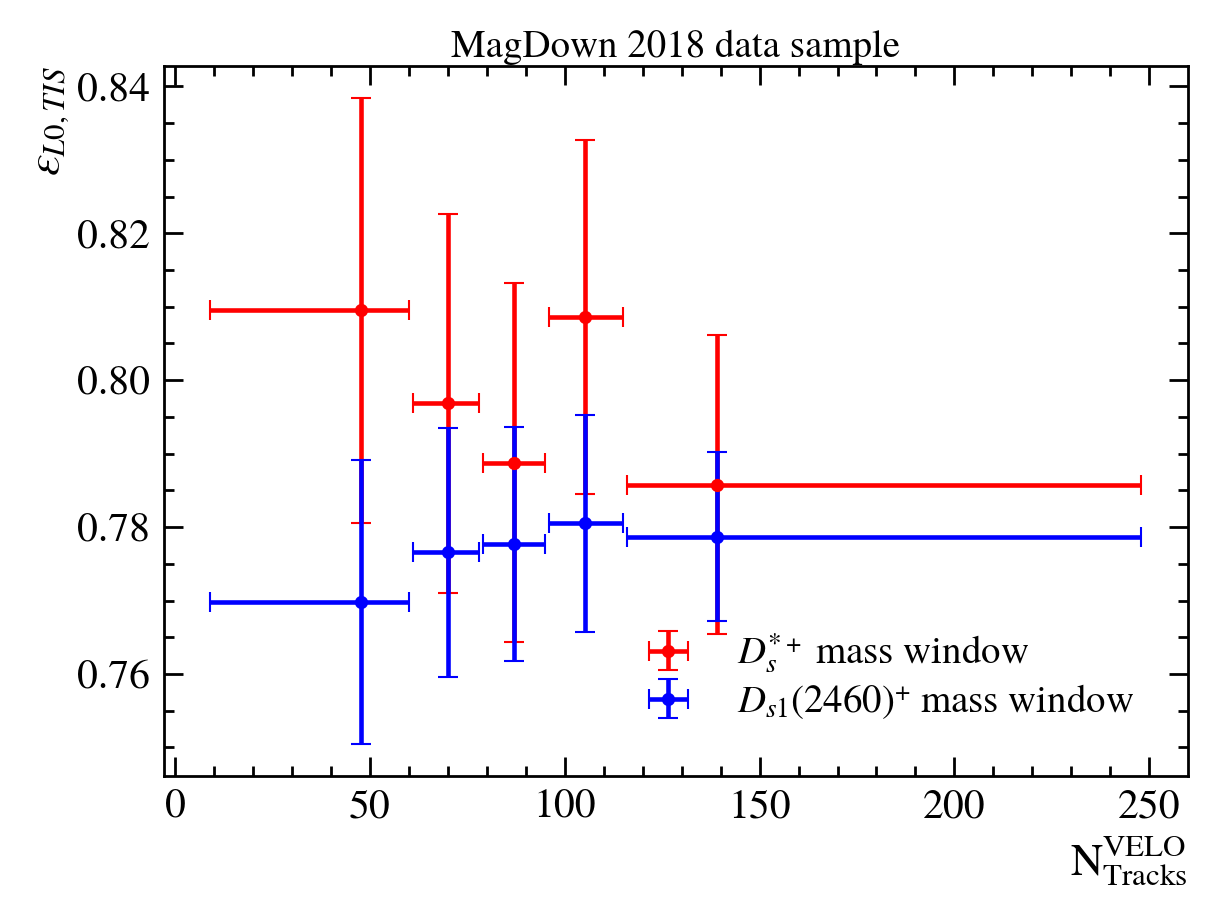

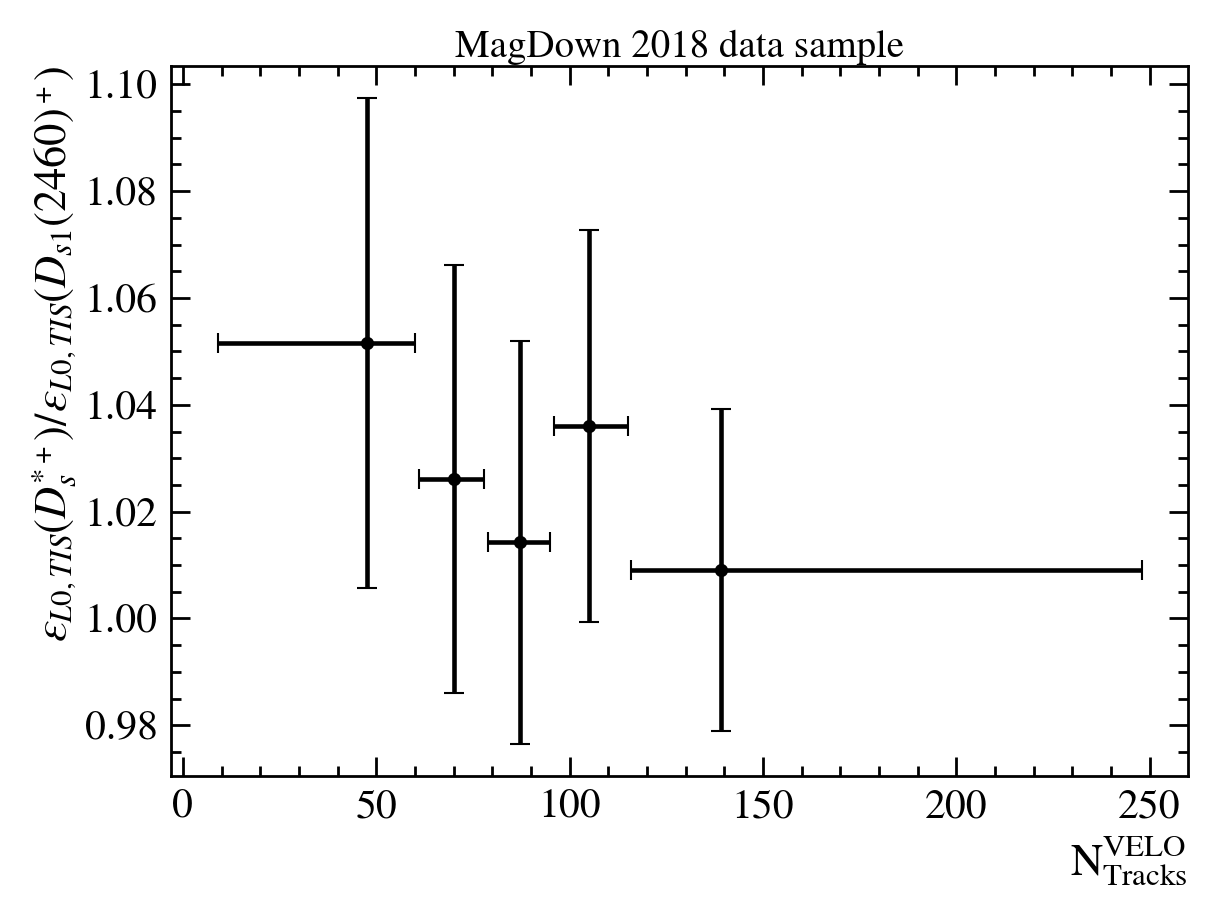

In [58]:
### Dsst mass
mN_data_nVelo_Dsst_sel_hlt2_tis, nVelo_bins    = np.histogram(df_data_Dsst_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Dsst_sel_hlt2_tistos, nVelo_bins = np.histogram(df_data_Dsst_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Dsst_sel_hlt2_tis = np.sqrt(mN_data_nVelo_Dsst_sel_hlt2_tis)
uN_data_nVelo_Dsst_sel_hlt2_tistos = np.sqrt(mN_data_nVelo_Dsst_sel_hlt2_tistos)

N_data_nVelo_Dsst_sel_hlt2_tis  = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_hlt2_tis, uN_data_nVelo_Dsst_sel_hlt2_tis)])
N_data_nVelo_Dsst_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Dsst_sel_hlt2_tistos, uN_data_nVelo_Dsst_sel_hlt2_tistos)])

eff_data_hlt2_tos_nVelo_Dsst  = N_data_nVelo_Dsst_sel_hlt2_tistos / N_data_nVelo_Dsst_sel_hlt2_tis

meff_data_hlt2_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_data_hlt2_tos_nVelo_Dsst])
ueff_data_hlt2_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_data_hlt2_tos_nVelo_Dsst])

### Ds1 mass
mN_data_nVelo_Ds1_sel_hlt2_tis, nVelo_bins    = np.histogram(df_data_Ds1_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_Ds1_sel_hlt2_tistos, nVelo_bins = np.histogram(df_data_Ds1_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_Ds1_sel_hlt2_tis    = np.sqrt(mN_data_nVelo_Ds1_sel_hlt2_tis)
uN_data_nVelo_Ds1_sel_hlt2_tistos = np.sqrt(mN_data_nVelo_Ds1_sel_hlt2_tistos)

N_data_nVelo_Ds1_sel_hlt2_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_hlt2_tis, uN_data_nVelo_Ds1_sel_hlt2_tis)])
N_data_nVelo_Ds1_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_Ds1_sel_hlt2_tistos, uN_data_nVelo_Ds1_sel_hlt2_tistos)])

eff_data_hlt2_tos_nVelo_Ds1  = N_data_nVelo_Ds1_sel_hlt2_tistos / N_data_nVelo_Ds1_sel_hlt2_tis

meff_data_hlt2_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_data_hlt2_tos_nVelo_Ds1])
ueff_data_hlt2_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_data_hlt2_tos_nVelo_Ds1])

### ratio
eff_data_hlt2_tos_nVelo_ratio  = eff_data_hlt2_tos_nVelo_Dsst / eff_data_hlt2_tos_nVelo_Ds1
meff_data_hlt2_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_data_hlt2_tos_nVelo_ratio])
ueff_data_hlt2_tos_nVelo_ratio = np.array([r.std_dev for r in eff_data_hlt2_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_Dsst, ueff_data_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_Ds1, ueff_data_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_ratio, ueff_data_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Not matched MC

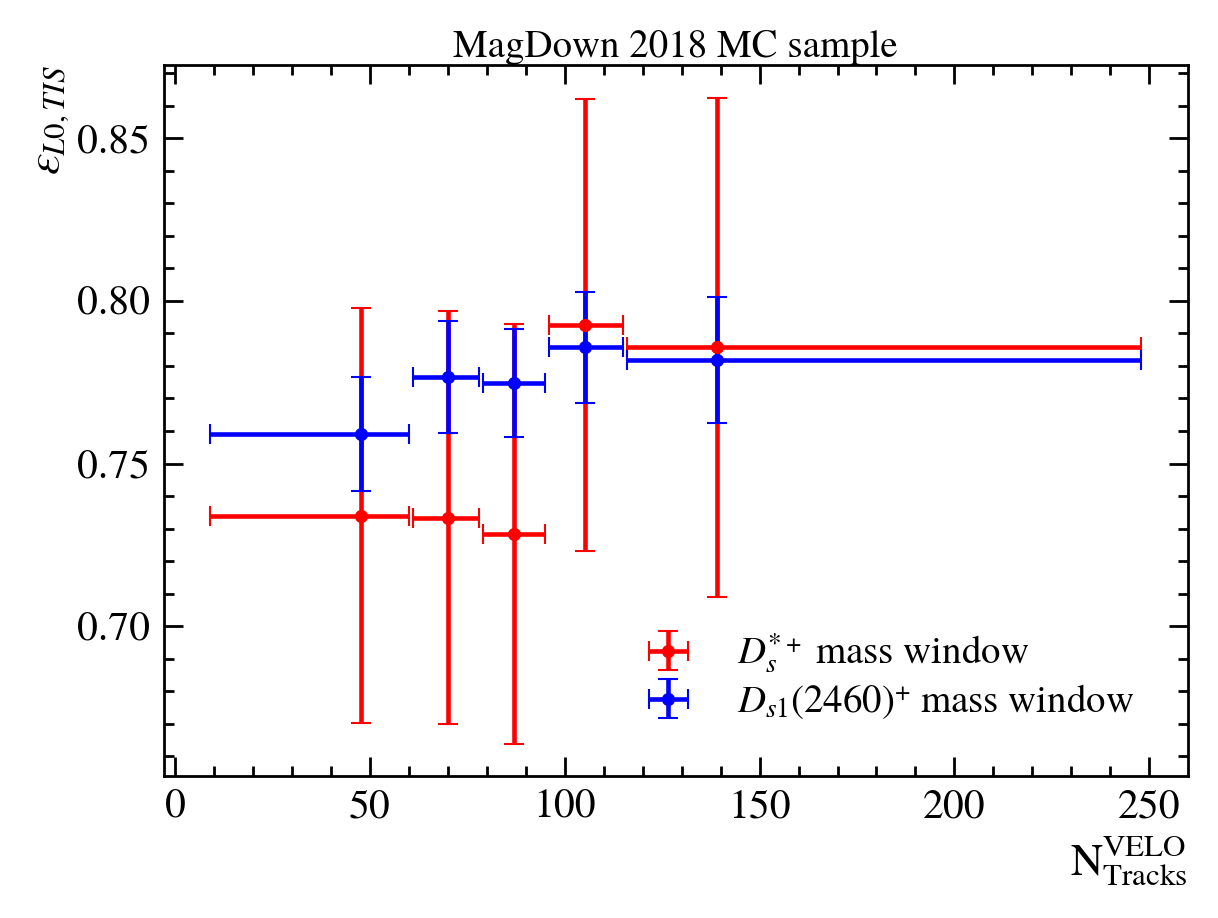

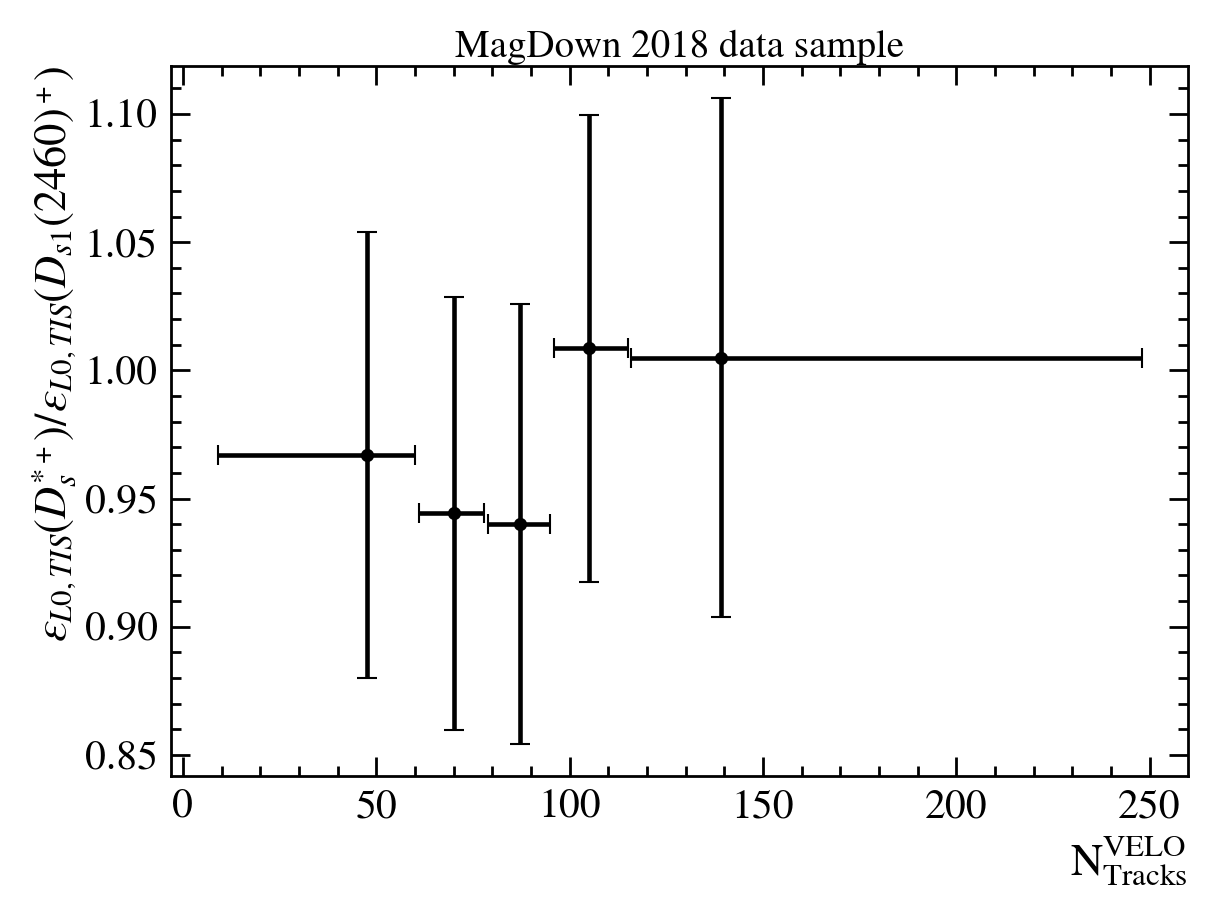

In [59]:
### Dsst mass
mN_mc_nVelo_Dsst_sel_hlt2_tis, nVelo_bins    = np.histogram(df_Dsst_MC_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Dsst_sel_hlt2_tistos, nVelo_bins = np.histogram(df_Dsst_MC_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Dsst_sel_hlt2_tis = np.sqrt(mN_mc_nVelo_Dsst_sel_hlt2_tis)
uN_mc_nVelo_Dsst_sel_hlt2_tistos = np.sqrt(mN_mc_nVelo_Dsst_sel_hlt2_tistos)

N_mc_nVelo_Dsst_sel_hlt2_tis  = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_hlt2_tis, uN_mc_nVelo_Dsst_sel_hlt2_tis)])
N_mc_nVelo_Dsst_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Dsst_sel_hlt2_tistos, uN_mc_nVelo_Dsst_sel_hlt2_tistos)])

eff_mc_hlt2_tos_nVelo_Dsst  = N_mc_nVelo_Dsst_sel_hlt2_tistos / N_mc_nVelo_Dsst_sel_hlt2_tis
meff_mc_hlt2_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_mc_hlt2_tos_nVelo_Dsst])
ueff_mc_hlt2_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_mc_hlt2_tos_nVelo_Dsst])

### Ds1 mass
mN_mc_nVelo_Ds1_sel_hlt2_tis, nVelo_bins    = np.histogram(df_Ds1_MC_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_mc_nVelo_Ds1_sel_hlt2_tistos, nVelo_bins = np.histogram(df_Ds1_MC_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_mc_nVelo_Ds1_sel_hlt2_tis    = np.sqrt(mN_mc_nVelo_Ds1_sel_hlt2_tis)
uN_mc_nVelo_Ds1_sel_hlt2_tistos = np.sqrt(mN_mc_nVelo_Ds1_sel_hlt2_tistos)

N_mc_nVelo_Ds1_sel_hlt2_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_hlt2_tis, uN_mc_nVelo_Ds1_sel_hlt2_tis)])
N_mc_nVelo_Ds1_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_mc_nVelo_Ds1_sel_hlt2_tistos, uN_mc_nVelo_Ds1_sel_hlt2_tistos)])

eff_mc_hlt2_tos_nVelo_Ds1  = N_mc_nVelo_Ds1_sel_hlt2_tistos / N_mc_nVelo_Ds1_sel_hlt2_tis

meff_mc_hlt2_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_mc_hlt2_tos_nVelo_Ds1])
ueff_mc_hlt2_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_mc_hlt2_tos_nVelo_Ds1])

### ratio
eff_mc_hlt2_tos_nVelo_ratio  = eff_mc_hlt2_tos_nVelo_Dsst / eff_mc_hlt2_tos_nVelo_Ds1
meff_mc_hlt2_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_mc_hlt2_tos_nVelo_ratio])
ueff_mc_hlt2_tos_nVelo_ratio = np.array([r.std_dev for r in eff_mc_hlt2_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_Dsst, ueff_mc_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_Ds1, ueff_mc_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_ratio, ueff_mc_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Matched MC

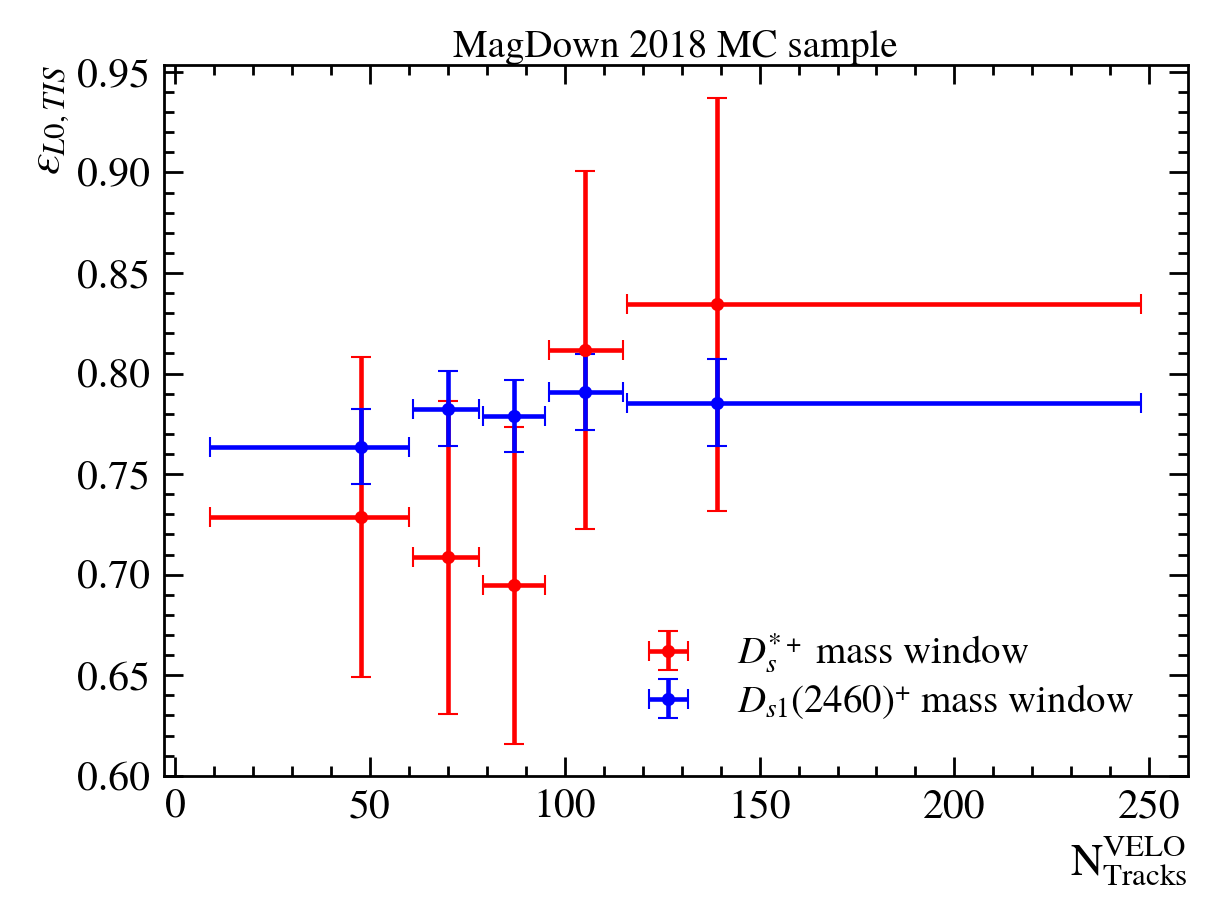

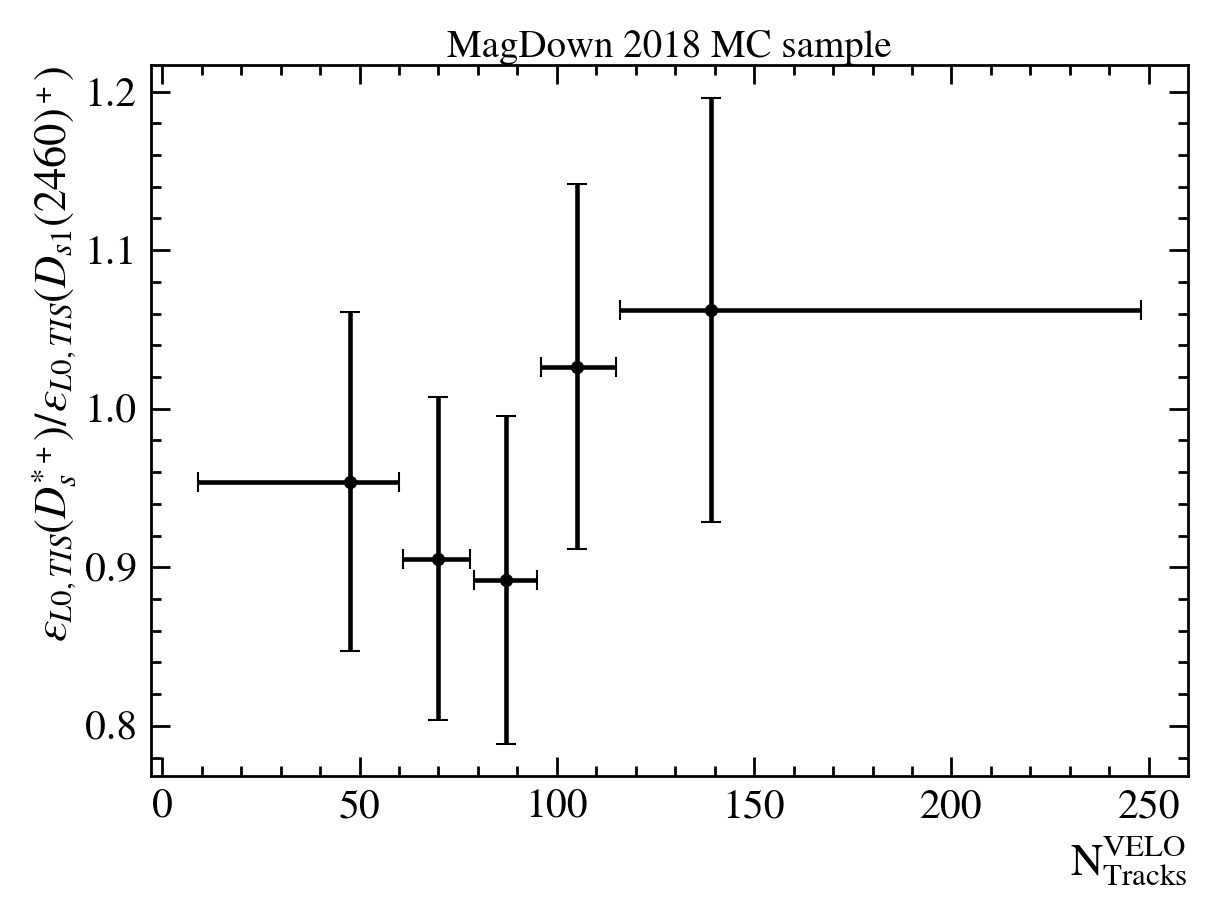

In [60]:
### Dsst mass
mN_sig_nVelo_Dsst_sel_hlt2_tis, nVelo_bins    = np.histogram(df_Dsst_sig_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Dsst_sel_hlt2_tistos, nVelo_bins = np.histogram(df_Dsst_sig_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Dsst_sel_hlt2_tis = np.sqrt(mN_sig_nVelo_Dsst_sel_hlt2_tis)
uN_sig_nVelo_Dsst_sel_hlt2_tistos = np.sqrt(mN_sig_nVelo_Dsst_sel_hlt2_tistos)

N_sig_nVelo_Dsst_sel_hlt2_tis    = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_hlt2_tis, uN_sig_nVelo_Dsst_sel_hlt2_tis)])
N_sig_nVelo_Dsst_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Dsst_sel_hlt2_tistos, uN_sig_nVelo_Dsst_sel_hlt2_tistos)])

eff_sig_hlt2_tos_nVelo_Dsst  = N_sig_nVelo_Dsst_sel_hlt2_tistos / N_sig_nVelo_Dsst_sel_hlt2_tis

meff_sig_hlt2_tos_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_sig_hlt2_tos_nVelo_Dsst])
ueff_sig_hlt2_tos_nVelo_Dsst = np.array([eff.std_dev for eff in eff_sig_hlt2_tos_nVelo_Dsst])

### Ds1 mass
mN_sig_nVelo_Ds1_sel_hlt2_tis, nVelo_bins    = np.histogram(df_Ds1_sig_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_sig_nVelo_Ds1_sel_hlt2_tistos, nVelo_bins = np.histogram(df_Ds1_sig_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_sig_nVelo_Ds1_sel_hlt2_tis    = np.sqrt(mN_sig_nVelo_Ds1_sel_hlt2_tis)
uN_sig_nVelo_Ds1_sel_hlt2_tistos = np.sqrt(mN_sig_nVelo_Ds1_sel_hlt2_tistos)

N_sig_nVelo_Ds1_sel_hlt2_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_hlt2_tis, uN_sig_nVelo_Ds1_sel_hlt2_tis)])
N_sig_nVelo_Ds1_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_sig_nVelo_Ds1_sel_hlt2_tistos, uN_sig_nVelo_Ds1_sel_hlt2_tistos)])

eff_sig_hlt2_tos_nVelo_Ds1  = N_sig_nVelo_Ds1_sel_hlt2_tistos / N_sig_nVelo_Ds1_sel_hlt2_tis

meff_sig_hlt2_tos_nVelo_Ds1 = np.array([eff.nominal_value for eff in eff_sig_hlt2_tos_nVelo_Ds1])
ueff_sig_hlt2_tos_nVelo_Ds1 = np.array([eff.std_dev for eff in eff_sig_hlt2_tos_nVelo_Ds1])

### ratio
eff_sig_hlt2_tos_nVelo_ratio  = eff_sig_hlt2_tos_nVelo_Dsst / eff_sig_hlt2_tos_nVelo_Ds1
meff_sig_hlt2_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_sig_hlt2_tos_nVelo_ratio])
ueff_sig_hlt2_tos_nVelo_ratio = np.array([r.std_dev for r in eff_sig_hlt2_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_Dsst, ueff_sig_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+}$ mass window")
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_Ds1, ueff_sig_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^{+}$ mass window")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} MC sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_ratio, ueff_sig_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"{pol} {year} MC sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')



Comparision data and MC

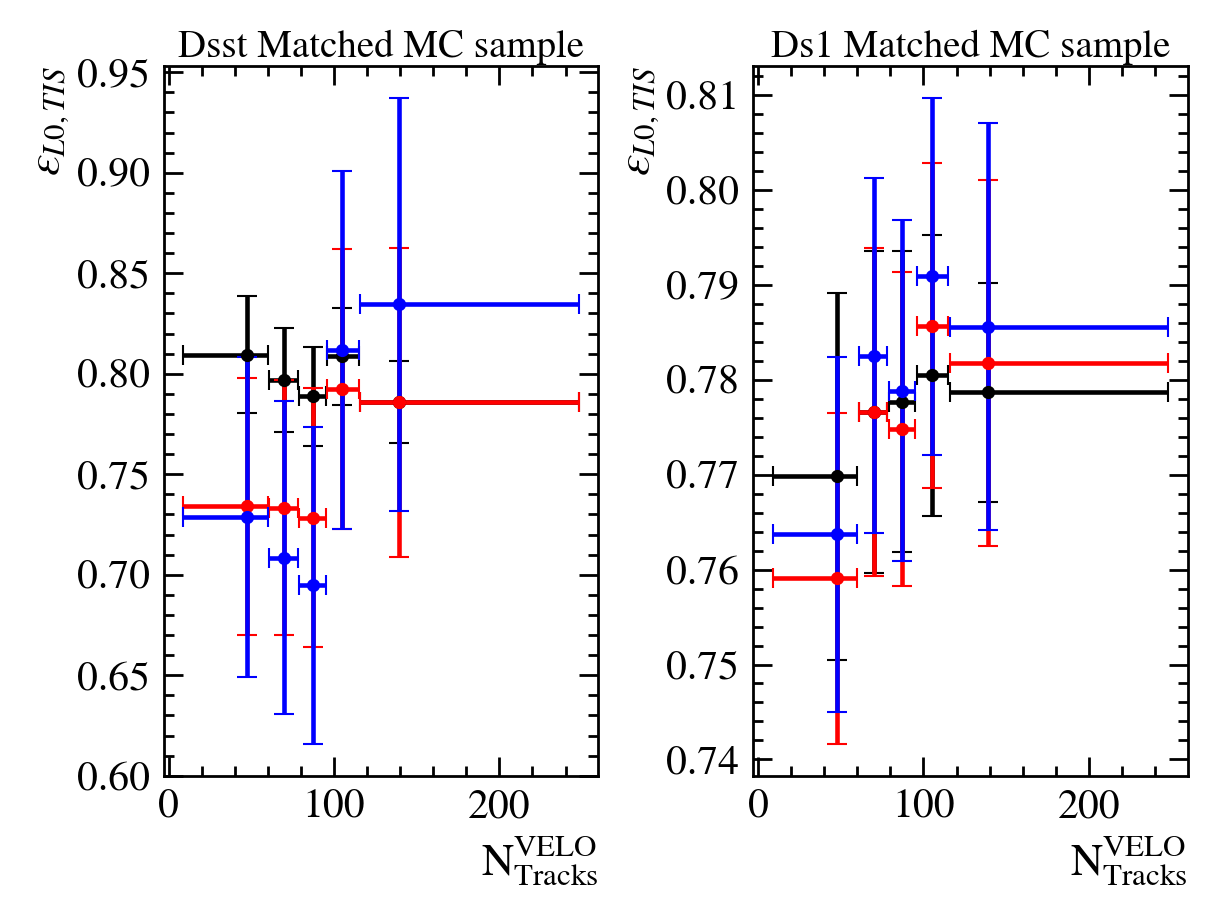

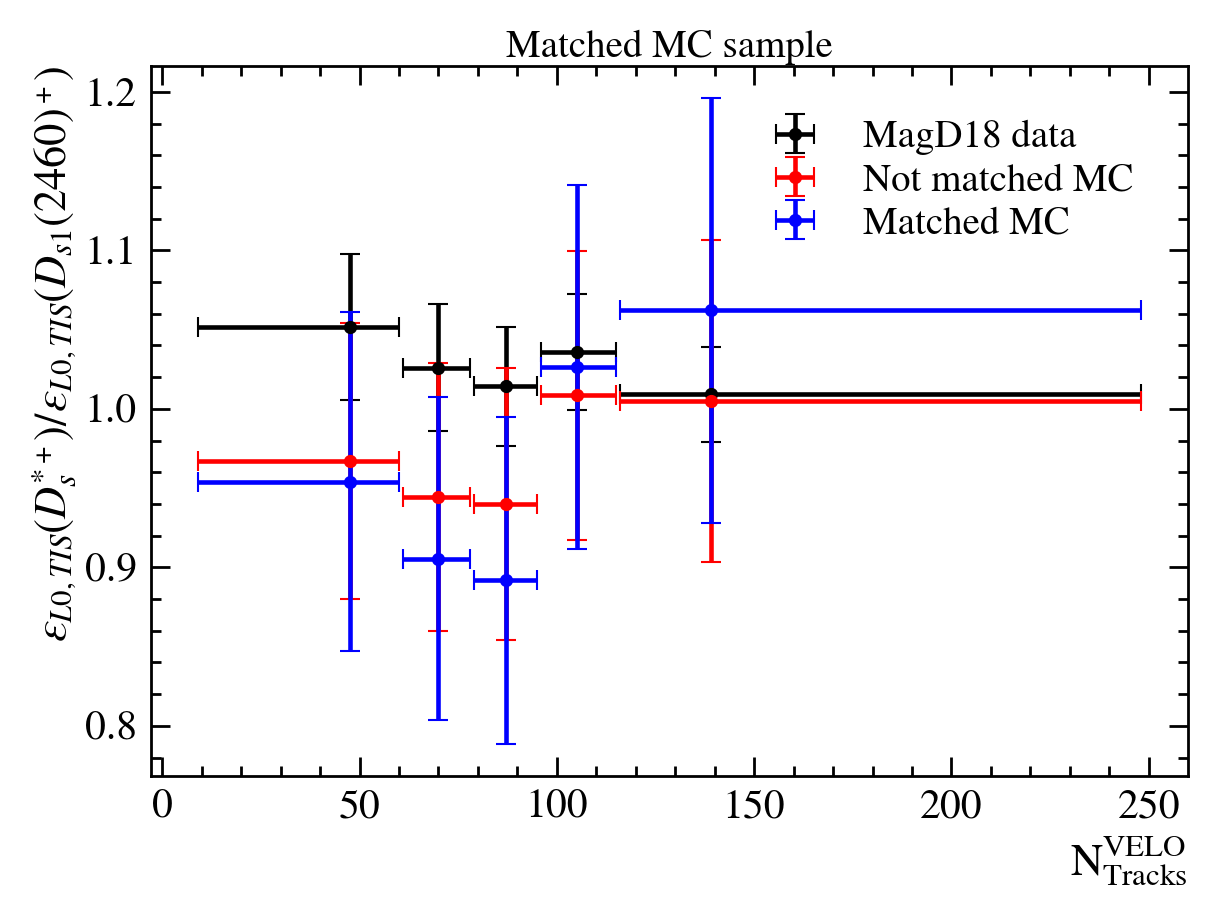

In [61]:
plt.figure(1)
plt.subplot(121)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_Dsst, ueff_data_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_Dsst, ueff_mc_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_Dsst, ueff_sig_hlt2_tos_nVelo_Dsst, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Dsst Matched MC sample")
#plt.legend(loc='lower right')
plt.subplot(122)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_Ds1, ueff_data_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=r"MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_Ds1, ueff_mc_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_Ds1, ueff_sig_hlt2_tos_nVelo_Ds1, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"Ds1 Matched MC sample")
plt.savefig(f"./plots/Comp_eff_hlt2_tos_vs_nVelo.pdf", dpi=300, bbox_inches='tight')


plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_ratio, ueff_data_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label="MagD18 data")
plt.errorbar(nVelo_means, meff_mc_hlt2_tos_nVelo_ratio, ueff_mc_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label="Not matched MC")
plt.errorbar(nVelo_means, meff_sig_hlt2_tos_nVelo_ratio, ueff_sig_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label="Matched MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}(D_s^{*+})/\varepsilon_{L0, TIS}(D_{s1}(2460)^+)$")
plt.title(f"Matched MC sample")
plt.legend()
plt.savefig(f"./plots/Comp_eff_hlt2_tos_ratio_vs_nVelo.pdf", dpi=300, bbox_inches='tight')

#### No signal mas region ratio

In [62]:
hm_cut  = "DsgM > 2700 & DsgM <= 2900"
uhm_cut = "DsgM > 2900"  

In [63]:
### Dsst mass
df_data_hm_sel_hlt2_tis    = df_data_sel_hlt2_tis.query(hm_cut)
df_data_hm_sel_hlt2_tistos = df_data_sel_hlt2_tistos.query(hm_cut)

### Ds1 mass
df_data_uhm_sel_hlt2_tis    = df_data_sel_hlt2_tis.query(uhm_cut)
df_data_uhm_sel_hlt2_tistos = df_data_sel_hlt2_tistos.query(uhm_cut)

##### nVeloTracks integrated

In [65]:
mN_data_hm_sel_hlt2_tis = len(df_data_hm_sel_hlt2_tis["DsgM"]); uN_data_hm_sel_hlt2_tis = np.sqrt(mN_data_hm_sel_hlt2_tis)
mN_data_hm_sel_hlt2_tistos = len(df_data_hm_sel_hlt2_tistos["DsgM"]); uN_data_hm_sel_hlt2_tistos = np.sqrt(mN_data_hm_sel_hlt2_tistos)

N_data_hm_sel_hlt2_tis = un.ufloat(mN_data_hm_sel_hlt2_tis, uN_data_hm_sel_hlt2_tis)
N_data_hm_sel_hlt2_tistos = un.ufloat(mN_data_hm_sel_hlt2_tistos, uN_data_hm_sel_hlt2_tistos)

eff_data_hlt2_tos_hm  = N_data_hm_sel_hlt2_tistos / N_data_hm_sel_hlt2_tis

print(f"HLT2 TOS eff for {hm_cut} mass in data = {eff_data_hlt2_tos_hm}")

mN_data_uhm_sel_hlt2_tis = len(df_data_uhm_sel_hlt2_tis["DsgM"]); uN_data_uhm_sel_hlt2_tis = np.sqrt(mN_data_uhm_sel_hlt2_tis)
mN_data_uhm_sel_hlt2_tistos = len(df_data_uhm_sel_hlt2_tistos["DsgM"]); uN_data_uhm_sel_hlt2_tistos = np.sqrt(mN_data_uhm_sel_hlt2_tistos)

N_data_uhm_sel_hlt2_tis = un.ufloat(mN_data_uhm_sel_hlt2_tis, uN_data_uhm_sel_hlt2_tis)
N_data_uhm_sel_hlt2_tistos = un.ufloat(mN_data_uhm_sel_hlt2_tistos, uN_data_uhm_sel_hlt2_tistos)

eff_data_hlt2_tos_uhm  = N_data_uhm_sel_hlt2_tistos / N_data_uhm_sel_hlt2_tis

print(f"HLT2 TOS eff for {uhm_cut} mass in data = {eff_data_hlt2_tos_uhm}")

HLT2 TOS eff for DsgM > 2700 & DsgM <= 2900 mass in data = 0.785+/-0.008
HLT2 TOS eff for DsgM > 2900 mass in data = 0.789+/-0.007


##### nVeloTracks binning

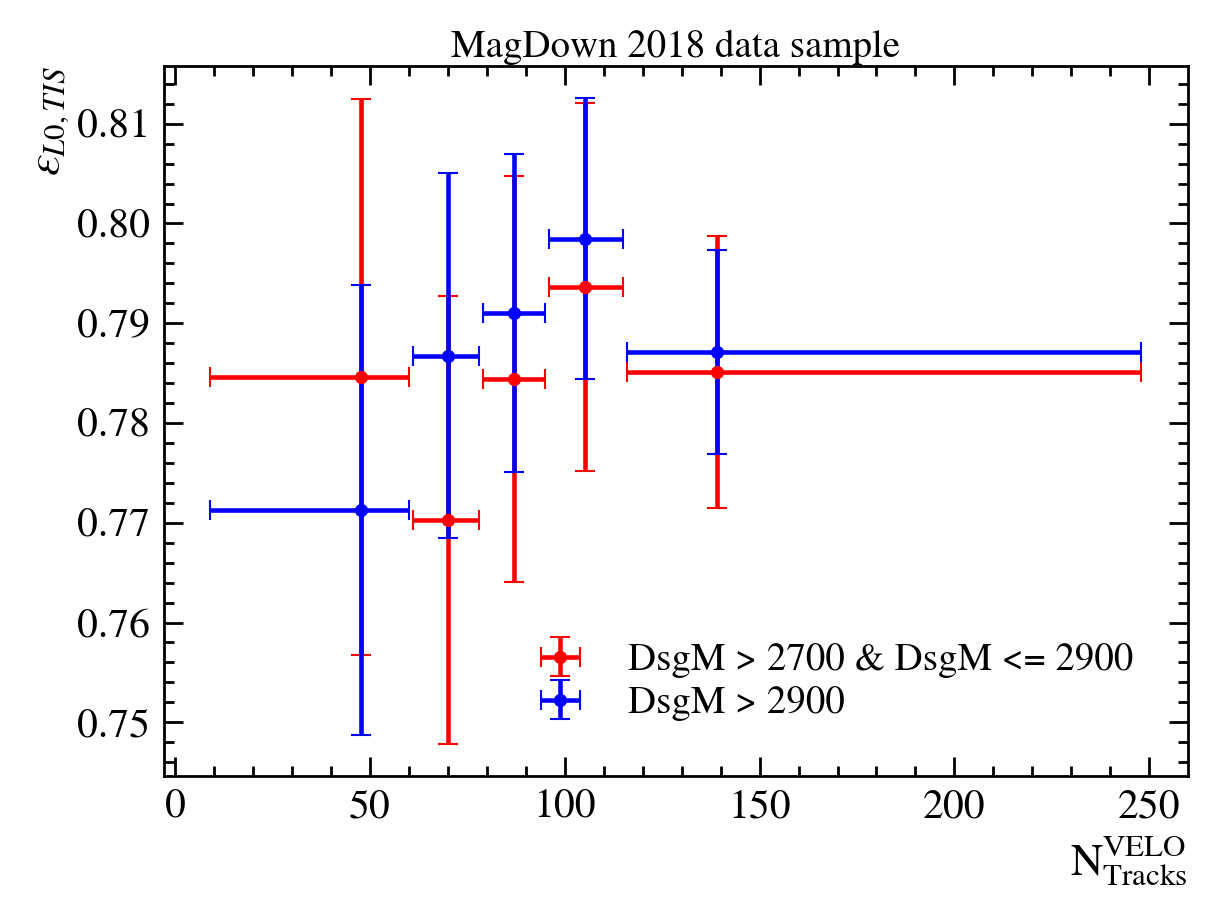

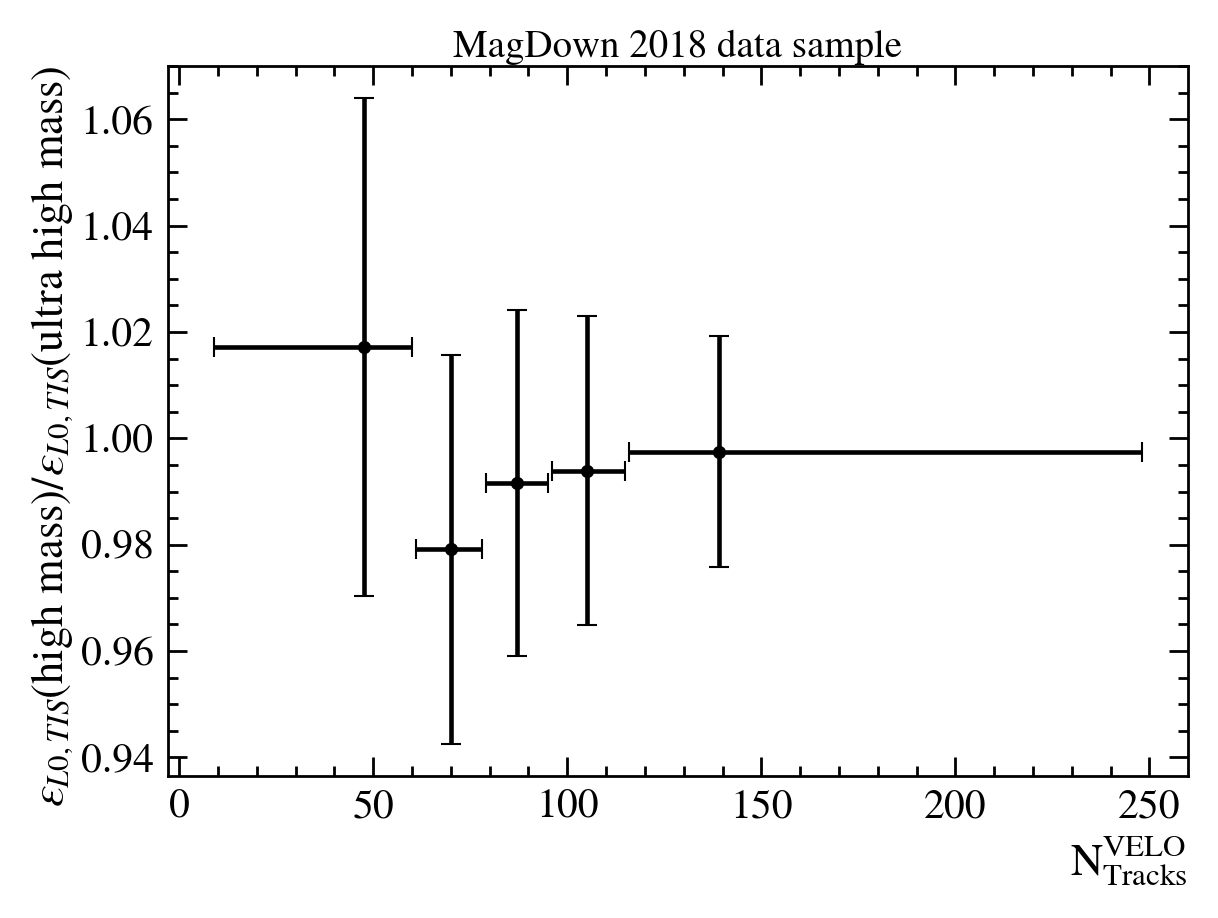

In [64]:
### Dsst mass
mN_data_nVelo_hm_sel_hlt2_tis, nVelo_bins    = np.histogram(df_data_hm_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_hm_sel_hlt2_tistos, nVelo_bins = np.histogram(df_data_hm_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_hm_sel_hlt2_tis = np.sqrt(mN_data_nVelo_hm_sel_hlt2_tis)
uN_data_nVelo_hm_sel_hlt2_tistos = np.sqrt(mN_data_nVelo_hm_sel_hlt2_tistos)

N_data_nVelo_hm_sel_hlt2_tis    = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_hlt2_tis, uN_data_nVelo_hm_sel_hlt2_tis)])
N_data_nVelo_hm_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_hm_sel_hlt2_tistos, uN_data_nVelo_hm_sel_hlt2_tistos)])

eff_data_hlt2_tos_nVelo_hm  = N_data_nVelo_hm_sel_hlt2_tistos / N_data_nVelo_hm_sel_hlt2_tis

meff_data_hlt2_tos_nVelo_hm = np.array([eff.nominal_value for eff in eff_data_hlt2_tos_nVelo_hm])
ueff_data_hlt2_tos_nVelo_hm = np.array([eff.std_dev for eff in eff_data_hlt2_tos_nVelo_hm])

### Ds1 mass
mN_data_nVelo_uhm_sel_hlt2_tis, nVelo_bins    = np.histogram(df_data_uhm_sel_hlt2_tis["nVeloTracks"], nVelo_intervals)
mN_data_nVelo_uhm_sel_hlt2_tistos, nVelo_bins = np.histogram(df_data_uhm_sel_hlt2_tistos["nVeloTracks"], nVelo_intervals)

uN_data_nVelo_uhm_sel_hlt2_tis    = np.sqrt(mN_data_nVelo_uhm_sel_hlt2_tis)
uN_data_nVelo_uhm_sel_hlt2_tistos = np.sqrt(mN_data_nVelo_uhm_sel_hlt2_tistos)

N_data_nVelo_uhm_sel_hlt2_tis = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_hlt2_tis, uN_data_nVelo_uhm_sel_hlt2_tis)])
N_data_nVelo_uhm_sel_hlt2_tistos = np.array([un.ufloat(m, u) for m, u in zip(mN_data_nVelo_uhm_sel_hlt2_tistos, uN_data_nVelo_uhm_sel_hlt2_tistos)])

eff_data_hlt2_tos_nVelo_uhm  = N_data_nVelo_uhm_sel_hlt2_tistos / N_data_nVelo_uhm_sel_hlt2_tis

meff_data_hlt2_tos_nVelo_uhm = np.array([eff.nominal_value for eff in eff_data_hlt2_tos_nVelo_uhm])
ueff_data_hlt2_tos_nVelo_uhm = np.array([eff.std_dev for eff in eff_data_hlt2_tos_nVelo_uhm])

### ratio
eff_data_hlt2_tos_nVelo_ratio  = eff_data_hlt2_tos_nVelo_hm / eff_data_hlt2_tos_nVelo_uhm
meff_data_hlt2_tos_nVelo_ratio = np.array([r.nominal_value for r in eff_data_hlt2_tos_nVelo_ratio])
ueff_data_hlt2_tos_nVelo_ratio = np.array([r.std_dev for r in eff_data_hlt2_tos_nVelo_ratio])

plt.figure(1)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_hm, ueff_data_hlt2_tos_nVelo_hm, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=f"{hm_cut}")
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_uhm, ueff_data_hlt2_tos_nVelo_uhm, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=f"{uhm_cut}")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$")
plt.title(f"{pol} {year} data sample")
plt.legend(loc='lower right')
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_data_hlt2_tos_nVelo_ratio, ueff_data_hlt2_tos_nVelo_ratio, 
             xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{L0, TIS}$(high mass)/$\varepsilon_{L0, TIS}$(ultra high mass)")
plt.title(f"{pol} {year} data sample")
if run2:
    plt.savefig(f"./plots/Exp_Run2_eff_hlt2_tos_ratio_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"./plots/Exp_{pol}_{year}_eff_hlt2_tos_ratio_vs_nVelo_no_sig_region.pdf", dpi=300, bbox_inches='tight')

